In [14]:
script="""
import os #5556223216
import io
import PIL.Image, PIL.ImageDraw
import base64
import zipfile
import json
import requests
import numpy as np
import matplotlib.pylab as pl
import matplotlib.pyplot as plt
import glob
import re
import pickle
from skimage.transform import resize, rotate
from skimage.util import pad
from skimage.morphology import skeletonize, square, disk, binary_dilation
from skimage.filters.rank import median, sum, mean
from skimage.exposure import adjust_gamma
from skimage.color import gray2rgb, rgb2gray
from skimage.measure import regionprops
from google.protobuf.json_format import MessageToDict
from tensorflow.python.framework import convert_to_constants


import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))
os.environ['FFMPEG_BINARY'] = 'ffmpeg'


def np2pil(a):
    if a.dtype in [np.float32, np.float64]:
        a = np.uint8(np.clip(a, 0, 1)*255)
    return PIL.Image.fromarray(a)

def imwrite(f, a, fmt=None):
    a = np.asarray(a)
    if isinstance(f, str):
        fmt = f.rsplit('.', 1)[-1].lower()
        if fmt == 'jpg':
            fmt = 'jpeg'
        f = open(f, 'wb')
    np2pil(a).save(f, fmt, quality=95)

def imencode(a, fmt='jpeg'):
    a = np.asarray(a)
    if len(a.shape) == 3 and a.shape[-1] == 4:
        fmt = 'png'
    f = io.BytesIO()
    imwrite(f, a, fmt)
    return f.getvalue()

def im2url(a, fmt='jpeg'):
    encoded = imencode(a, fmt)
    base64_byte_string = base64.b64encode(encoded).decode('ascii')
    return 'data:image/' + fmt.upper() + ';base64,' + base64_byte_string

def imshow(a, fmt='jpeg'):
    display(Image(data=imencode(a, fmt)))

def tile2d(a, w=None):
    a = np.asarray(a)
    if w is None:
        w = int(np.ceil(np.sqrt(len(a))))
    th, tw = a.shape[1:3]
    pad = (w-len(a))%w
    a = np.pad(a, [(0, pad)]+[(0, 0)]*(a.ndim-1), 'constant')
    h = len(a)//w
    a = a.reshape([h, w]+list(a.shape[1:]))
    a = np.rollaxis(a, 2, 1).reshape([th*h, tw*w]+list(a.shape[4:]))
    return a

def zoom(img, scale=4):
    img = np.repeat(img, scale, 0)
    img = np.repeat(img, scale, 1)
    return img


# Title Data generator
color_lookup = tf.constant([
            [128, 0, 0],  #Para arterias, Rojo
            [0, 128, 128], #Para venas, Azul
            [0, 0, 0], # This is the default for digits/vasos sanguíneos
            [255, 255, 255] # This is the background.
            ])

backgroundWhite = True
def color_labels(x, y_pic, disable_black=False, dtype=tf.uint8):
    # works for shapes of x [b, r, c] and [r, c]
    mask = x[..., -1]
    black_and_white = tf.fill(list(mask.shape) + [2], 0.01)
    is_gray = tf.cast(mask > 0.1, tf.float32)
    is_not_gray = 1. - is_gray
    y_pic = y_pic * tf.expand_dims(is_gray, -1) # forcibly cancels everything outside of it.
  
    # if disable_black, make is_gray super low.
    if disable_black:
        is_gray *= -1e5
        # this ensures that you don't draw white in the digits.
        is_not_gray += is_gray

    bnw_order = [is_gray, is_not_gray] if backgroundWhite else [is_not_gray, is_gray]
    black_and_white *= tf.stack(bnw_order, -1)

    rgb = tf.gather(
      color_lookup,
      tf.argmax(tf.concat([y_pic, black_and_white], -1), -1))
    if dtype == tf.uint8:
        return tf.cast(rgb, tf.uint8)
    else:
        return tf.cast(rgb, dtype) / 255.

#####################################################33
def adjust(img):
    im = 0.8*img[...,1]+0.2*img[...,2]
    def gauss(v, u, sigma = 200):
        return np.exp(-(v-u)**2/(2*sigma**2))
    x = np.arange(im.shape[1])
    y = np.arange(im.shape[0])
    X, Y = np.meshgrid(x,y)
    Z = gauss(X, im.shape[1]//2) + gauss(Y, im.shape[0]//2)
    adjusted = im*Z
    return adjusted / np.max(adjusted)

def get_optical_disk_center(im, t=0.92, scale=0.3): 
    if scale!=1:
        shape_scaled = [int(s*scale) for s in im.shape[:2]]
        im = resize(im, shape_scaled, anti_aliasing=True)
    im = adjust(im)
    im_bin = im > t
    im_bin = binary_dilation(im_bin, disk(10))
    regions = regionprops(im_bin*1)
    return [int(v/scale) for v in regions[0].centroid]# cy, cx

def normalize_girard(batch, sigma=2, selem_size=5):
    def join(r,g,b):
        return np.concatenate((r[..., np.newaxis], g[..., np.newaxis], b[..., np.newaxis]), axis=2)
    new_batch = []
    for j in range(batch.shape[0]):
        rgb = batch[j, ..., :3]
        R = np.uint(rgb[..., 0]*255)
        G = np.uint(rgb[..., 1]*255)
        B = np.uint(rgb[..., 2]*255)
        difs = []
        medians_std = []
        for c in (R,G,B):
            med = median(c, square(selem_size))
            dif = c-med
            difs.append(dif)
            medians_std.append(np.std(dif))

        new_batch.append(join(*[sigma*dif/std+0.5 for dif, std in zip(difs, medians_std)]))

    return np.stack(new_batch) #tf.cast(tf.stack(new_batch), tf.float32)
    
    
#################################################################################################################
root = '/homen1/hector_cam/corridas/ojitos'
folder = os.path.join(root, '../../datos/fondo_ojos')
assert os.path.isdir(folder)

train_path = os.path.join(root, 'disco/d1')
if not os.path.isdir(train_path): 
    os.makedirs(os.path.join(train_path, 'model'))
    os.makedirs(os.path.join(train_path, 'ResultadosClasificaciones/entrenamiento'))
    os.mkdir(os.path.join(train_path, 'ResultadosClasificaciones/prueba'))
    os.mkdir(os.path.join(train_path, 'batches_imgs'))
    os.mkdir(os.path.join(train_path, 'videos'))


#Guardar o cargar la base de datos
accion = 'leer'  #@param ['guardar', 'leer']
datos = 'datos_ventanas_10ppi_1500v_100a_disco' 
automata_shape = (50,50)
archivo = os.path.join(root, f'{datos}.pk')
if accion == 'guardar':
    with open(archivo, 'wb') as f:
        pickle.dump(x_train, f)
        pickle.dump(y_train_pic, f)
        pickle.dump(x_test, f)
        pickle.dump(y_test_pic, f)
    print(f'Archivo guardado en: {archivo}')
else:
    with open(archivo, 'rb') as f:
        x_train = pickle.load(f)
        y_train_pic =pickle.load(f)
        x_test = pickle.load(f)
        y_test_pic = pickle.load(f)
    

new_idx_train = np.random.randint(0, x_train.shape[0]-1, size=x_train.shape[0])
new_idx_test = np.random.randint(0, x_test.shape[0]-1, size=x_test.shape[0])
x_train = tf.image.resize(tf.cast(
         tf.concat((x_train[new_idx_train, ..., :3],
                    normalize_girard(x_train[new_idx_train, ..., :3], selem_size=51),
                    np.ceil(x_train[new_idx_train ,..., -1:])),
                    axis=-1), tf.float32),
                    automata_shape, antialias=True)
y_train_pic = tf.image.resize(tf.cast(y_train_pic[new_idx_train], tf.float32),
                              automata_shape, antialias=True)
x_test = tf.image.resize(tf.cast(
         tf.concat((x_test[new_idx_test, ..., :3],
                    normalize_girard(x_test[new_idx_test, ..., :3], selem_size=51),
                    np.ceil(x_test[new_idx_test ,..., -1:])),
                    axis=-1), tf.float32),
                    automata_shape, antialias=True)
y_test_pic = tf.image.resize(tf.cast(y_test_pic[new_idx_test], tf.float32),
                             automata_shape, antialias=True)

print('Data shapes: ', x_train.shape, y_train_pic.shape, x_test.shape, y_test_pic.shape)


from tensorflow.keras.layers import Conv2D
CHANNEL_N = 10 # Number of CA state channels
BATCH_SIZE = 16
CELL_FIRE_RATE = 0.5
N_ITER = 20

LOSS_TYPE = "l2"

USE_PATTERN_POOL= False
MUTATE_POOL = False
ADD_NOISE = True



class CAModel(tf.keras.Model):

    def __init__(self, channel_n=CHANNEL_N, fire_rate=CELL_FIRE_RATE,
                   add_noise=ADD_NOISE):
        # CHANNEL_N does *not* include the greyscale channel.
        # but it does include the 10 possible outputs.
        super().__init__()
        self.channel_n = channel_n
        self.fire_rate = fire_rate
        self.add_noise = add_noise

        self.perceive = tf.keras.Sequential([
              Conv2D(80, 3, activation=tf.nn.relu, padding="SAME"),
          ])

        self.dmodel = tf.keras.Sequential([
              Conv2D(80, 1, activation=tf.nn.relu),
              Conv2D(self.channel_n, 1, activation=None,
                           kernel_initializer=tf.zeros_initializer),
        ])

        self(tf.zeros([1, 3, 3, channel_n + 7]))  # dummy calls to build the model

    @tf.function
    def call(self, x, fire_rate=None, manual_noise=None):
        img_norm, gray, state = tf.split(x, [6,1, self.channel_n], -1)
        ds = self.dmodel(self.perceive(x))
        if self.add_noise:
            if manual_noise is None:
                residual_noise = tf.random.normal(tf.shape(ds), 0., 0.02)
            else:
                residual_noise = manual_noise
            ds += residual_noise

        if fire_rate is None:
            fire_rate = self.fire_rate
        update_mask = tf.random.uniform(tf.shape(x[:, :, :, 6:7])) <= fire_rate
        living_mask = gray > 0.1
        residual_mask = update_mask & living_mask
        ds *= tf.cast(residual_mask, tf.float32)
        state += ds
    
        return tf.concat([img_norm, gray, state], -1)

    @tf.function
    def initialize(self, images, normalize=True):
        state = tf.zeros([images.shape[0], automata_shape[0], automata_shape[1], self.channel_n])
        images = tf.image.resize(images, automata_shape, antialias=True)
        images = tf.reshape(images, [-1, automata_shape[0], automata_shape[1], 7])  
        return tf.cast(tf.concat([images, state], -1), tf.float32)
    @tf.function
    def classify(self, x):
        # The last 10 layers are the classification predictions, one channel
        # per class. Keep in mind there is no "background" class,
        # and that any loss doesn't propagate to "dead" pixels.
        return x[:,:,:,-2:]

print(CAModel().perceive.summary(), CAModel().dmodel.summary())

def export_model(ca, base_fn):
    ca.save_weights(base_fn)

    cf = ca.call.get_concrete_function(
      x=tf.TensorSpec([None, None, None, CHANNEL_N+7]),
      fire_rate=tf.constant(0.5),
      manual_noise=tf.TensorSpec([None, None, None, CHANNEL_N]))
    cf = convert_to_constants.convert_variables_to_constants_v2(cf)
    graph_def = cf.graph.as_graph_def()
    graph_json = MessageToDict(graph_def)
    graph_json['versions'] = dict(producer='1.14', minConsumer='1.14')
    model_json = {
      'format': 'graph-model',
      'modelTopology': graph_json,
      'weightsManifest': [],
    }
    with open(base_fn+'.json', 'w') as f:
        json.dump(model_json, f)


# Initialize things for a new training run
ca = CAModel()

def individual_l2_loss(x, y):
    t = y - ca.classify(x)
    return tf.reduce_sum(t**2, [1, 2, 3]) / 2

def batch_l2_loss(x, y):
    return tf.reduce_mean(individual_l2_loss(x, y))

def batch_ce_loss(x, y):
    one_hot = tf.argmax(y, axis=-1)
    # It's ok even if the loss is computed on "dead" cells. Anyway they shouldn't
    # get any gradient propagated through there.
    return tf.compat.v1.losses.sparse_softmax_cross_entropy(one_hot, x)

assert LOSS_TYPE in ["l2", "ce"]
loss_fn = batch_l2_loss if LOSS_TYPE == "l2" else batch_ce_loss

loss_log = []

lr = 1e-3
lr_sched = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
      [30000, 70000], [lr, lr*0.1, lr*0.01])
trainer = tf.keras.optimizers.Adam(lr_sched)

@tf.function
def train_step(x, y):
    iter_n = N_ITER
    with tf.GradientTape() as g:
        for i in tf.range(iter_n):
            x = ca(x)
        loss = batch_l2_loss(x, y)
    grads = g.gradient(loss, ca.weights)
    grads = [g/(tf.norm(g)+1e-8) for g in grads]
    trainer.apply_gradients(zip(grads, ca.weights))
    return x, loss


for i in range(1, 10000+1):
    b_idx = np.random.randint(0, x_train.shape[0]-1, size=BATCH_SIZE)
    x0 = ca.initialize(tf.gather(x_train, b_idx))
    y0 = tf.gather(y_train_pic, b_idx)

    x, loss = train_step(x0, y0)


    step_i = len(loss_log)
    loss_log.append(loss.numpy())

    if step_i%5000 == 0:
        export_model(ca, os.path.join(train_path, 'model/%07d'%step_i))


    print('step: %d, log10(loss): %.3f'%(len(loss_log), np.log10(loss)), end='')

export_model(ca, os.path.join(train_path, 'model/last'))

"""
with open('script.py','w') as f:
    f.write(script)
!python script.py

2021-08-12 09:04:14.060833: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-08-12 09:04:15.474131: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-08-12 09:04:15.475331: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-08-12 09:04:15.479995: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:42:00.0 name: Tesla K20m computeCapability: 3.5
coreClock: 0.7055GHz coreCount: 13 deviceMemorySize: 4.63GiB deviceMemoryBandwidth: 193.71GiB/s
2021-08-12 09:04:15.480037: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-08-12 09:04:15.482082: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-08-12

/almac/hector_cam/anaconda3/envs/ojos/lib/python3.9/site-packages/skimage/util/dtype.py:531: UserWarning: Downcasting uint64 to uint8 without scaling because max value 123 fits in uint8
  return _convert(image, np.uint8, force_copy)
/almac/hector_cam/anaconda3/envs/ojos/lib/python3.9/site-packages/skimage/util/dtype.py:531: UserWarning: Downcasting uint64 to uint8 without scaling because max value 172 fits in uint8
  return _convert(image, np.uint8, force_copy)
/almac/hector_cam/anaconda3/envs/ojos/lib/python3.9/site-packages/skimage/util/dtype.py:531: UserWarning: Downcasting uint64 to uint8 without scaling because max value 119 fits in uint8
  return _convert(image, np.uint8, force_copy)
/almac/hector_cam/anaconda3/envs/ojos/lib/python3.9/site-packages/skimage/util/dtype.py:531: UserWarning: Downcasting uint64 to uint8 without scaling because max value 218 fits in uint8
  return _convert(image, np.uint8, force_copy)
/almac/hector_cam/anaconda3/envs/ojos/lib/python3.9/site-packages/sk

/almac/hector_cam/anaconda3/envs/ojos/lib/python3.9/site-packages/skimage/util/dtype.py:531: UserWarning: Downcasting uint64 to uint8 without scaling because max value 201 fits in uint8
  return _convert(image, np.uint8, force_copy)
/almac/hector_cam/anaconda3/envs/ojos/lib/python3.9/site-packages/skimage/util/dtype.py:531: UserWarning: Downcasting uint64 to uint8 without scaling because max value 72 fits in uint8
  return _convert(image, np.uint8, force_copy)
/almac/hector_cam/anaconda3/envs/ojos/lib/python3.9/site-packages/skimage/util/dtype.py:531: UserWarning: Downcasting uint64 to uint8 without scaling because max value 175 fits in uint8
  return _convert(image, np.uint8, force_copy)
/almac/hector_cam/anaconda3/envs/ojos/lib/python3.9/site-packages/skimage/util/dtype.py:531: UserWarning: Downcasting uint64 to uint8 without scaling because max value 74 fits in uint8
  return _convert(image, np.uint8, force_copy)
/almac/hector_cam/anaconda3/envs/ojos/lib/python3.9/site-packages/skim

    six.raise_from(core._status_to_exception(e.code, message), None)
  File "<string>", line 3, in raise_from
tensorflow.python.framework.errors_impl.InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run ConcatV2: Dst tensor is not initialized. [Op:ConcatV2] name: concat


# Imports and functions

In [8]:
import os #5556223216
import io
import PIL.Image, PIL.ImageDraw
import base64
import zipfile
import json
import requests
import numpy as np
import matplotlib.pylab as pl
import glob
import re
from skimage.transform import resize, rotate
from skimage.util import pad
from skimage.morphology import skeletonize, square
from skimage.filters.rank import median

import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

from IPython.display import Image, HTML, clear_output
import tqdm

os.environ['FFMPEG_BINARY'] = 'ffmpeg'
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter

def np2pil(a):
  if a.dtype in [np.float32, np.float64]:
    a = np.uint8(np.clip(a, 0, 1)*255)
  return PIL.Image.fromarray(a)

def imwrite(f, a, fmt=None):
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb')
  np2pil(a).save(f, fmt, quality=95)

def imencode(a, fmt='jpeg'):
  a = np.asarray(a)
  if len(a.shape) == 3 and a.shape[-1] == 4:
    fmt = 'png'
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()

def im2url(a, fmt='jpeg'):
  encoded = imencode(a, fmt)
  base64_byte_string = base64.b64encode(encoded).decode('ascii')
  return 'data:image/' + fmt.upper() + ';base64,' + base64_byte_string

def imshow(a, fmt='jpeg'):
  display(Image(data=imencode(a, fmt)))

def tile2d(a, w=None):
  a = np.asarray(a)
  if w is None:
    w = int(np.ceil(np.sqrt(len(a))))
  th, tw = a.shape[1:3]
  pad = (w-len(a))%w
  a = np.pad(a, [(0, pad)]+[(0, 0)]*(a.ndim-1), 'constant')
  h = len(a)//w
  a = a.reshape([h, w]+list(a.shape[1:]))
  a = np.rollaxis(a, 2, 1).reshape([th*h, tw*w]+list(a.shape[4:]))
  return a

def zoom(img, scale=4):
  img = np.repeat(img, scale, 0)
  img = np.repeat(img, scale, 1)
  return img


# Title Data generator
color_lookup = tf.constant([
            [128, 0, 0],  #Para arterias, Rojo
            [0, 128, 128], #Para venas, Azul
            [0, 0, 0], # This is the default for digits/vasos sanguíneos
            [255, 255, 255] # This is the background.
            ])

backgroundWhite = True
def color_labels(x, y_pic, disable_black=False, dtype=tf.uint8):
  # works for shapes of x [b, r, c] and [r, c]
  mask = x[..., -1]
  black_and_white = tf.fill(list(mask.shape) + [2], 0.01)
  is_gray = tf.cast(mask > 0.1, tf.float32)
  is_not_gray = 1. - is_gray
  y_pic = y_pic * tf.expand_dims(is_gray, -1) # forcibly cancels everything outside of it.
  
  # if disable_black, make is_gray super low.
  if disable_black:
    is_gray *= -1e5
    # this ensures that you don't draw white in the digits.
    is_not_gray += is_gray

  bnw_order = [is_gray, is_not_gray] if backgroundWhite else [is_not_gray, is_gray]
  black_and_white *= tf.stack(bnw_order, -1)

  rgb = tf.gather(
      color_lookup,
      tf.argmax(tf.concat([y_pic, black_and_white], -1), -1))
  if dtype == tf.uint8:
    return tf.cast(rgb, tf.uint8)
  else:
    return tf.cast(rgb, dtype) / 255.

#####################################################33
import matplotlib.pyplot as plt
from skimage.morphology import disk, binary_dilation
from skimage.filters.rank import sum, mean
from skimage.exposure import adjust_gamma
from skimage.color import gray2rgb, rgb2gray
from skimage.measure import regionprops

def adjust(img):
  im = 0.8*img[...,1]+0.2*img[...,2]
  def gauss(v, u, sigma = 200):
    return np.exp(-(v-u)**2/(2*sigma**2))
  x = np.arange(im.shape[1])
  y = np.arange(im.shape[0])
  X, Y = np.meshgrid(x,y)
  Z = gauss(X, im.shape[1]//2) + gauss(Y, im.shape[0]//2)
  adjusted = im*Z
  return adjusted / np.max(adjusted)

def get_optical_disk_center(im, t=0.92, scale=0.3): 
  if scale!=1:
    shape_scaled = [int(s*scale) for s in im.shape[:2]]
    im = resize(im, shape_scaled, anti_aliasing=True)
  im = adjust(im)
  im_bin = im > t
  im_bin = binary_dilation(im_bin, disk(10))
  regions = regionprops(im_bin*1)
  return [int(v/scale) for v in regions[0].centroid]# cy, cx

def showStates(S, videowriter=None, figtitle=''):
    n_states = S.shape[-1]-4
    cols = n_states//2+1
    fig, axs = plt.subplots(2,cols, figsize=(18,6))
    fig.suptitle(figtitle)
    axs = axs.ravel()
    for a in axs: 
        a.axis('off')
    _axs_hs = [axs[i] for i in range(len(axs)) if i not in [0,cols]]
    axs[0].imshow(S[..., :3])
    axs[0].set_title('Original')
    axs[cols].imshow(S[..., 3], cmap='gray')
    axs[cols].set_title('Segmentation')
    for j in range(n_states):
        _axs_hs[j].imshow(S[..., j+7], cmap='gray')
        _axs_hs[j].set_title(f'HS {j+1}')

    if videowriter is not None:
        plt.savefig('tempo.png')
        videowriter.agregar(cv2.imread('tempo.png'))
    else:
        print('Showing')
        plt.show()

def normalize_girard(batch, sigma=2, selem_size=5):
    def join(r,g,b):
        return np.concatenate((r[..., np.newaxis], g[..., np.newaxis], b[..., np.newaxis]), axis=2)
    new_batch = []
    for j in range(batch.shape[0]):
        rgb = batch[j, ..., :3]
        R = np.uint(rgb[..., 0]*255)
        G = np.uint(rgb[..., 1]*255)
        B = np.uint(rgb[..., 2]*255)
        difs = []
        medians_std = []
        for c in (R,G,B):
            med = median(c, square(selem_size))
            dif = c-med
            difs.append(dif)
            medians_std.append(np.std(dif))

        new_batch.append(join(*[sigma*dif/std+0.5 for dif, std in zip(difs, medians_std)]))

    return np.stack(new_batch) #tf.cast(tf.stack(new_batch), tf.float32)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Directorio de trabajo

In [9]:
root = '/homen1/hector_cam/corridas/ojitos'
folder = os.path.join(root, '../../datos/fondo_ojos')
assert os.path.isdir(folder)

train_path = os.path.join(root, 'disco/d1')
if not os.path.isdir(train_path): 
    os.makedirs(os.path.join(train_path, 'model'))
    os.makedirs(os.path.join(train_path, 'ResultadosClasificaciones/entrenamiento'))
    os.mkdir(os.path.join(train_path, 'ResultadosClasificaciones/prueba'))
    os.mkdir(os.path.join(train_path, 'batches_imgs'))
    os.mkdir(os.path.join(train_path, 'videos'))

"""
Discos:
    d1-> datos_ventanas_50ppi_1500v_100a_disco
""";

# Generación del Dataset

In [3]:
lista_archivos = glob.glob(folder + '/*')
nombres_unicos = {re.findall(r'(\d+_\d+)', a)[0] for a in lista_archivos}
dict_archivos = {u: [a for a in lista_archivos if os.path.basename(a).startswith(u)] for u in nombres_unicos}

# Parámetros:
N_aumentos_x_img = 10
max_angle = 10#grados
tipo = ['centro_optico', 'sobre_vasos'][0]
ventana = 1500
padding = None #Si es None, se considera una padding igual a ventana//3
               #El padding evita partes negras en las imágenes de los datos
desplazamiento = 10
automata_shape = (100,100)


def abrir_img(path, shape=None):
    img = PIL.Image.open(path)
    if shape is not None:
        img = img.resize(shape)
    return np.array(img)

x = []
y = []
padding = ventana//3 if padding is None else padding
sub_pad = ventana//2+padding
for n, k in enumerate(dict_archivos):#enumerate(list(dict_archivos.keys())[:10]):#
    print(f'Abriendo imagen {n+1} ({k})')
    labels = []
    for i in dict_archivos[k]:
        if 'artery' in i: #Máscara de arterias
            b = abrir_img(i)*1.#tf.cast(abrir_img(i, img_shape)*1, tf.float32)
            b= pad(b,((padding,padding),(padding,padding)), mode='constant', constant_values=0)
            labels.insert(0, b)
        elif 'vein' in i: #Máscara de venas
            b = abrir_img(i)*1.#tf.cast(abrir_img(i, img_shape)*1, tf.float32)
            b= pad(b,((padding,padding),(padding,padding)), mode='constant', constant_values=0)
            labels.append(b)
        else:
            img = abrir_img(i)/255.
            img = pad(img,((padding,padding),(padding,padding), (0,0)), mode='constant', constant_values=0)
    
    if tipo=='centro_optico':
        print('\tTrabajando con el disco óptico... ', end='')
        cy, cx = get_optical_disk_center(img, scale=0.3)
        print(f'encontrado en {cy} y - {cx} x')
        desps = np.random.randint(-desplazamiento, desplazamiento, size=(N_aumentos_x_img, 2))
        coords = [(cy+dy, cx+dx) for dy,dx in desps]
    else:
        #Se buscan las coordenadas donde hay vasos sanguíneos
        print(f'\t- Buscando las coordenadas válidas para cada vaso de búsqueda...')
        mask = np.uint((labels[0] + labels[1])/2. > 0)
        esqueleto = skeletonize(mask)
        coords = list(zip(*np.where(esqueleto)))
        np.random.shuffle(coords)
        print(f'\t\t {len(coords)} coordenadas encontradas')

    
    print('\t- Generando datos... Encontrados:', end='')
    counter = 0
    selected = 0
    while counter <N_aumentos_x_img and selected < len(coords) :
        if counter% int(N_aumentos_x_img*0.1)==0:
            print(f'{counter}', end='-')
        try:
            cy, cx = coords[selected]
            selected += 1
            
            angle = float(np.random.randint(-max_angle, max_angle))
            rot_labels = [rotate(l2, angle) for l2 in
                          [l1[cy-sub_pad:cy+sub_pad,cx-sub_pad:cx+sub_pad] for l1 in labels]
                         ]   
            new_labels = [l[padding:ventana, padding:ventana] for l in rot_labels]
            mascara_completa = resize(np.ceil((new_labels[0] + new_labels[1])/2.),
                                      automata_shape,
                                      anti_aliasing=True)
            
            #Si no hay al menos el 10% de vasos en la image, salta al siguiente
            if np.mean(mascara_completa) < 0.05:
                continue
            
            rot_img = rotate(img[cy-sub_pad:cy+sub_pad,cx-sub_pad:cx+sub_pad], angle)
            new_img = resize(rot_img[padding:ventana, padding:ventana, :],
                             automata_shape,
                             anti_aliasing=True)


            fig, axs = plt.subplots(1,3)
            #axs[0].imshow(new_img)
            #axs[1].imshow(mascara_completa)
            #axs[2].imshow(new_img*np.repeat(mascara_completa[..., np.newaxis], 3, axis=2))
            #plt.show()
            x.append(np.concatenate( [new_img, mascara_completa[..., np.newaxis]], axis=2))
            y.append(np.stack(new_labels, axis=2))

            counter+=1
        except:
            pass
    print(f'... {counter} datos generados... Continuando...')

print(f'Terminado :D ... generados {len(x)} datos')        
print('Partiendo los datos')        
n_test = int(0.2*len(x))
y_train_pic = np.stack(y[:-n_test], axis=0)
x_train = np.stack(x[:-n_test])
y_test_pic = np.stack(y[-n_test:], axis=0)
x_test = np.stack(x[-n_test:])
print('Datos partidos :D')

del x,y

x_train.shape, y_train_pic.shape, x_test.shape, y_test_pic.shape

Abriendo imagen 1 (10_000)
	Trabajando con el disco óptico... encontrado en 2425 y - 3105 x
	- Generando datos... Encontrados:0-1-2-3-4-5-6-7-8-9-... 10 datos generados... Continuando...
Abriendo imagen 2 (11_002)
	Trabajando con el disco óptico... encontrado en 2340 y - 1675 x
	- Generando datos... Encontrados:0-1-2-3-4-5-6-7-8-9-... 10 datos generados... Continuando...
Abriendo imagen 3 (15_001)
	Trabajando con el disco óptico... encontrado en 2321 y - 1792 x
	- Generando datos... Encontrados:0-1-2-3-4-5-6-7-8-9-... 10 datos generados... Continuando...
Abriendo imagen 4 (13_000)
	Trabajando con el disco óptico... encontrado en 2430 y - 1988 x
	- Generando datos... Encontrados:0-1-2-3-4-5-6-7-8-9-... 10 datos generados... Continuando...
Abriendo imagen 5 (8_001)
	Trabajando con el disco óptico... encontrado en 2357 y - 2799 x
	- Generando datos... Encontrados:0-1-2-3-4-5-6-7-8-9-... 10 datos generados... Continuando...
Abriendo imagen 6 (9_001)
	Trabajando con el disco óptico... encon

((288, 100, 100, 4),
 (288, 1000, 1000, 2),
 (72, 100, 100, 4),
 (72, 1000, 1000, 2))

# Lectura / Guardado de datos

In [10]:
import pickle
#Guardar o cargar la base de datos
accion = 'leer'  #@param ['guardar', 'leer']
datos = 'datos_ventanas_10ppi_1500v_100a_disco' 
automata_shape = (50,50)
archivo = os.path.join(root, f'{datos}.pk')
if accion == 'guardar':
    with open(archivo, 'wb') as f:
        pickle.dump(x_train, f)
        pickle.dump(y_train_pic, f)
        pickle.dump(x_test, f)
        pickle.dump(y_test_pic, f)
    print(f'Archivo guardado en: {archivo}')
else:
    with open(archivo, 'rb') as f:
        x_train = pickle.load(f)
        y_train_pic =pickle.load(f)
        x_test = pickle.load(f)
        y_test_pic = pickle.load(f)
    

new_idx_train = np.random.randint(0, x_train.shape[0]-1, size=x_train.shape[0])
new_idx_test = np.random.randint(0, x_test.shape[0]-1, size=x_test.shape[0])
x_train = tf.image.resize(tf.cast(
         tf.concat((x_train[new_idx_train, ..., :3],
                    normalize_girard(x_train[new_idx_train, ..., :3], selem_size=51),
                    np.ceil(x_train[new_idx_train ,..., -1:])),
                    axis=-1), tf.float32),
                    automata_shape, antialias=True)
y_train_pic = tf.image.resize(tf.cast(y_train_pic[new_idx_train], tf.float32),
                              automata_shape, antialias=True)
x_test = tf.image.resize(tf.cast(
         tf.concat((x_test[new_idx_test, ..., :3],
                    normalize_girard(x_test[new_idx_test, ..., :3], selem_size=51),
                    np.ceil(x_test[new_idx_test ,..., -1:])),
                    axis=-1), tf.float32),
                    automata_shape, antialias=True)
y_test_pic = tf.image.resize(tf.cast(y_test_pic[new_idx_test], tf.float32),
                             automata_shape, antialias=True)

x_train.shape, y_train_pic.shape, x_test.shape, y_test_pic.shape

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run Cast: Dst tensor is not initialized. [Op:Cast]

# Definición del autómata

In [5]:
from tensorflow.keras.layers import Conv2D
CHANNEL_N = 10 # Number of CA state channels
BATCH_SIZE = 16
CELL_FIRE_RATE = 0.5
N_ITER = 20

LOSS_TYPE = "l2"

USE_PATTERN_POOL= False
MUTATE_POOL = False
ADD_NOISE = True

In [6]:
class CAModel(tf.keras.Model):

  def __init__(self, channel_n=CHANNEL_N, fire_rate=CELL_FIRE_RATE,
               add_noise=ADD_NOISE):
    # CHANNEL_N does *not* include the greyscale channel.
    # but it does include the 10 possible outputs.
    super().__init__()
    self.channel_n = channel_n
    self.fire_rate = fire_rate
    self.add_noise = add_noise

    self.perceive = tf.keras.Sequential([
          Conv2D(80, 3, activation=tf.nn.relu, padding="SAME"),
      ])

    self.dmodel = tf.keras.Sequential([
          Conv2D(80, 1, activation=tf.nn.relu),
          Conv2D(self.channel_n, 1, activation=None,
                       kernel_initializer=tf.zeros_initializer),
    ])

    self(tf.zeros([1, 3, 3, channel_n + 7]))  # dummy calls to build the model

  @tf.function
  def call(self, x, fire_rate=None, manual_noise=None):
    img_norm, gray, state = tf.split(x, [6,1, self.channel_n], -1)
    ds = self.dmodel(self.perceive(x))
    if self.add_noise:
      if manual_noise is None:
        residual_noise = tf.random.normal(tf.shape(ds), 0., 0.02)
      else:
        residual_noise = manual_noise
      ds += residual_noise

    if fire_rate is None:
      fire_rate = self.fire_rate
    update_mask = tf.random.uniform(tf.shape(x[:, :, :, 6:7])) <= fire_rate
    living_mask = gray > 0.1
    residual_mask = update_mask & living_mask
    ds *= tf.cast(residual_mask, tf.float32)
    state += ds
    
    return tf.concat([img_norm, gray, state], -1)

  @tf.function
  def initialize(self, images, normalize=True):
    state = tf.zeros([images.shape[0], automata_shape[0], automata_shape[1], self.channel_n])
    images = tf.image.resize(images, automata_shape, antialias=True)
    images = tf.reshape(images, [-1, automata_shape[0], automata_shape[1], 7])  
    return tf.cast(tf.concat([images, state], -1), tf.float32)
  @tf.function
  def classify(self, x):
    # The last 10 layers are the classification predictions, one channel
    # per class. Keep in mind there is no "background" class,
    # and that any loss doesn't propagate to "dead" pixels.
    return x[:,:,:,-2:]

CAModel().perceive.summary(), CAModel().dmodel.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmp1_7wffwn.py, line 63)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmp1_7wffwn.py, line 63)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (1, 3, 3, 80)             12320     
Total params: 12,320
Trainable params: 12,320
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_3"
____________________

(None, None)

# Funciones de entrenamiento

## Utilidades

In [7]:
from google.protobuf.json_format import MessageToDict
from tensorflow.python.framework import convert_to_constants

class SamplePool:
  def __init__(self, *, _parent=None, _parent_idx=None, **slots):
    self._parent = _parent
    self._parent_idx = _parent_idx
    self._slot_names = slots.keys()
    self._size = None 
    for k, v in slots.items():
      if self._size is None:
        self._size = len(v)
      assert self._size == len(v)
      setattr(self, k, np.array(v))

  def sample(self, n):
    idx = np.random.choice(self._size, n, False)
    batch = {k: getattr(self, k)[idx] for k in self._slot_names}
    batch = SamplePool(**batch, _parent=self, _parent_idx=idx)
    return batch

  def commit(self):
    for k in self._slot_names:
      getattr(self._parent, k)[self._parent_idx] = getattr(self, k)

def export_model(ca, base_fn):
  ca.save_weights(base_fn)

  cf = ca.call.get_concrete_function(
      x=tf.TensorSpec([None, None, None, CHANNEL_N+7]),
      fire_rate=tf.constant(0.5),
      manual_noise=tf.TensorSpec([None, None, None, CHANNEL_N]))
  cf = convert_to_constants.convert_variables_to_constants_v2(cf)
  graph_def = cf.graph.as_graph_def()
  graph_json = MessageToDict(graph_def)
  graph_json['versions'] = dict(producer='1.14', minConsumer='1.14')
  model_json = {
      'format': 'graph-model',
      'modelTopology': graph_json,
      'weightsManifest': [],
  }
  with open(base_fn+'.json', 'w') as f:
    json.dump(model_json, f)

def classify_and_color(ca, x, y0=None, disable_black=False):
  if y0 is not None:
    return color_labels(
             x[:,:,:,:4], y0, disable_black, dtype=tf.float32)
  else:
    return color_labels(
           x[:,:,:,:4], ca.classify(x), disable_black, dtype=tf.float32)

def generate_pool_figures(ca, pool, step_i):
  tiled_pool = tile2d(classify_and_color(ca, pool.x))
  fade = np.linspace(1.0, 0.0, 72)
  ones = np.ones(72) 
  tiled_pool[:, :72] += (-tiled_pool[:, :72] + ones[None, :, None]) * fade[None, :, None] 
  tiled_pool[:, -72:] += (-tiled_pool[:, -72:] + ones[None, :, None]) * fade[None, ::-1, None]
  tiled_pool[:72, :] += (-tiled_pool[:72, :] + ones[:, None, None]) * fade[:, None, None]
  tiled_pool[-72:, :] += (-tiled_pool[-72:, :] + ones[:, None, None]) * fade[::-1, None, None]
  imwrite(os.path.join(train_path, '%04d_pool.jpg'%step_i), tiled_pool)

def visualize_batch(ca, x0, y0, x, step_i):
  vis0 = np.hstack(classify_and_color(ca, x0, y0).numpy())
  vis1 = np.hstack(classify_and_color(ca, x).numpy())
  vis = np.vstack([vis0, vis1])
  if step_i%1000==0:
    imwrite(os.path.join(train_path, 'batches_imgs/batches_%04d.jpg'%step_i), vis)
  print('batch (before/after):')
  imshow(vis)

def plot_loss(loss_log):
  pl.figure(figsize=(6, 3))
  pl.title('Loss history (log10)')
  pl.plot(np.log10(loss_log), '.', alpha=0.4)
  pl.xlabel('Epoch')
  pl.ylabel(f'log10(L)')
  pl.show()

## Evaluación

In [8]:
def eval_perform_steps(ca, x, yt, num_steps):
  yt_label = tf.argmax(yt, axis=-1)

  live_mask = x[..., 0] > 0.1
  live_mask_fl = tf.expand_dims(tf.cast(live_mask, tf.float32), -1)
  dead_channel = tf.cast(x[..., :1] <= 0.1, tf.float32)

  # for now the metric is aggregating everything.
  total_count = tf.reduce_sum(tf.cast(live_mask, tf.float32))

  avg_accuracy_list = []
  avg_total_agreement_list = []
  for _ in range(1, num_steps + 1):
    x = ca(x)

    y = ca.classify(x)
    y_label = tf.argmax(y, axis=-1)

    correct = tf.equal(y_label,  yt_label) & live_mask
    total_correct = tf.reduce_sum(tf.cast(correct, tf.float32))
    avg_accuracy_list.append((total_correct/total_count * 100).numpy().item())

    # agreement metrics
    # Important to exclude dead cells:
    y = y * live_mask_fl
    y_label_plus_mask = tf.argmax(tf.concat([y, dead_channel], -1), axis=-1)
    all_counts = []
    for idx in range(10):
      count_i = tf.reduce_sum(
          tf.cast(tf.equal(y_label_plus_mask, idx), tf.int32), axis=[1,2])
      all_counts.append(count_i)
    all_counts_t = tf.stack(all_counts, 1)
    # Now the trick is that if there is a total agreement, their sum is the same
    # as their max.
    equality = tf.equal(tf.reduce_max(all_counts_t, axis=1),
                        tf.reduce_sum(all_counts_t, axis=1))
    sum_agreement = tf.reduce_sum(tf.cast(equality, tf.float32))
    avg_total_agreement_list.append(sum_agreement.numpy().item() / y.shape[0] * 100)

  return avg_accuracy_list, avg_total_agreement_list

def eval_batch_fn(ca, x_test, y_test_pic, num_steps, mutate):
  x = ca.initialize(x_test)
  yt = y_test_pic

  avg_acc_l_1, avg_tot_agr_l_1 = eval_perform_steps(ca, x, yt, num_steps)
  if not mutate:
    return avg_acc_l_1, avg_tot_agr_l_1
  # Accuracy after mutation!
  new_idx = np.random.randint(0, x_test.shape[0]-1, size=x_test.shape[0])
  new_x, yt = tf.gather(x_test, new_idx), tf.gather(y_test_pic, new_idx)
  new_x = tf.reshape(new_x, [-1, automata_shape[0], automata_shape[1], 7])
  mutate_mask = tf.cast(new_x > 0.1, tf.float32)

  x = tf.concat([new_x, x[:,:,:,1:] * mutate_mask], -1)

  avg_acc_l_2, avg_tot_agr_l_2 = eval_perform_steps(ca, x, yt, num_steps)

  return avg_acc_l_1 + avg_acc_l_2, avg_tot_agr_l_1 + avg_tot_agr_l_2

def eval_all(ca, num_steps, mutate):
  all_accuracies = []
  all_agreements = []

  # total test set is 10000
  num_batches = 10
  eval_bs = 10000 // num_batches
  for i in tqdm.trange(num_batches):
    x_set = x_test[eval_bs*i:eval_bs*(i+1)]
    y_set = y_test_pic[eval_bs*i:eval_bs*(i+1)]
    acc_i, agr_i = eval_batch_fn(ca, x_set, y_set, num_steps, mutate)
    all_accuracies.append(acc_i)
    all_agreements.append(agr_i)

  all_accuracies = [sum(l)/num_batches for l in zip(*all_accuracies)]
  return all_accuracies, all_agreements


# Entrenamiento

In [9]:
# Initialize things for a new training run
ca = CAModel()

def individual_l2_loss(x, y):
  t = y - ca.classify(x)
  return tf.reduce_sum(t**2, [1, 2, 3]) / 2

def batch_l2_loss(x, y):
  return tf.reduce_mean(individual_l2_loss(x, y))

def batch_ce_loss(x, y):
  one_hot = tf.argmax(y, axis=-1)
  # It's ok even if the loss is computed on "dead" cells. Anyway they shouldn't
  # get any gradient propagated through there.
  return tf.compat.v1.losses.sparse_softmax_cross_entropy(one_hot, x)

assert LOSS_TYPE in ["l2", "ce"]
loss_fn = batch_l2_loss if LOSS_TYPE == "l2" else batch_ce_loss

loss_log = []

lr = 1e-3
lr_sched = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
      [30000, 70000], [lr, lr*0.1, lr*0.01])
trainer = tf.keras.optimizers.Adam(lr_sched)

@tf.function
def train_step(x, y):
  iter_n = N_ITER
  with tf.GradientTape() as g:
    for i in tf.range(iter_n):
      x = ca(x)
    loss = batch_l2_loss(x, y)
  grads = g.gradient(loss, ca.weights)
  grads = [g/(tf.norm(g)+1e-8) for g in grads]
  trainer.apply_gradients(zip(grads, ca.weights))
  return x, loss

batch (before/after):


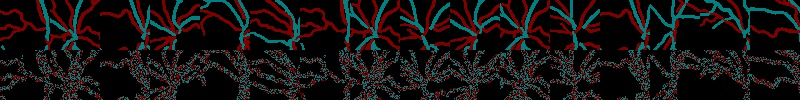

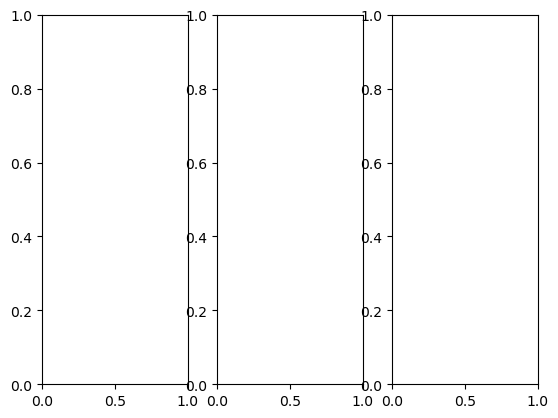

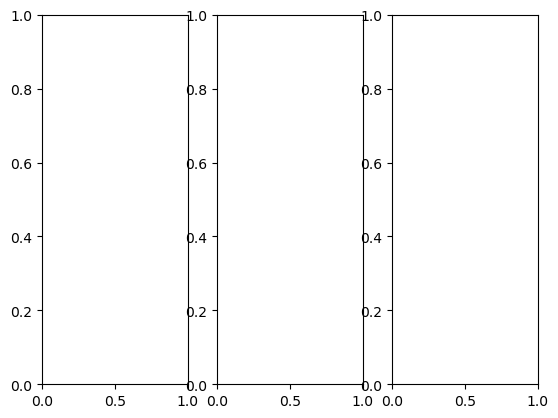

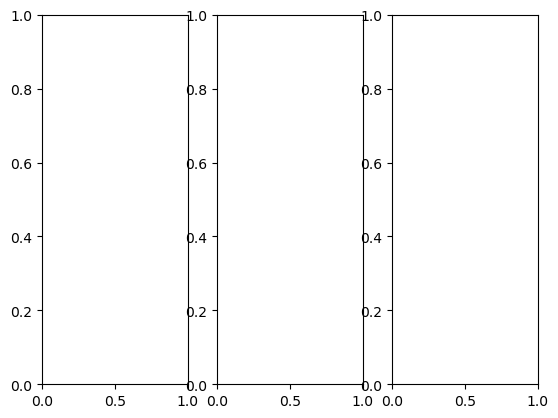

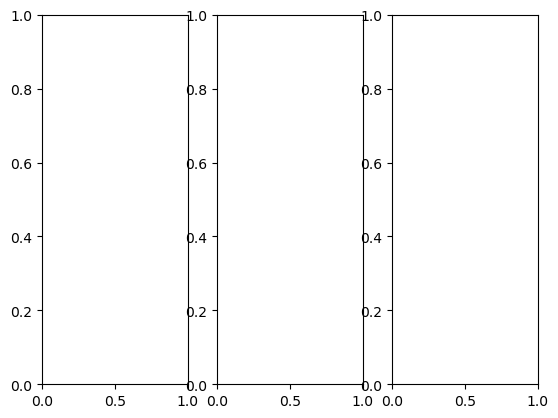

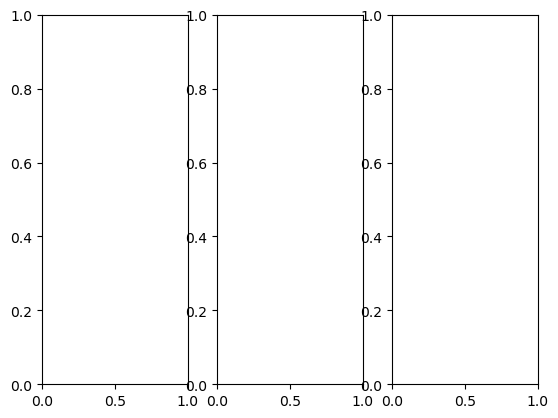

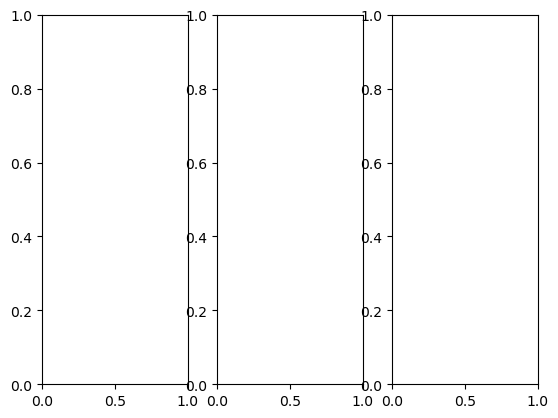

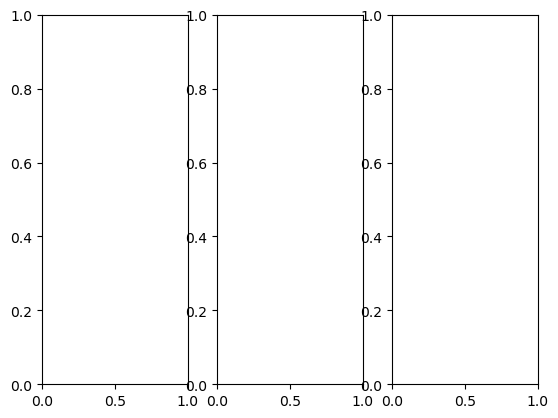

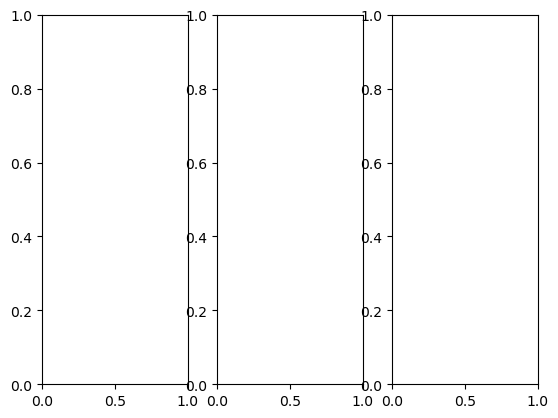

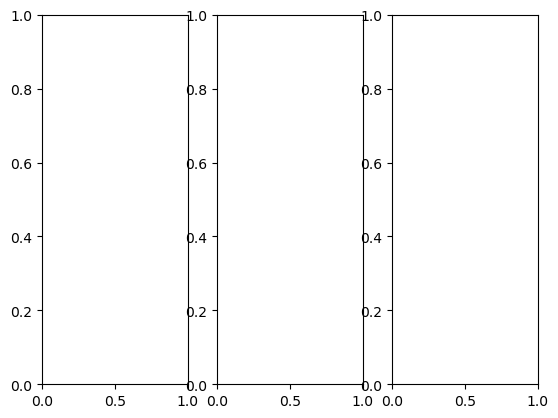

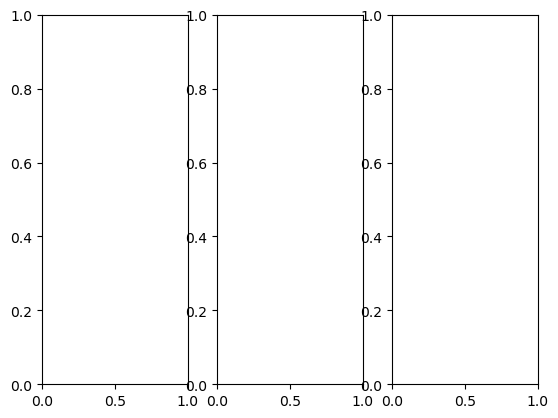

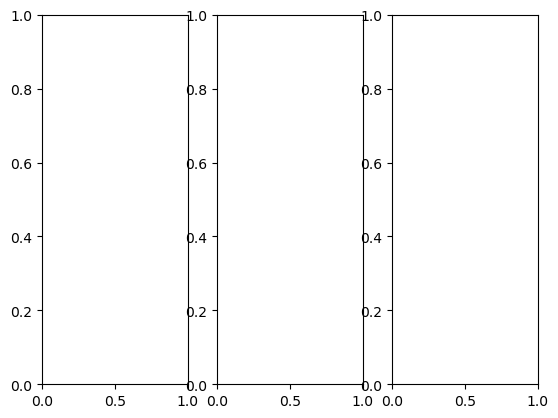

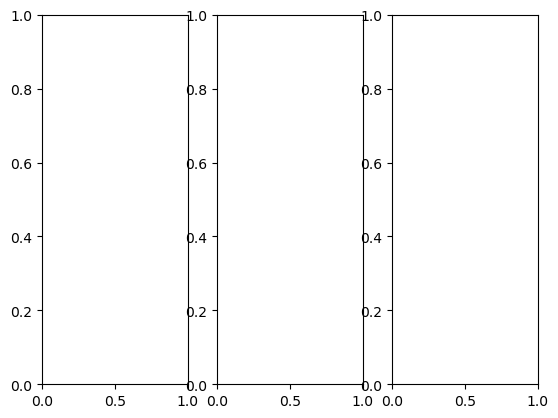

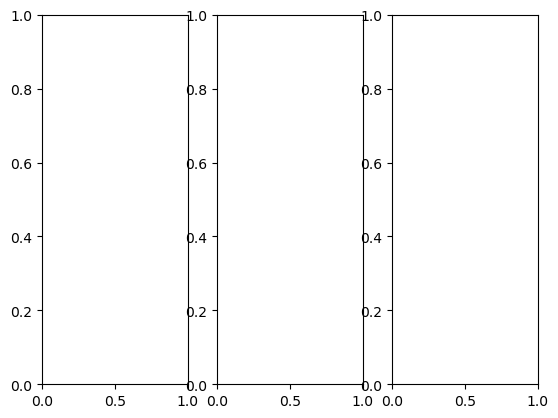

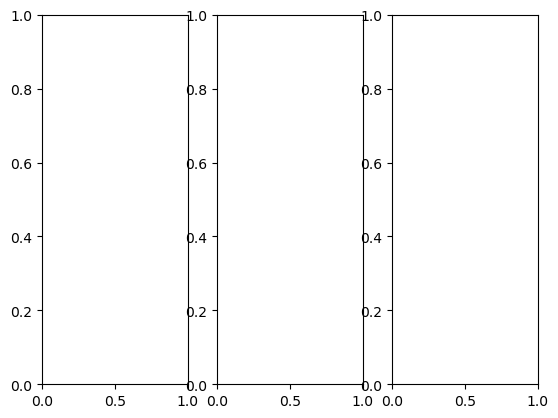

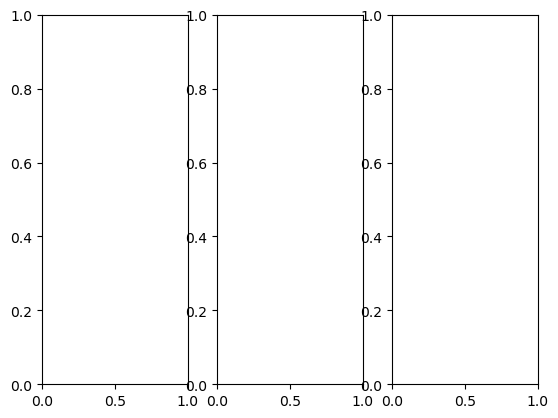

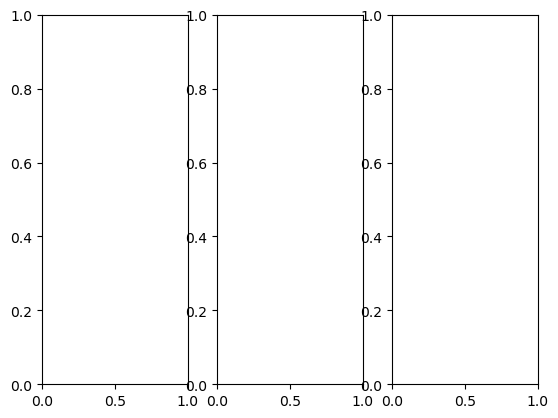

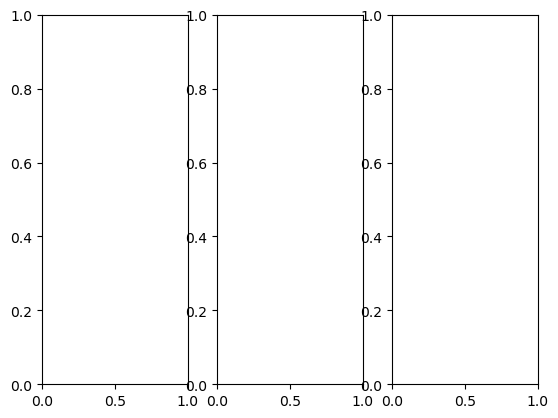

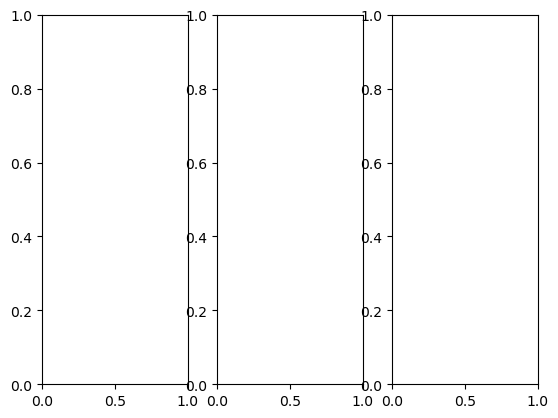

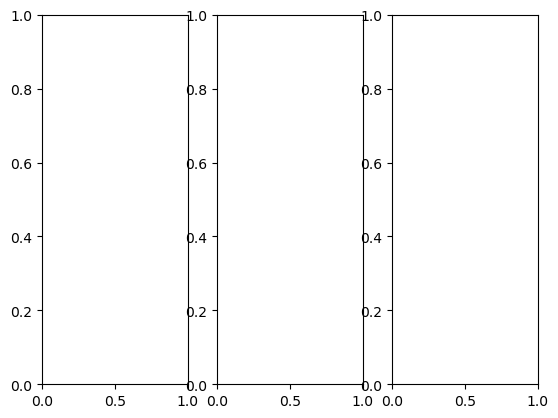

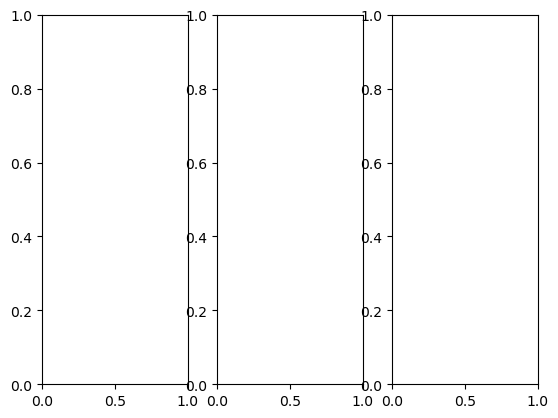

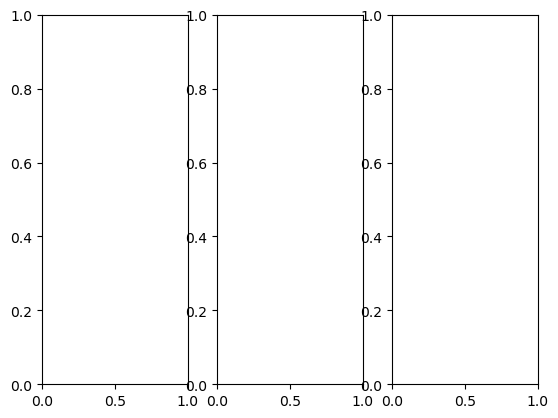

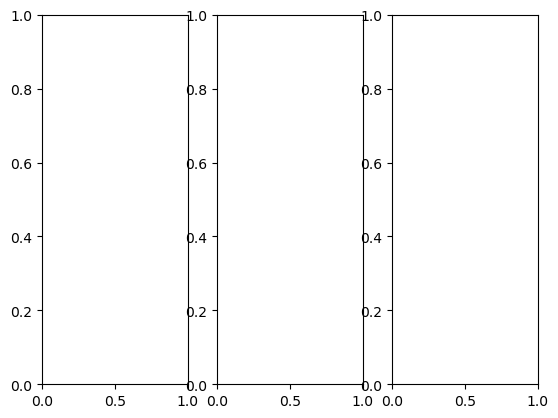

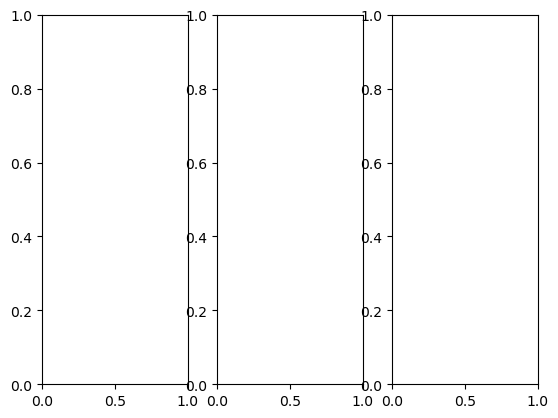

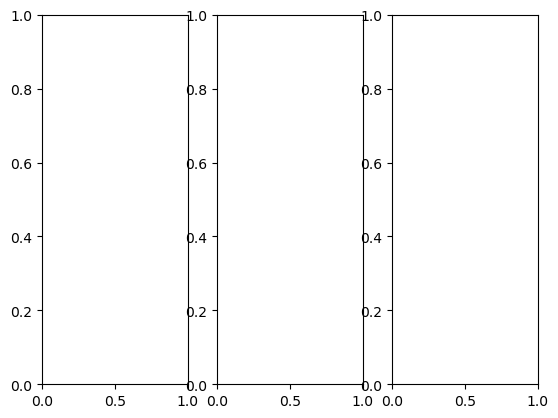

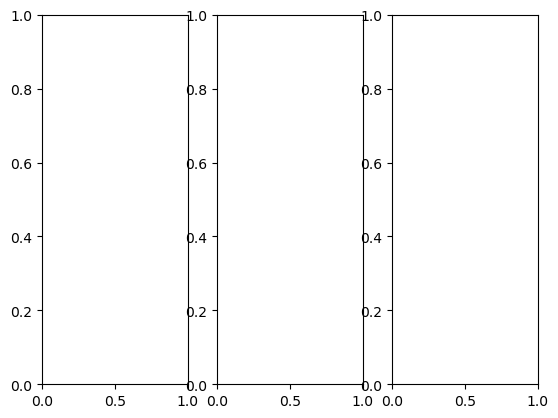

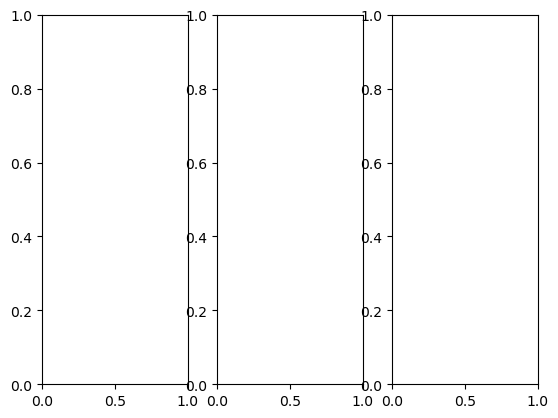

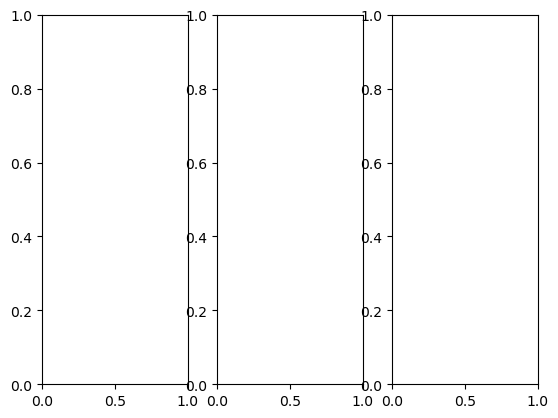

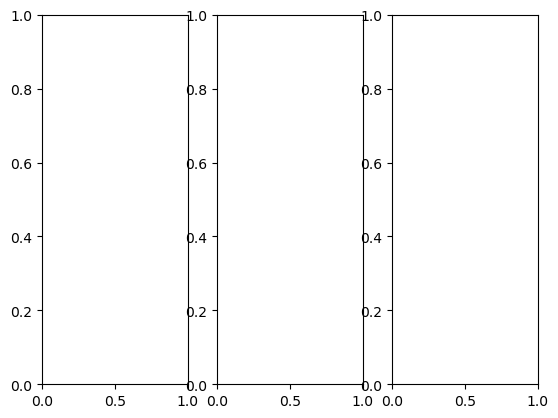

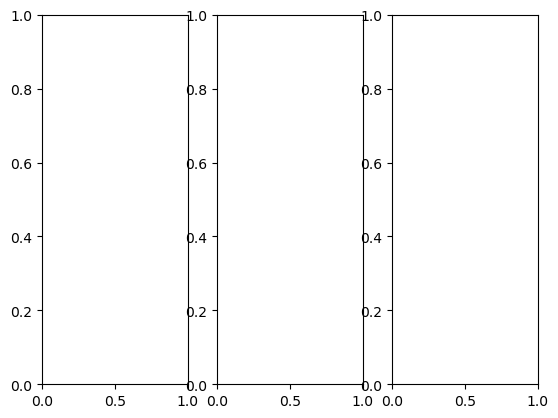

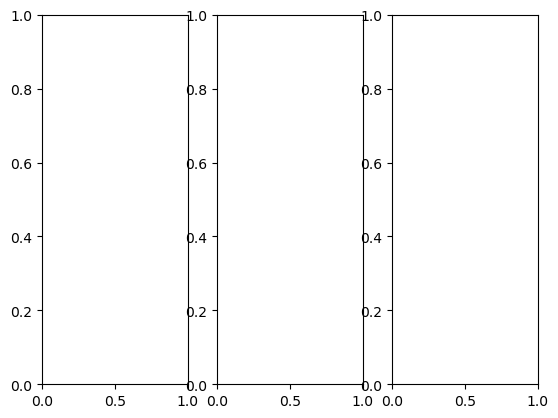

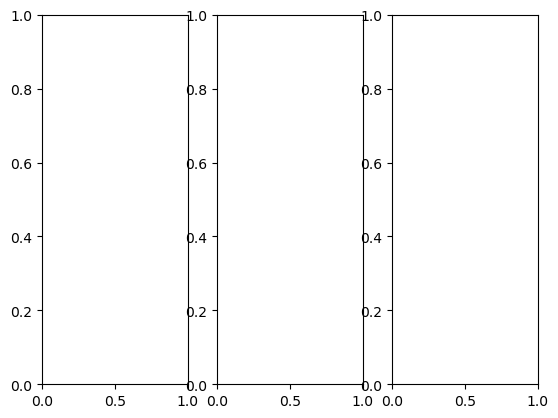

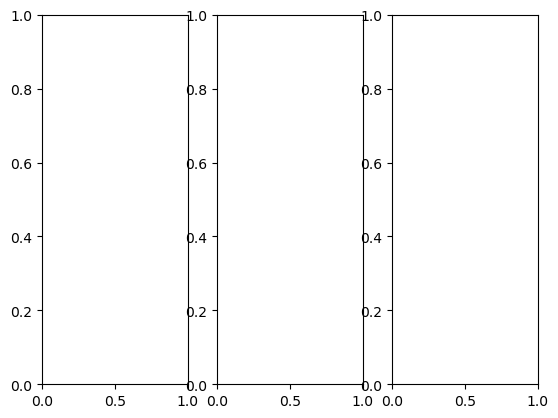

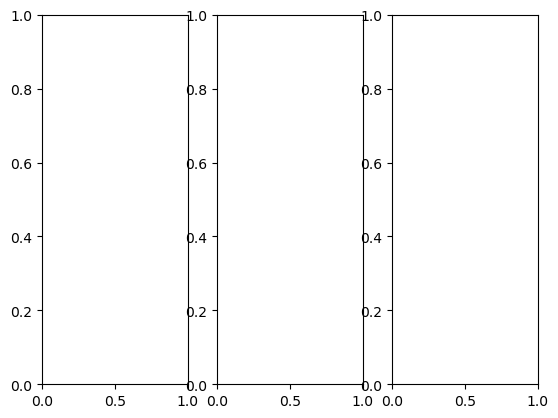

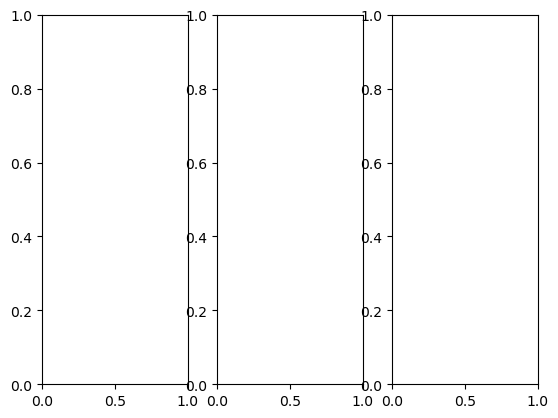

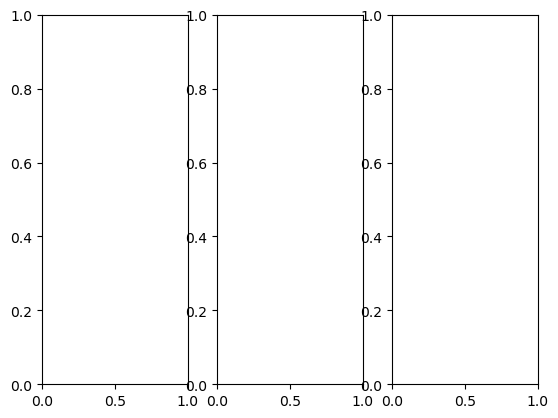

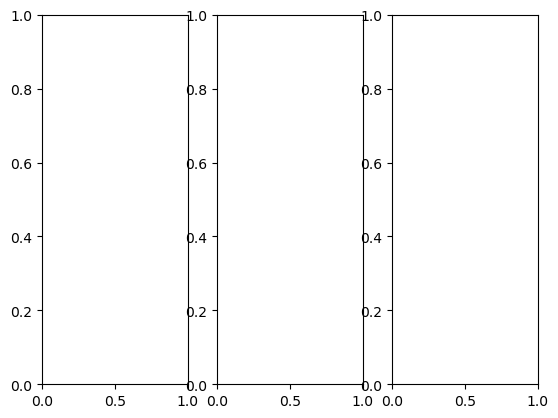

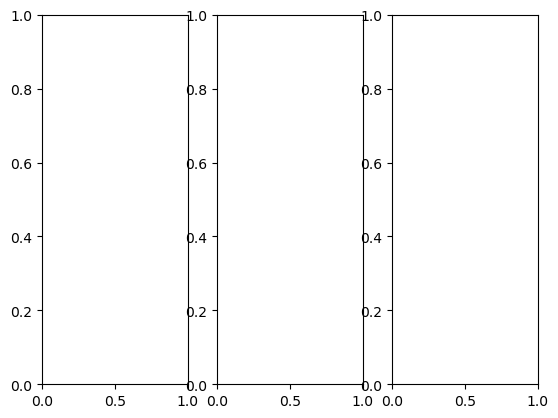

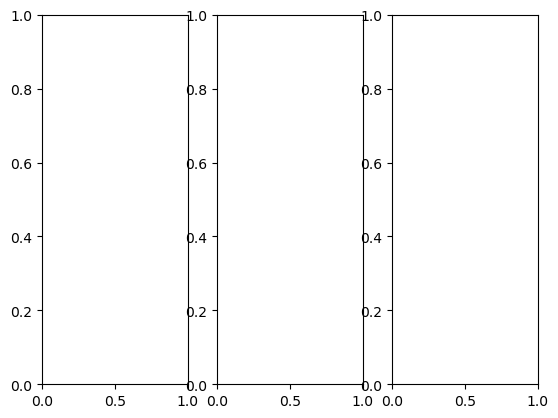

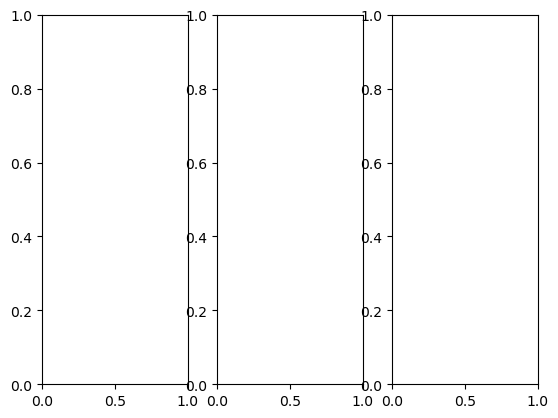

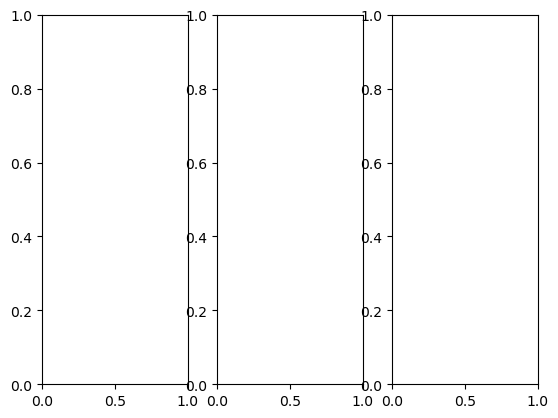

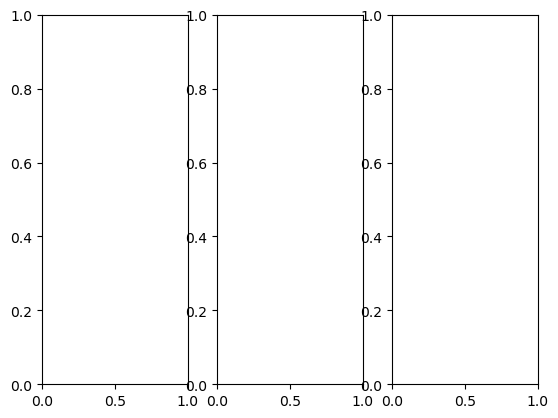

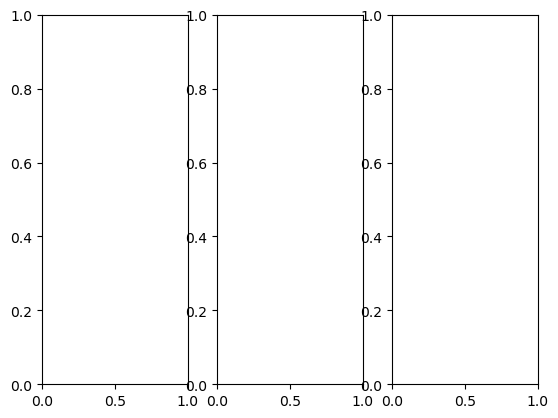

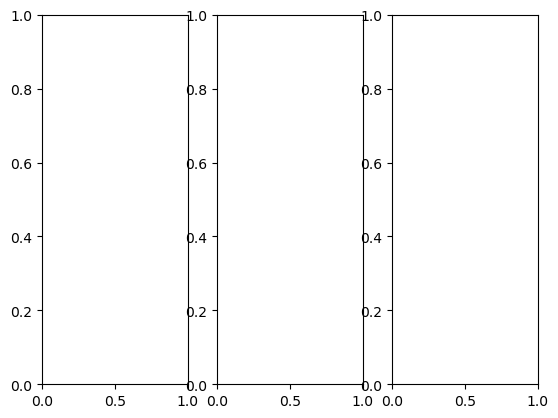

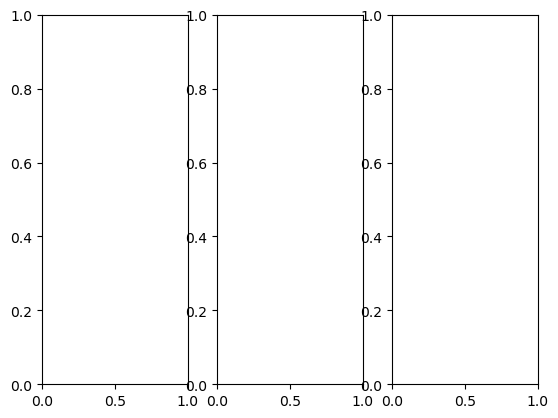

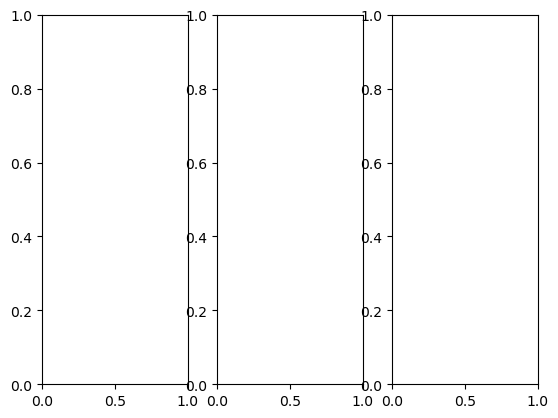

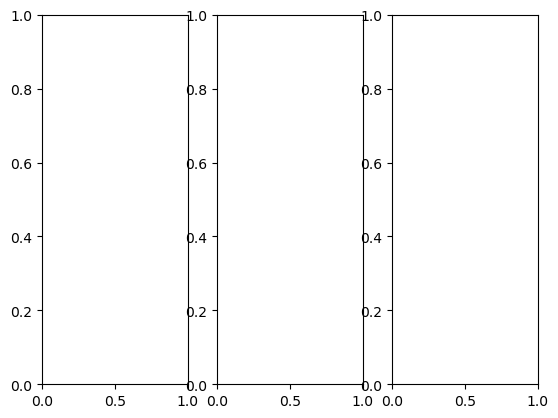

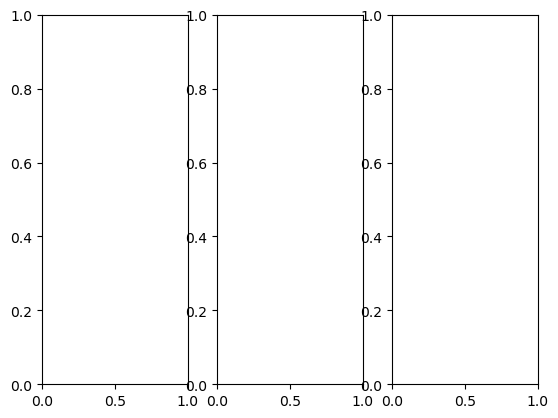

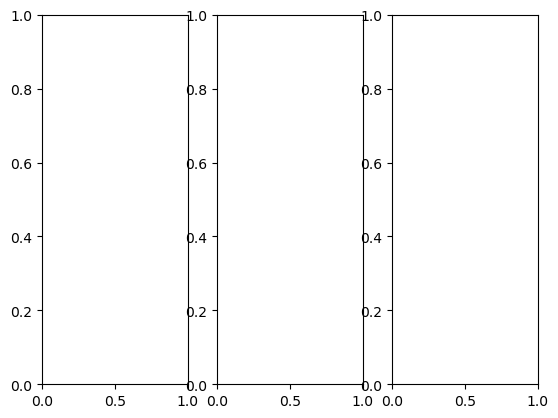

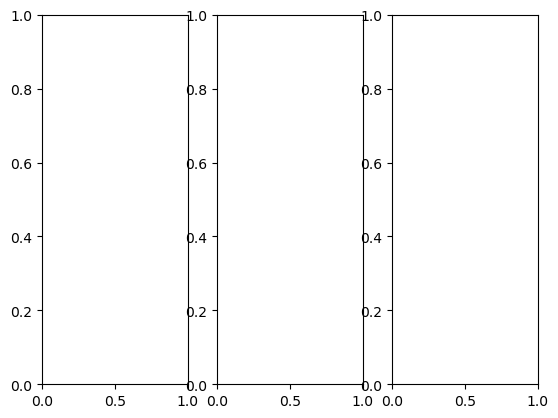

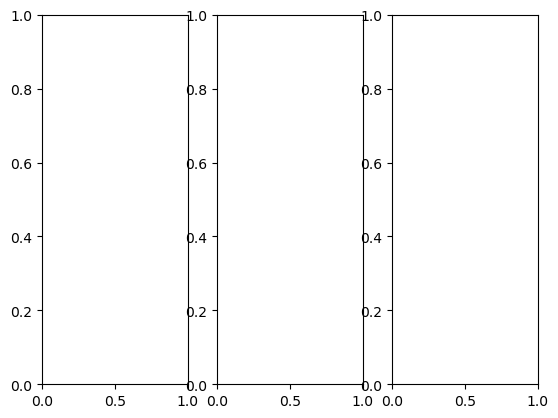

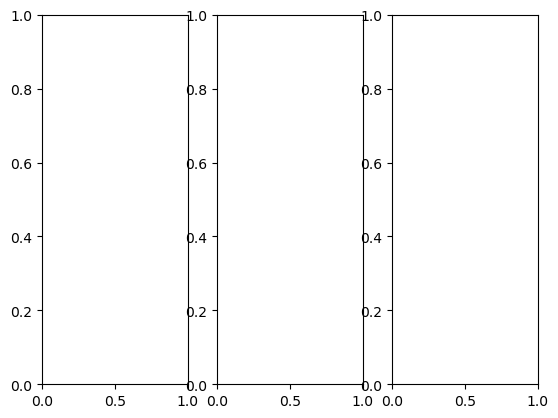

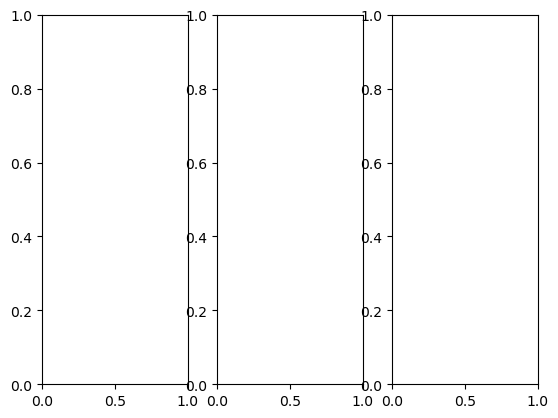

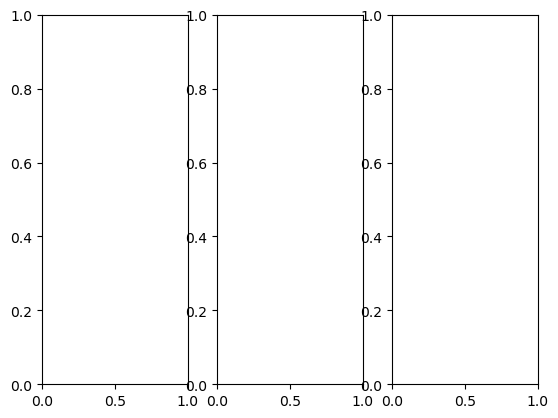

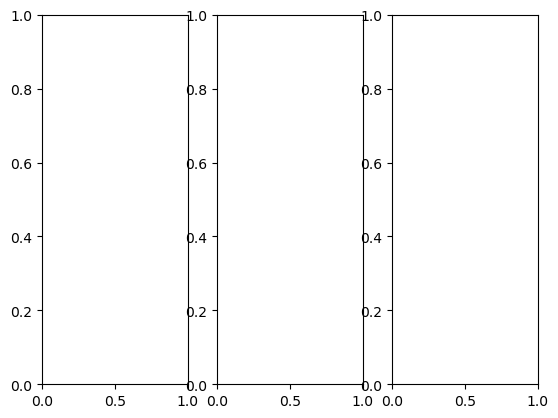

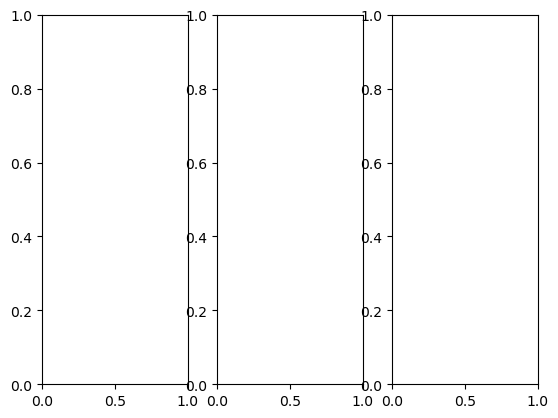

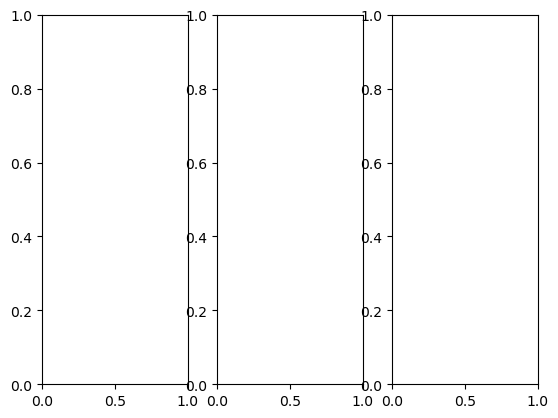

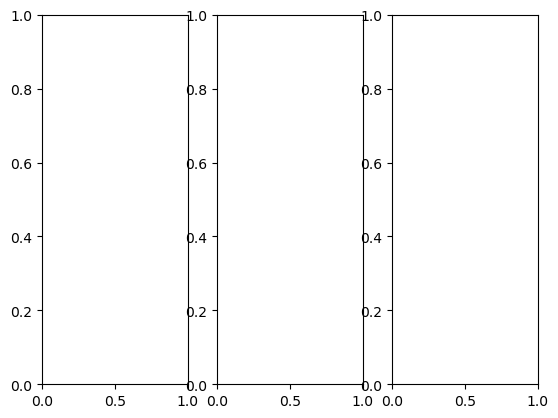

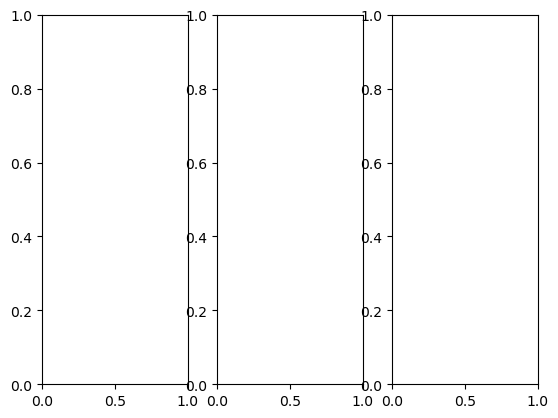

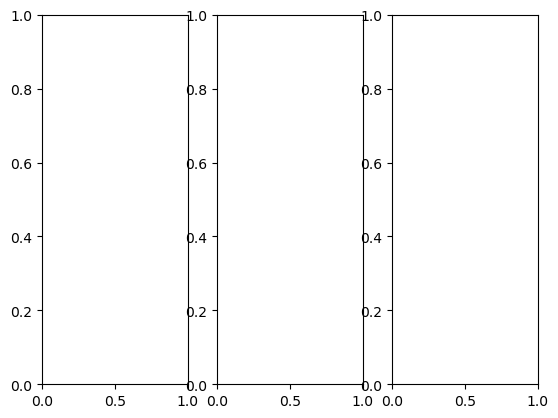

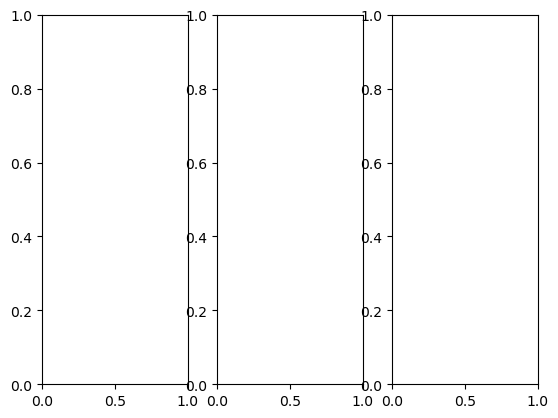

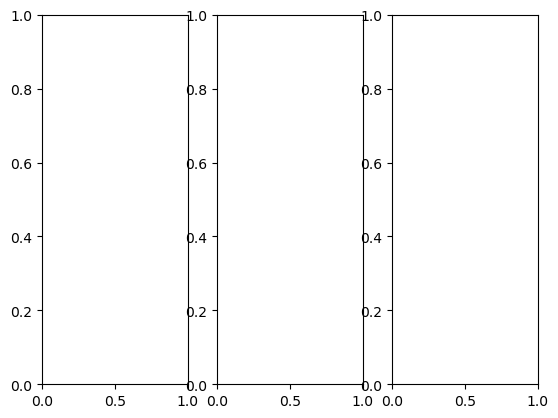

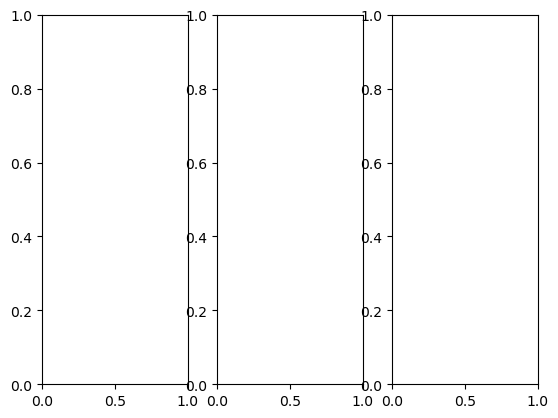

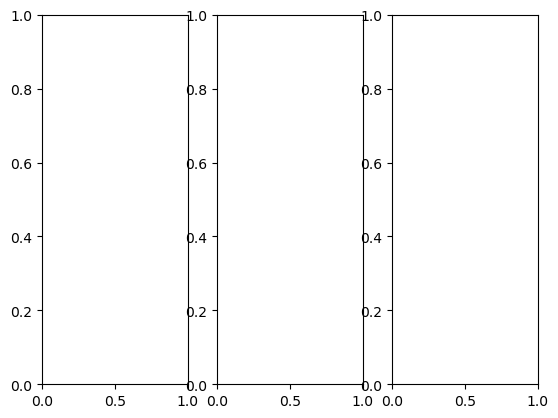

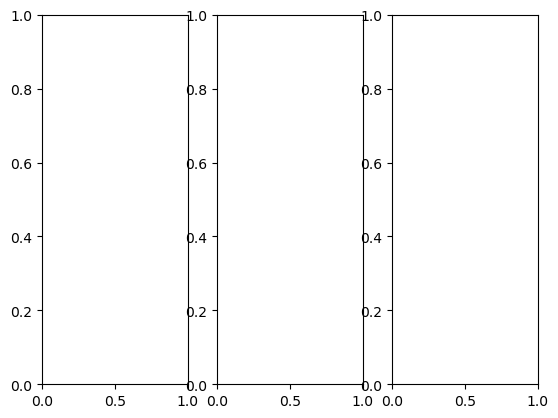

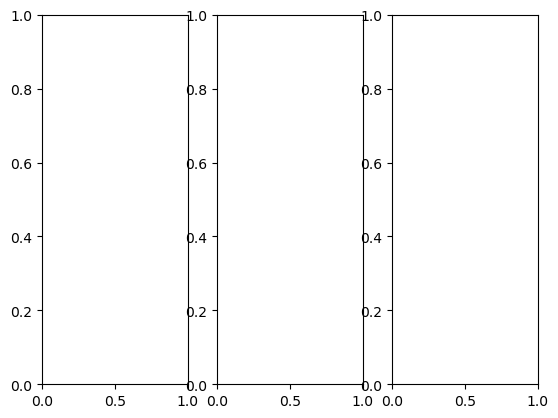

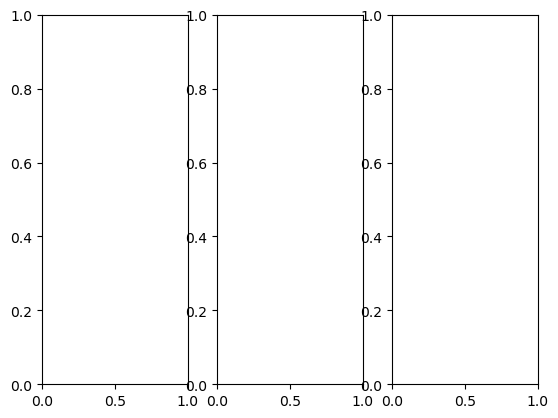

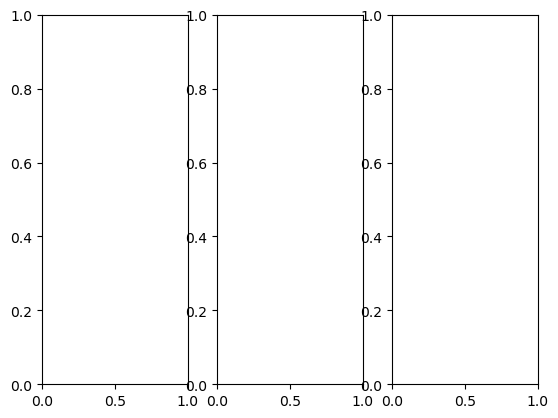

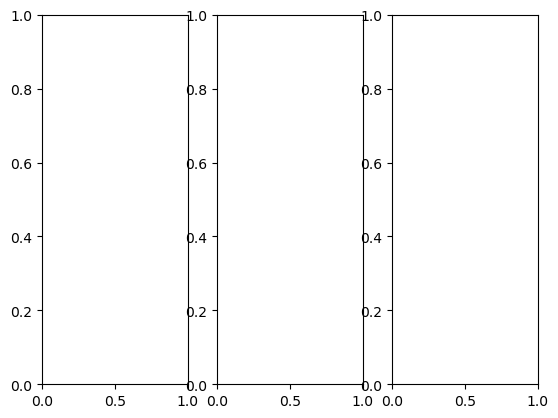

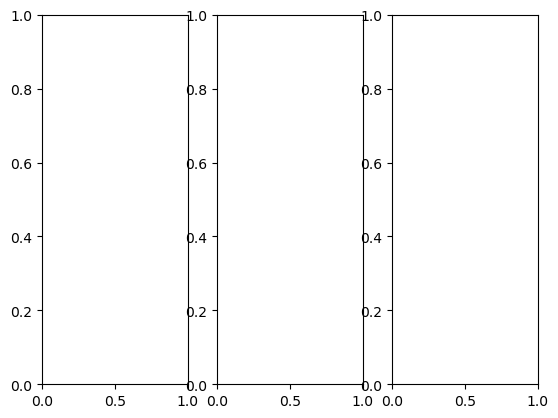

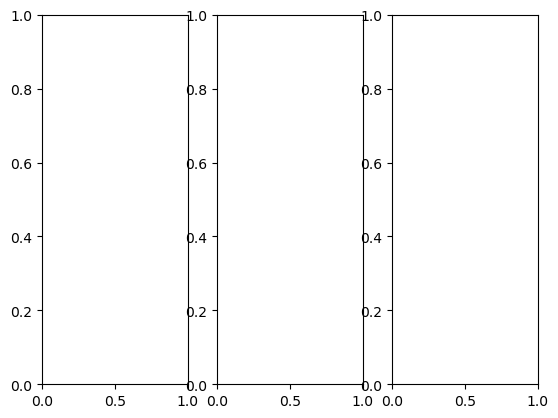

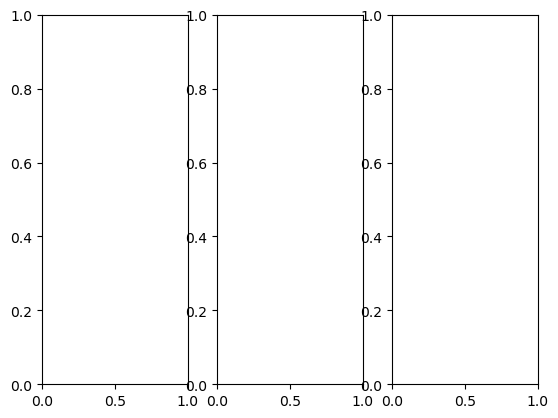

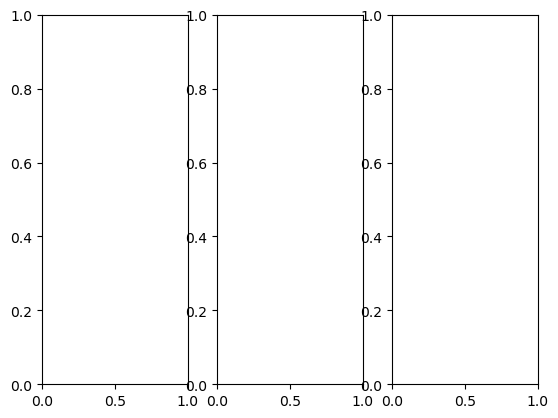

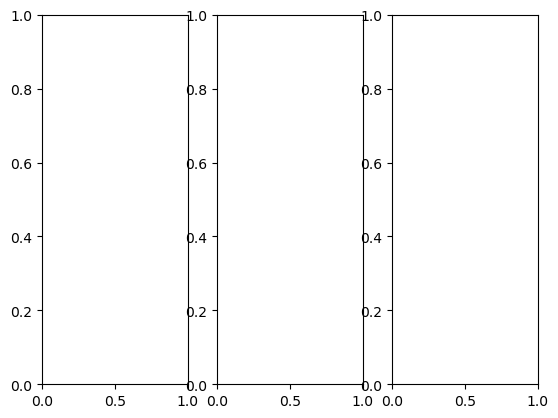

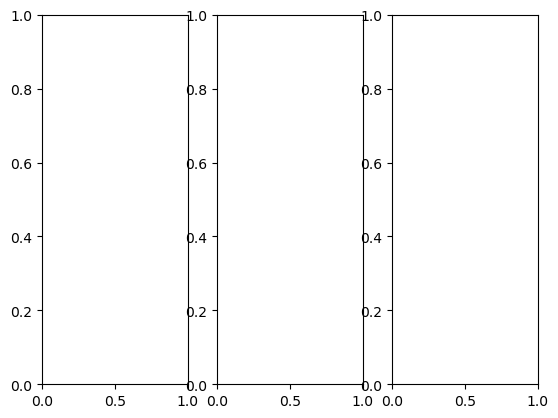

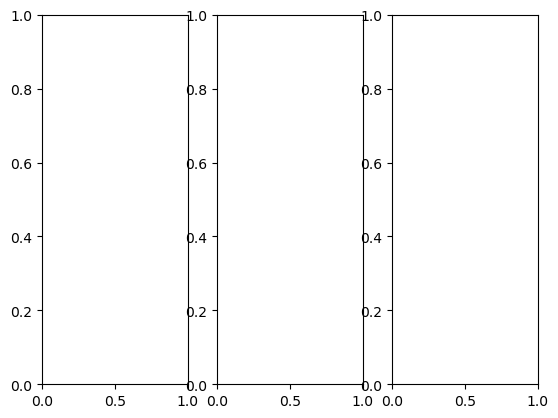

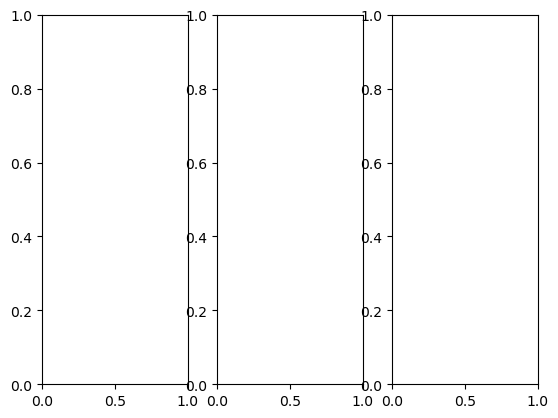

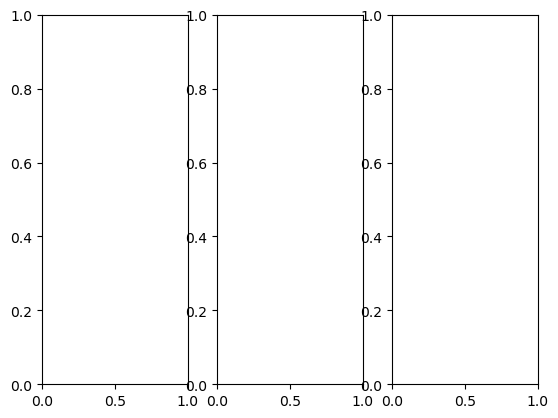

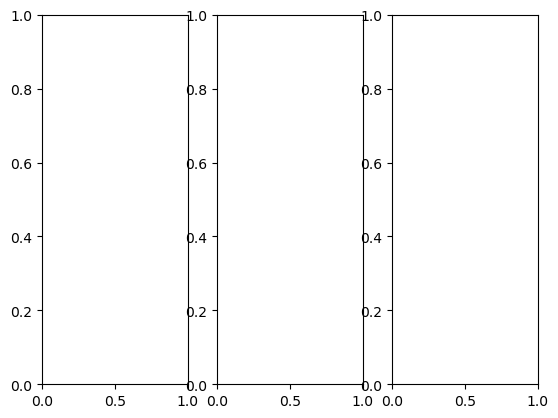

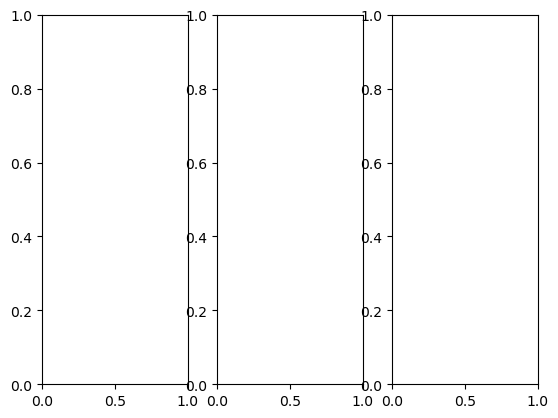

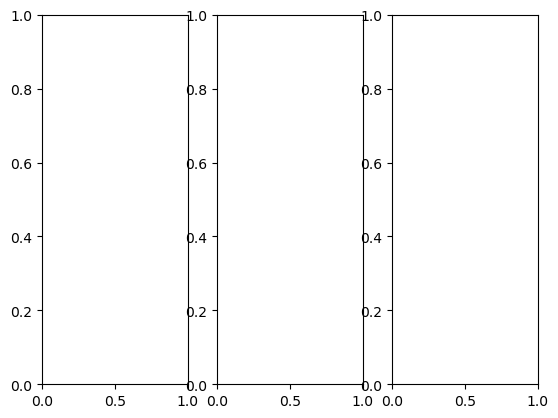

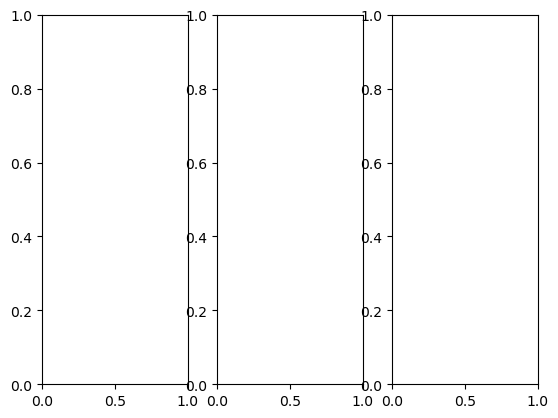

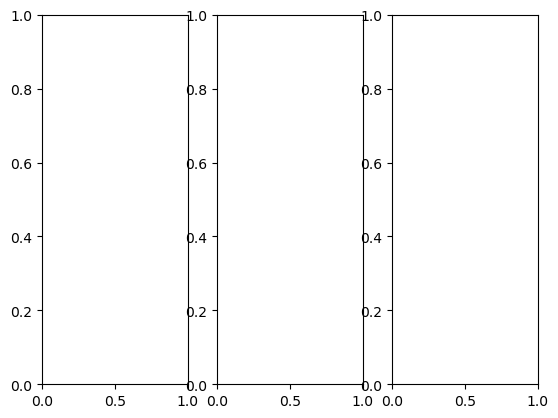

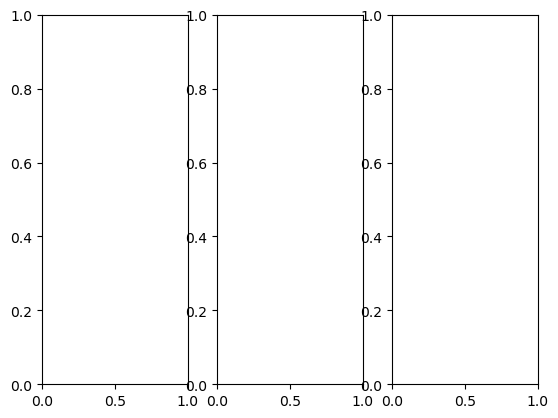

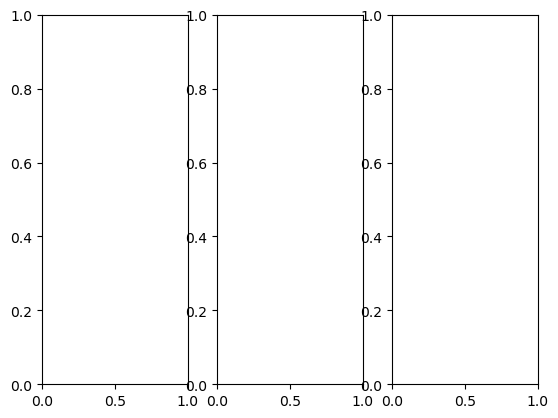

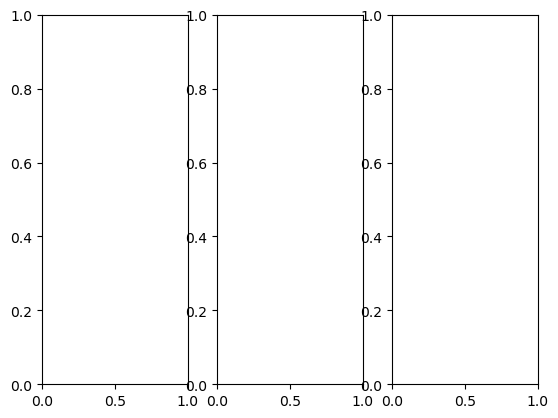

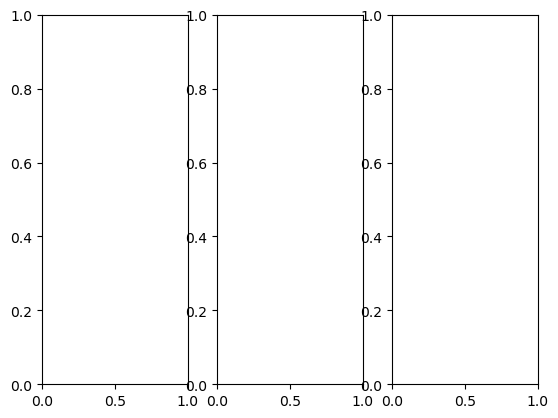

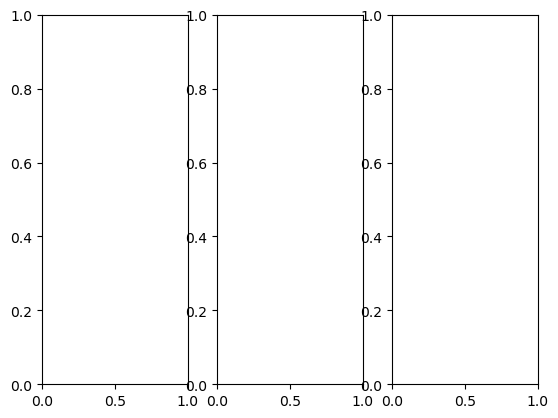

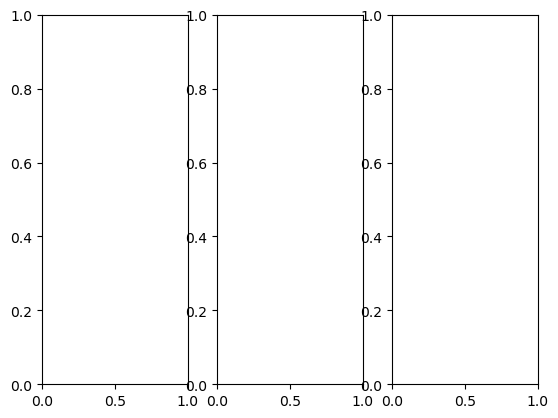

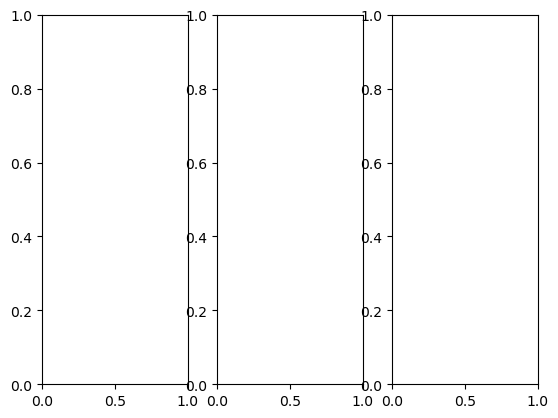

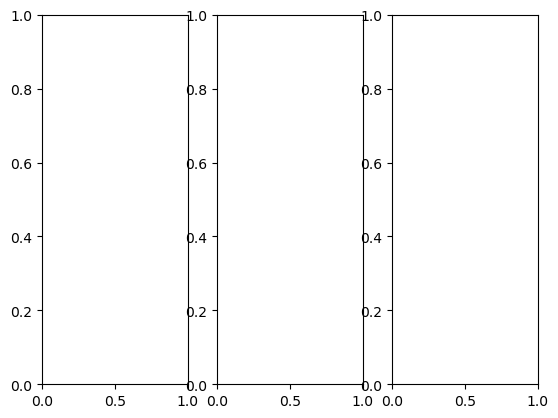

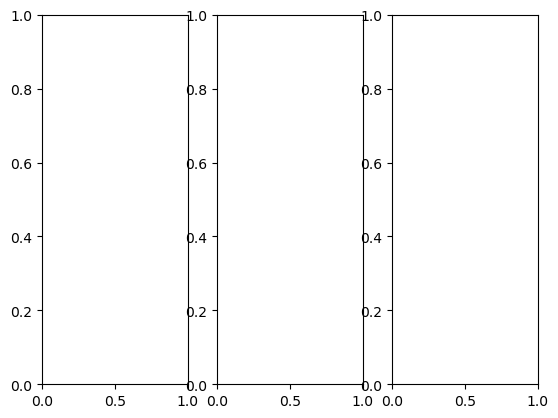

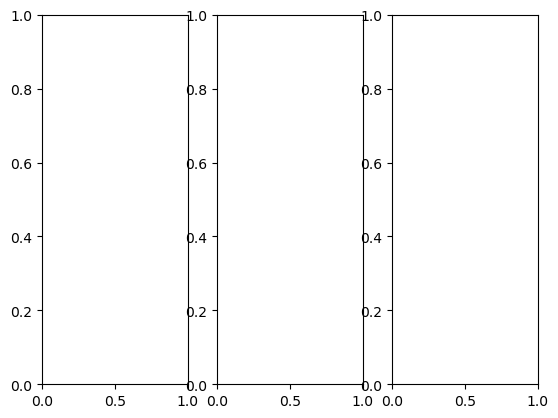

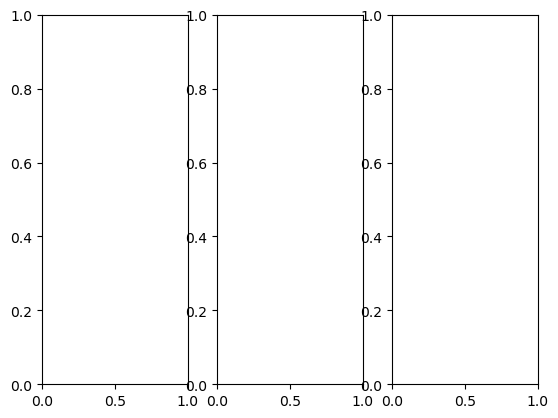

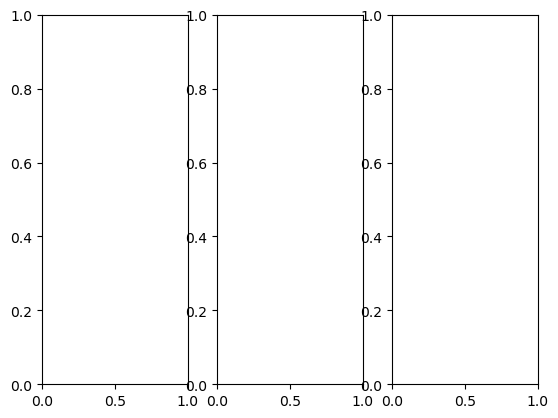

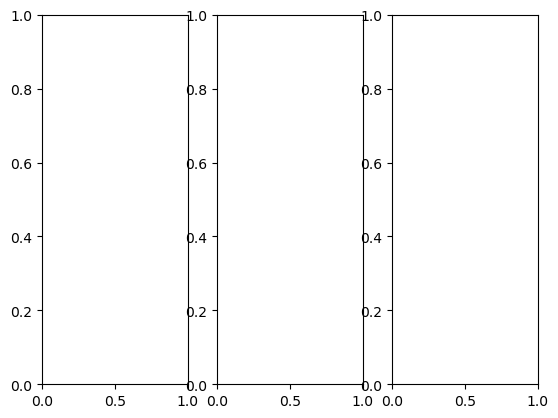

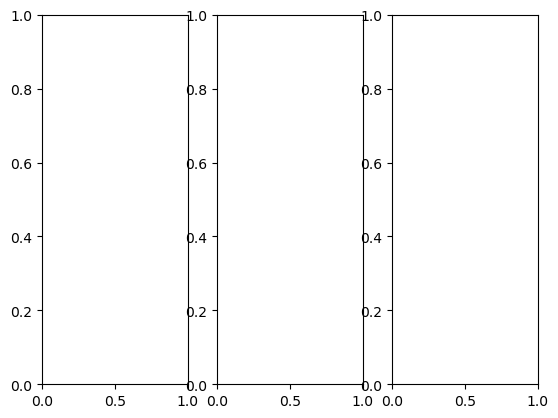

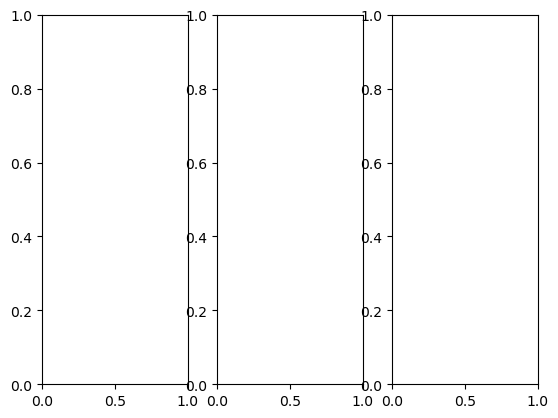

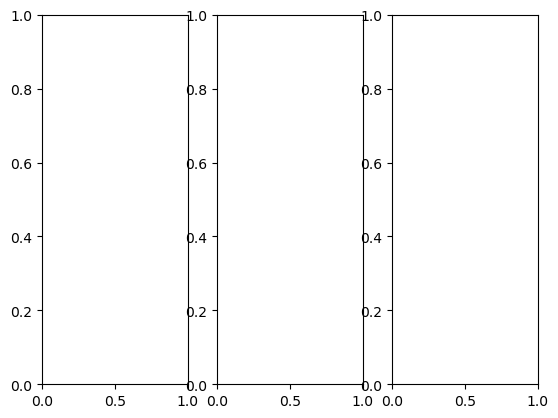

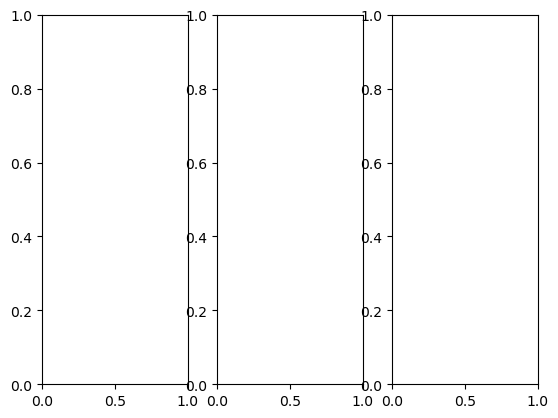

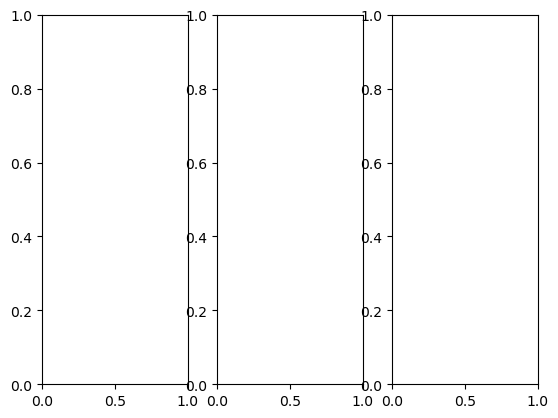

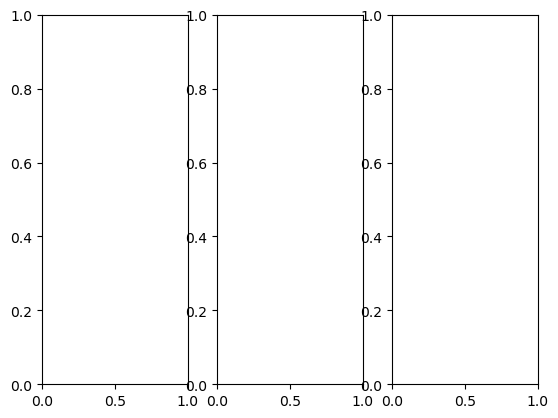

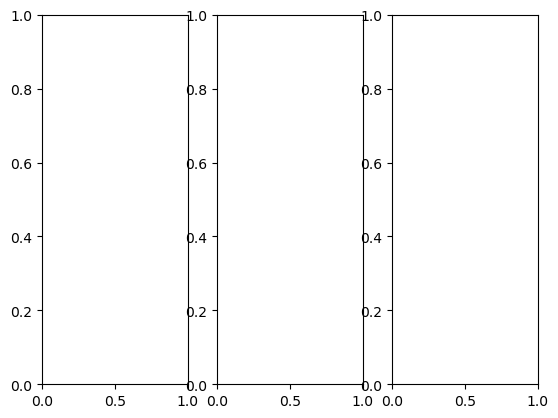

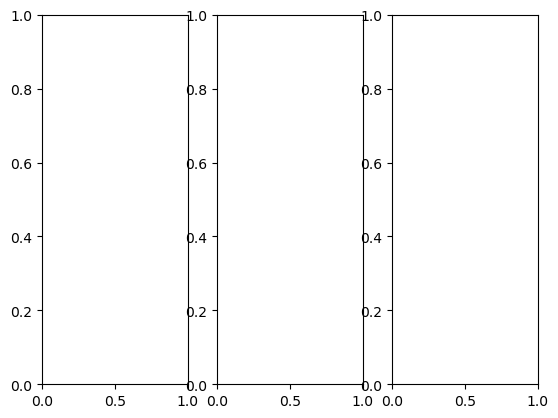

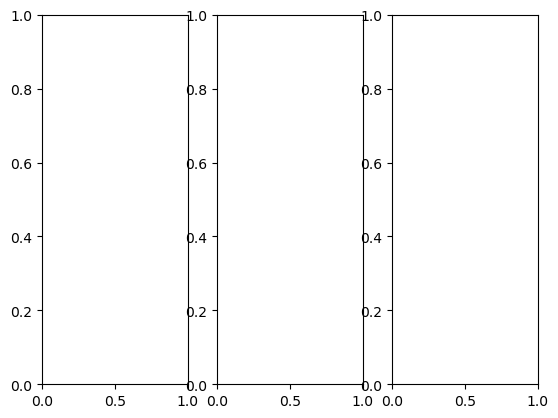

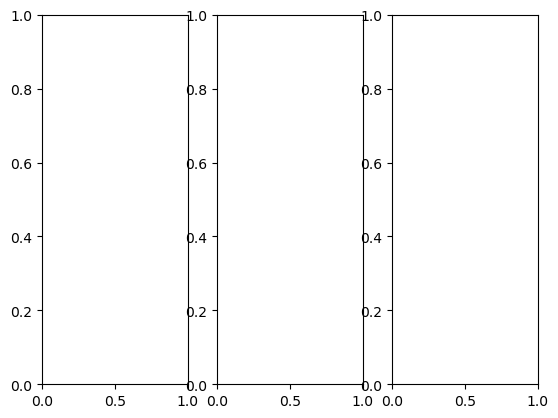

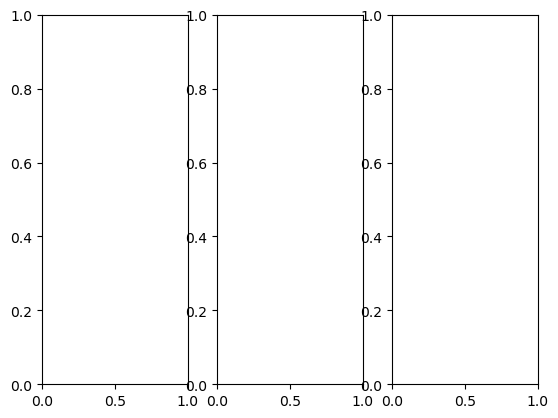

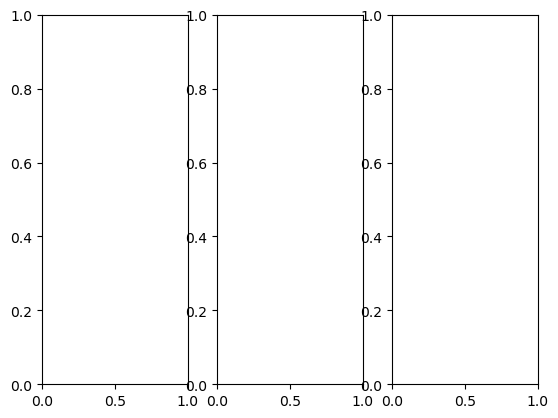

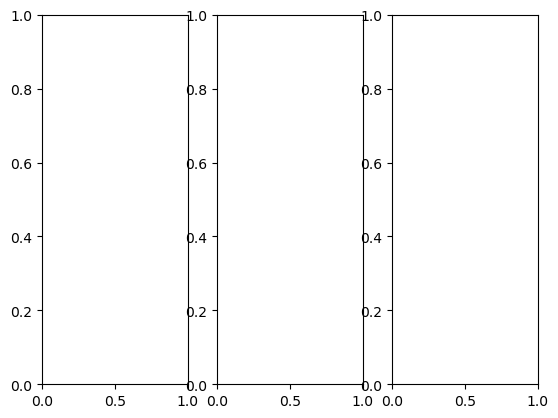

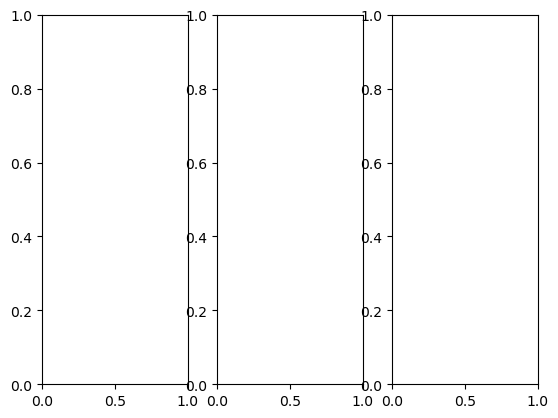

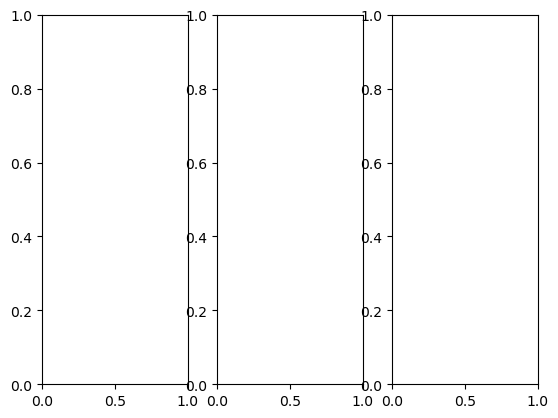

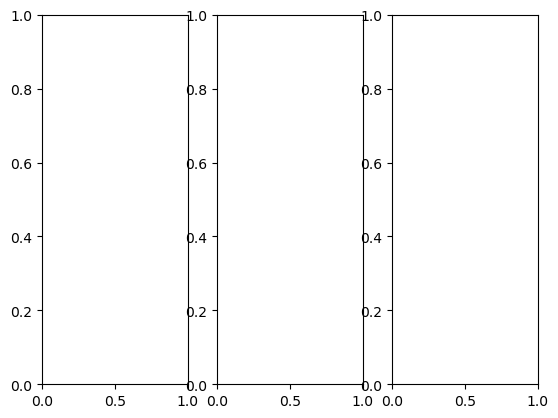

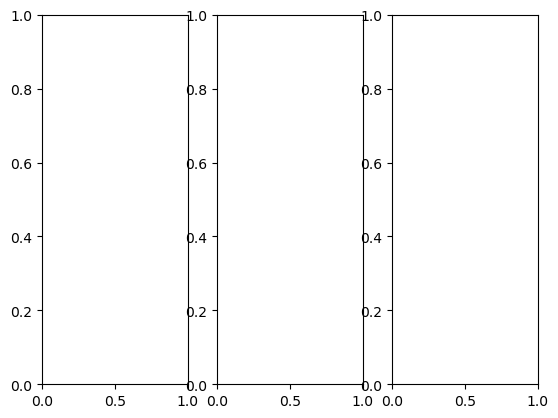

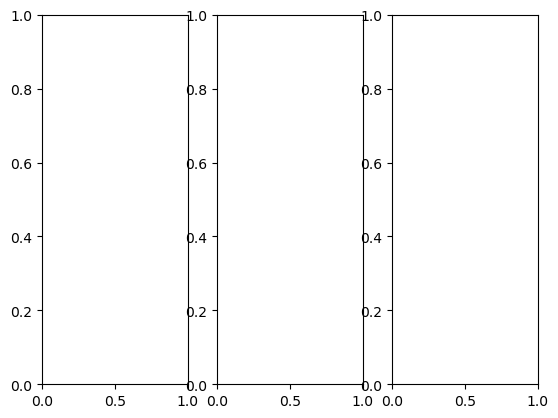

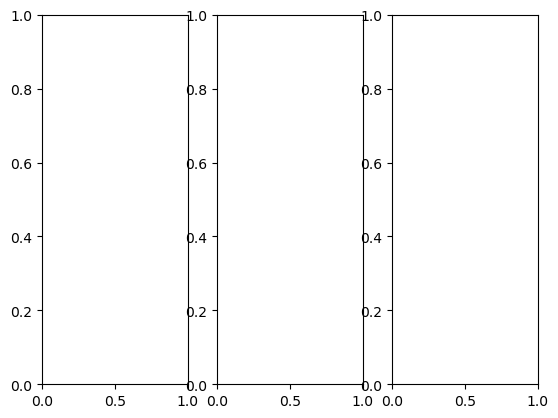

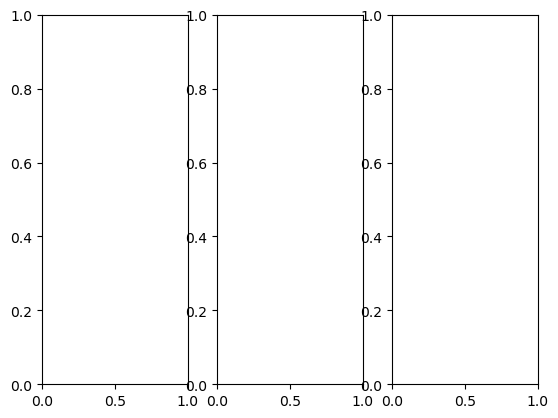

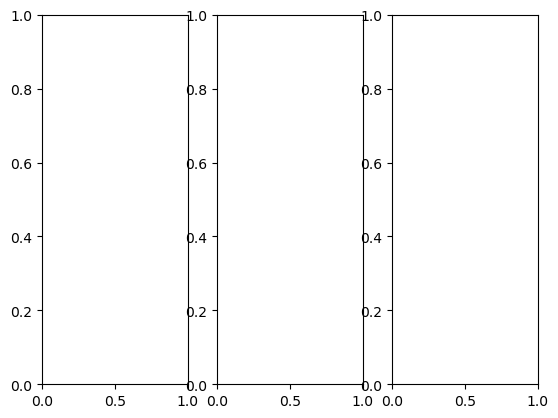

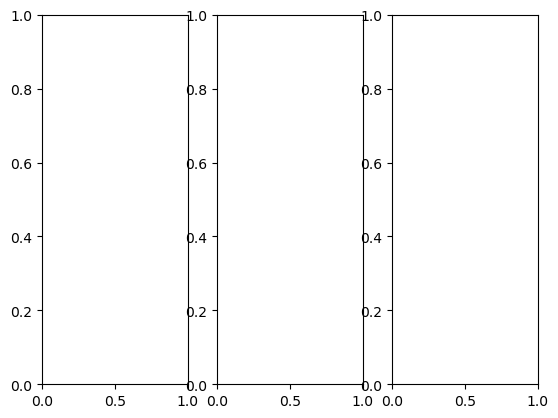

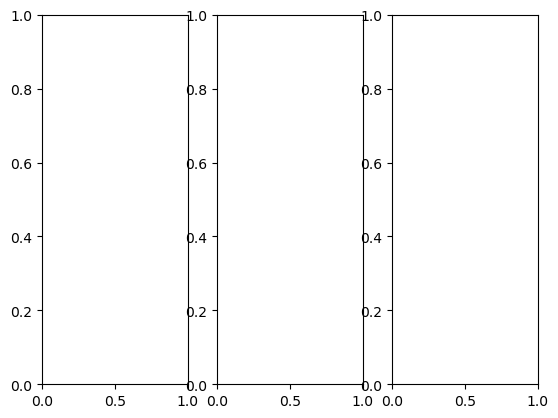

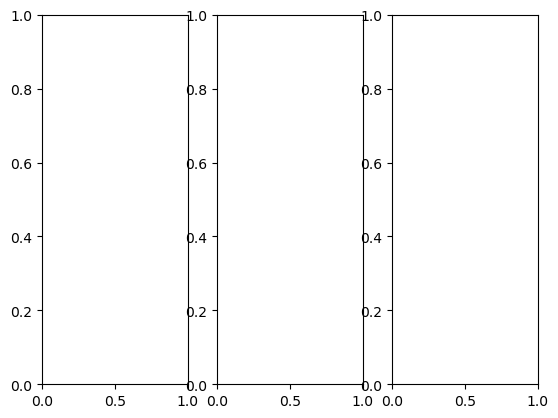

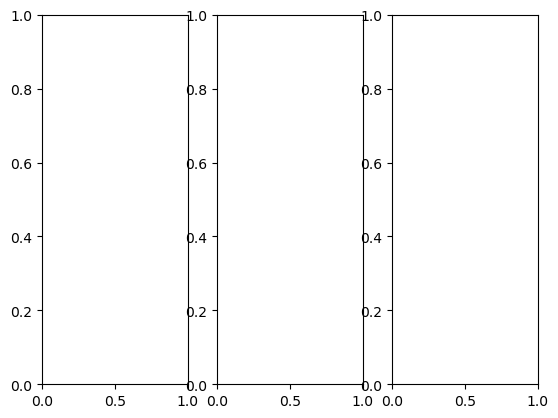

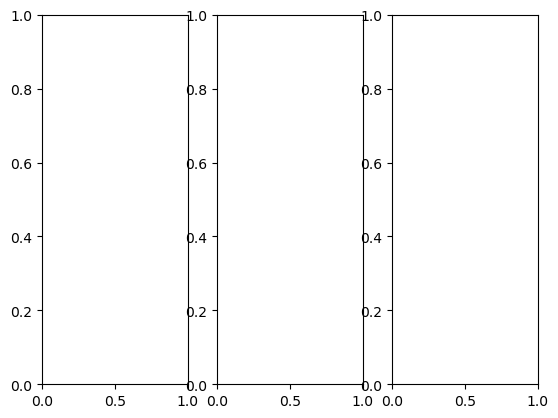

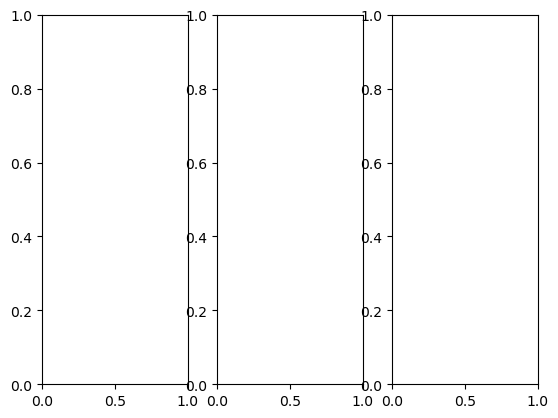

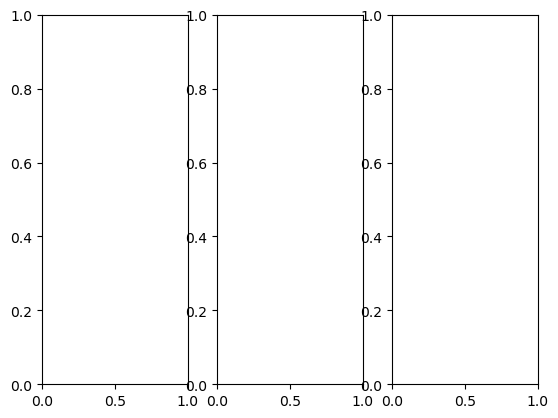

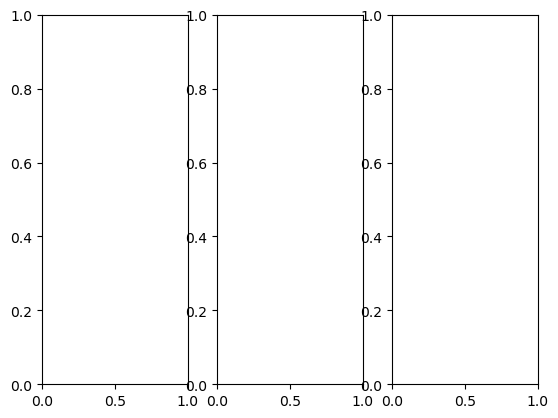

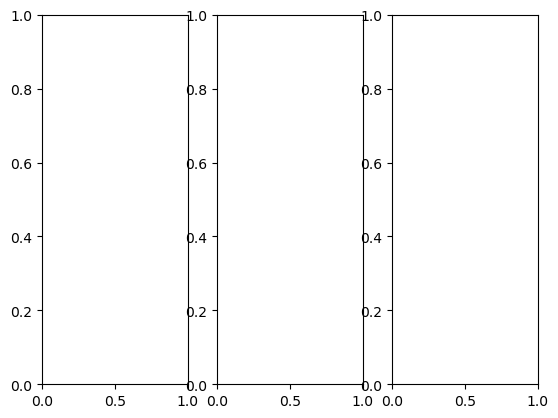

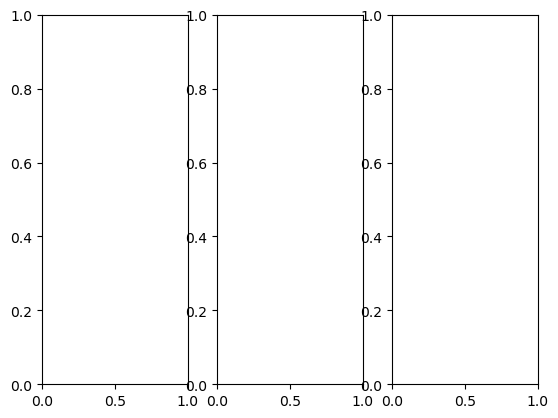

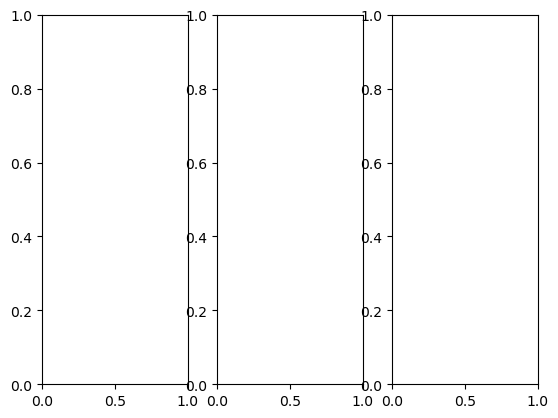

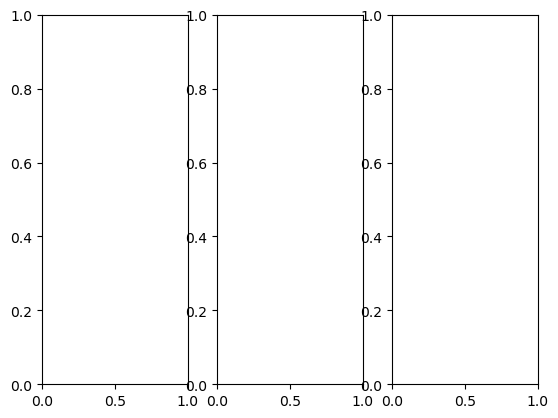

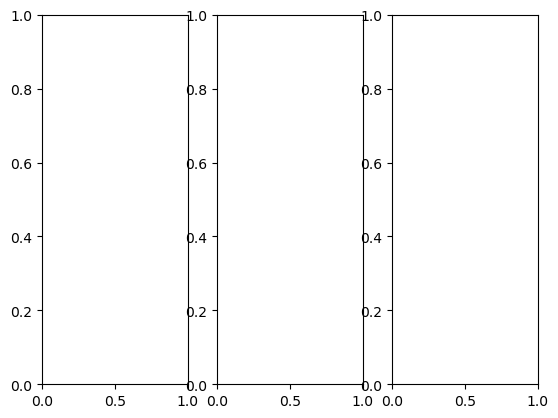

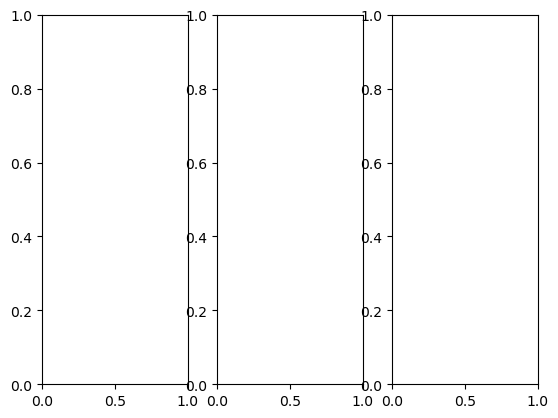

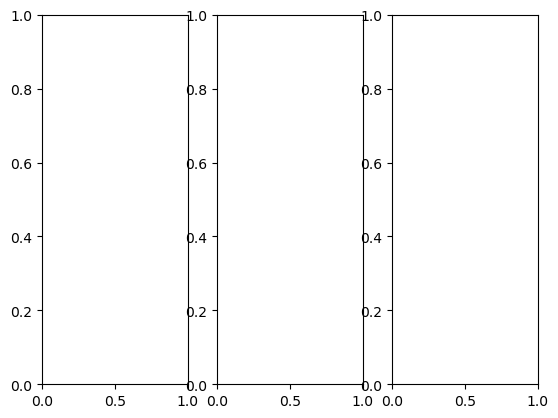

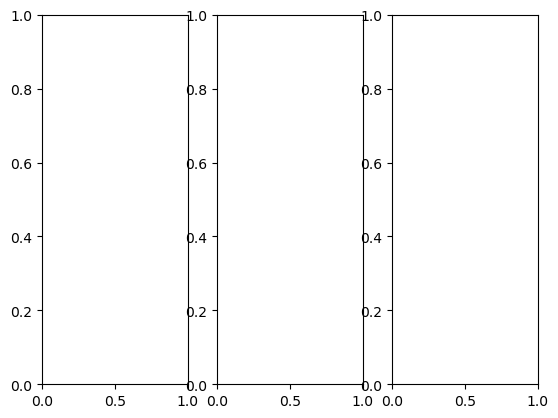

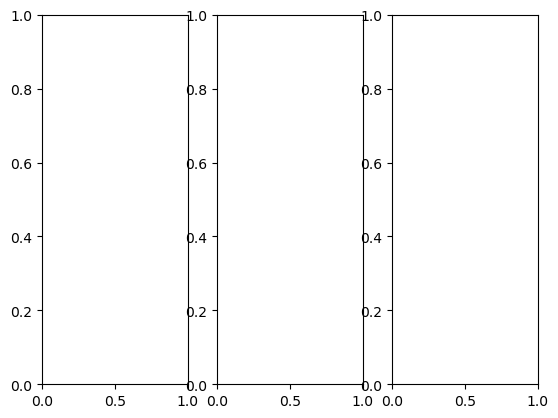

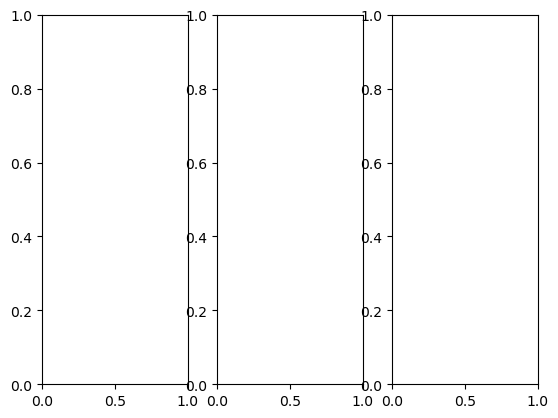

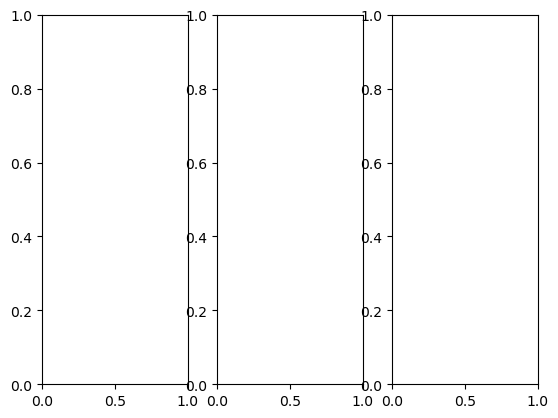

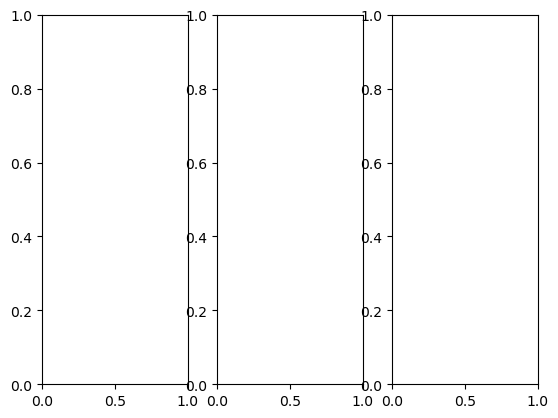

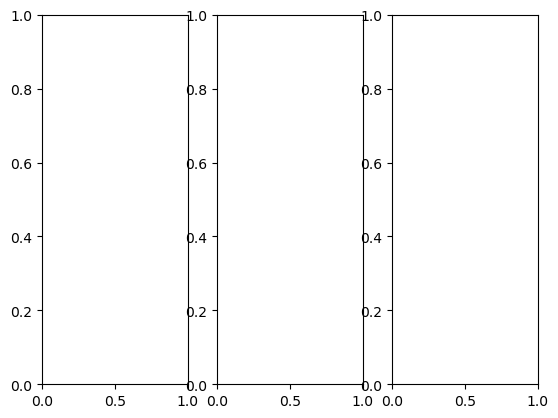

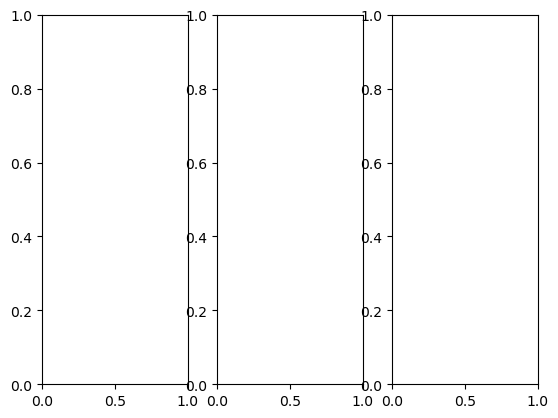

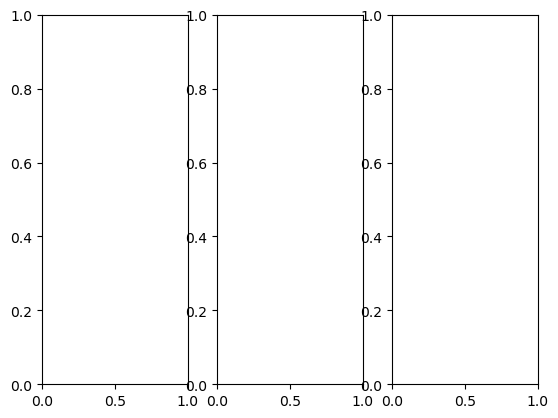

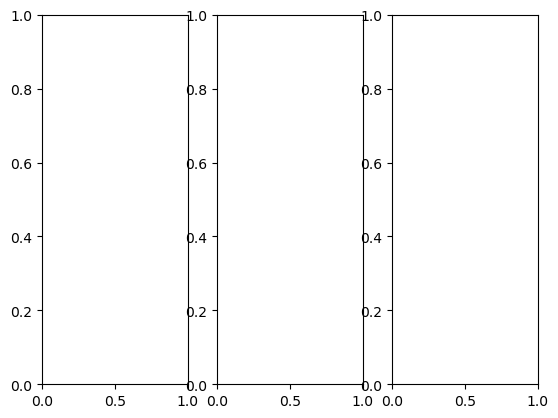

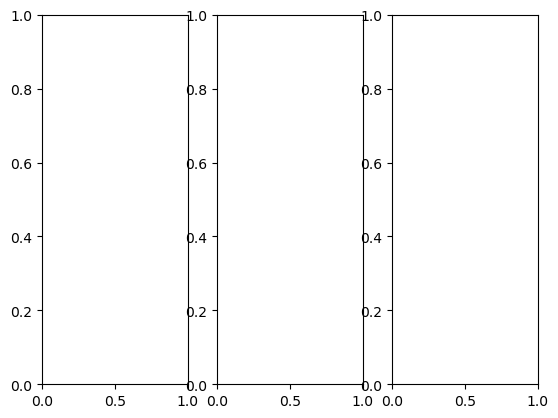

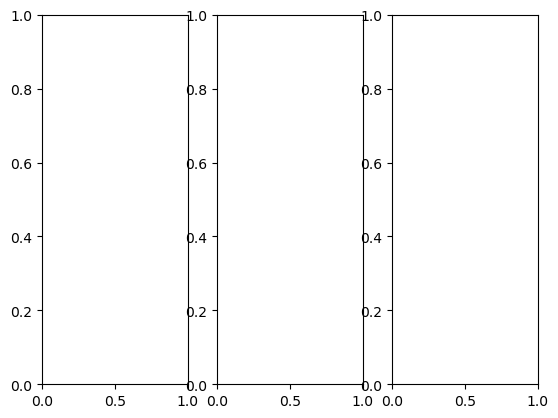

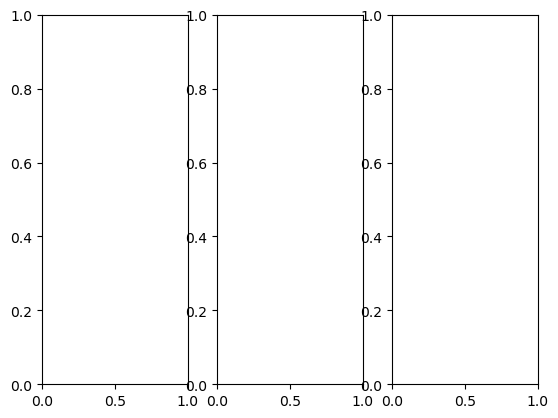

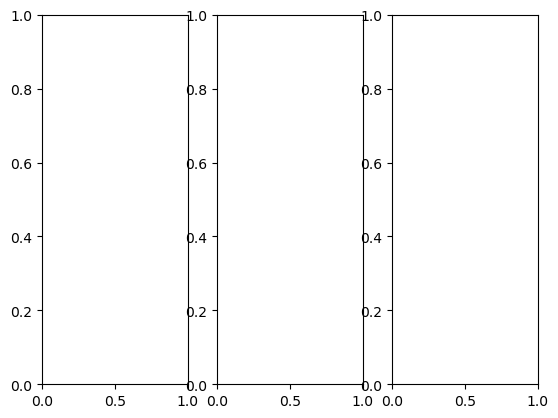

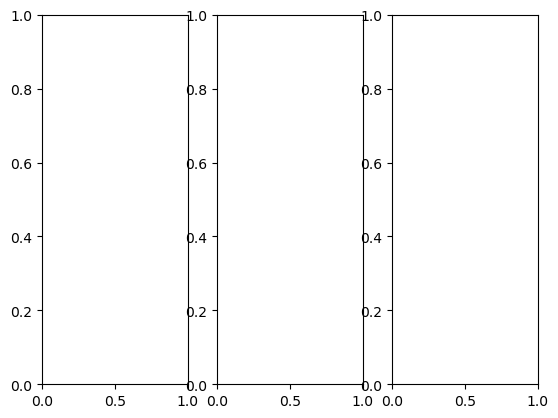

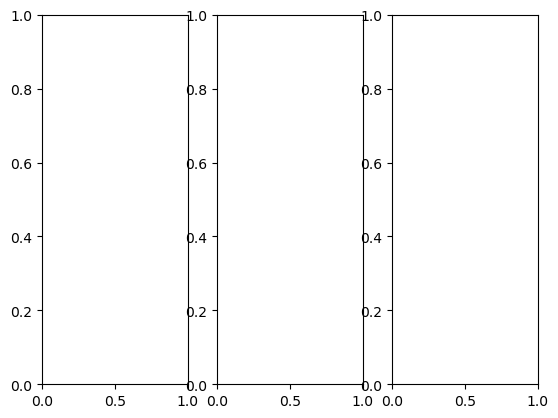

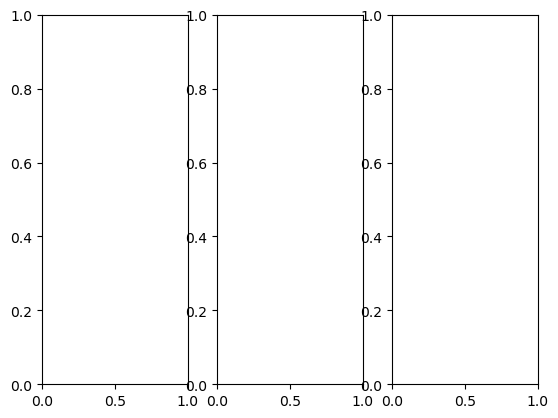

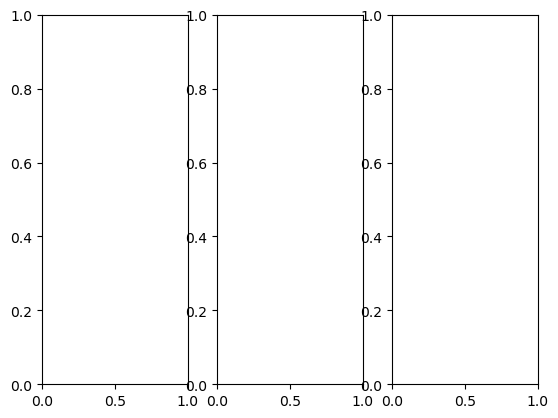

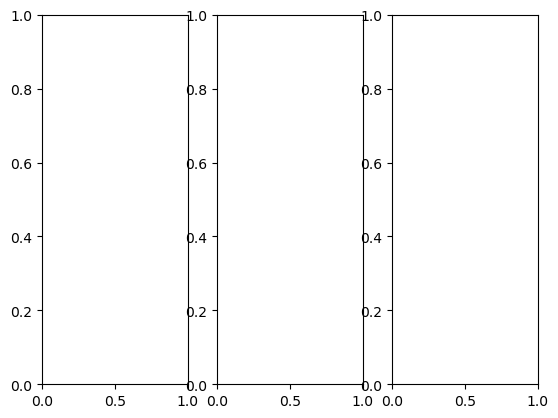

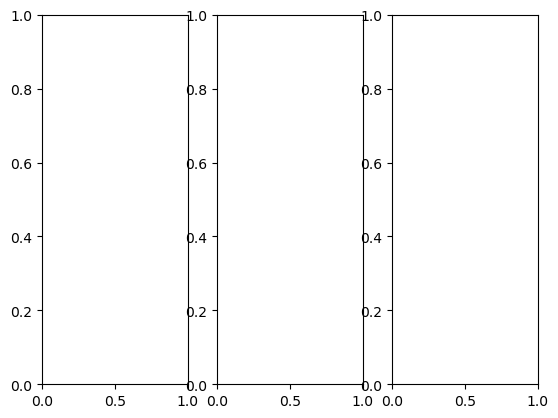

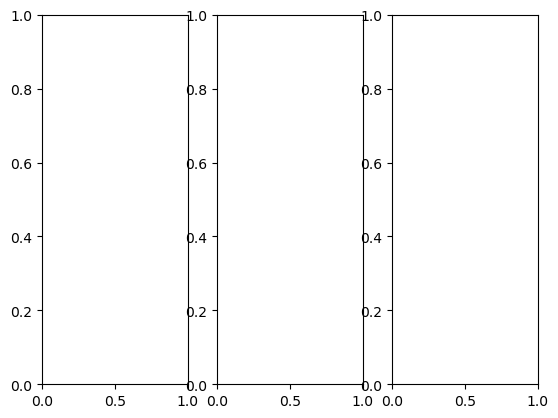

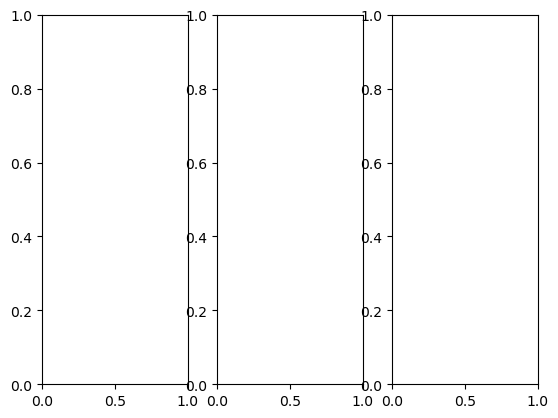

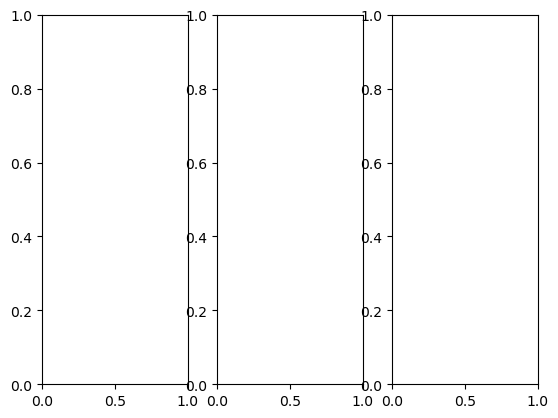

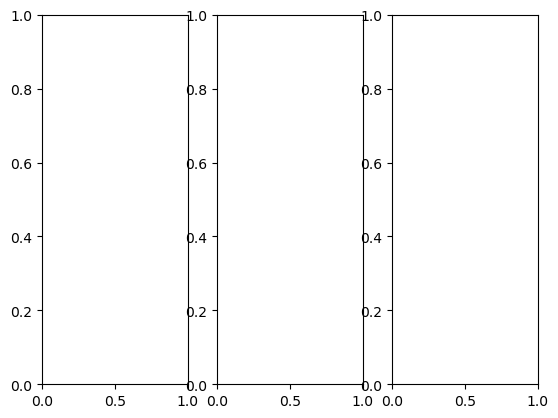

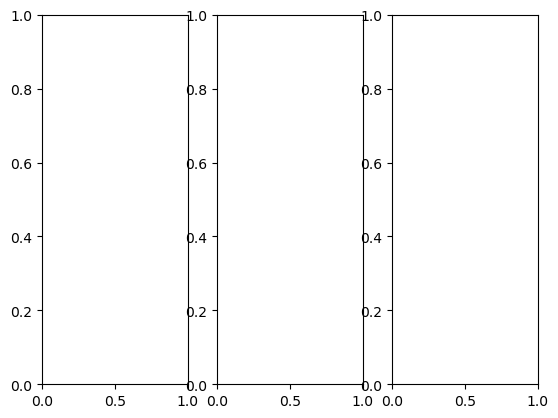

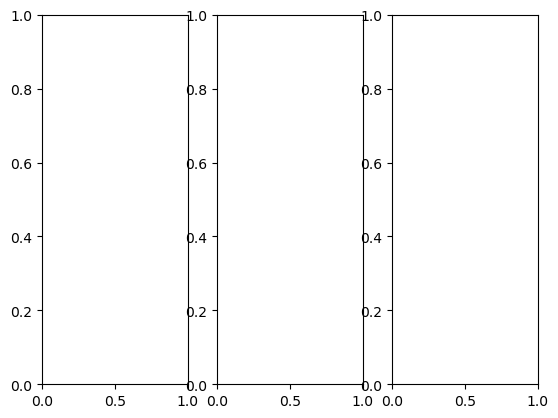

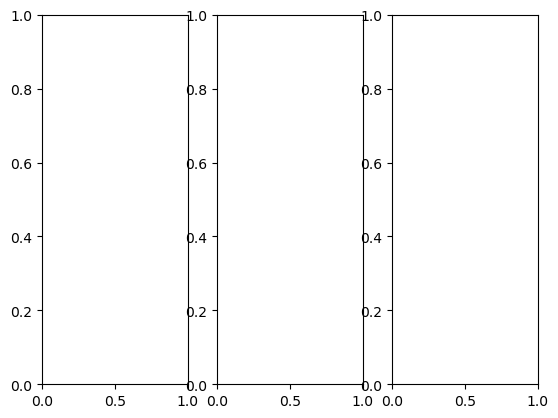

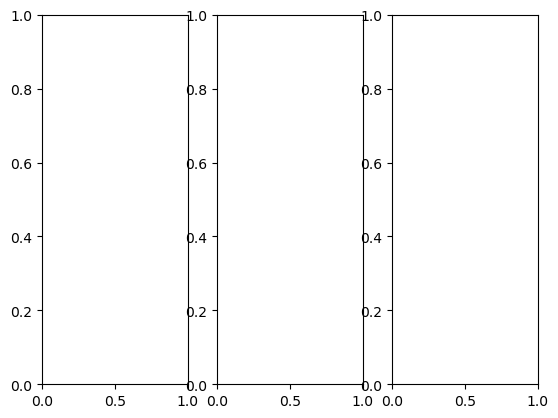

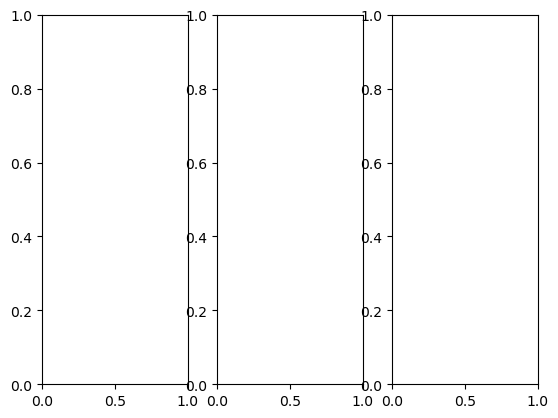

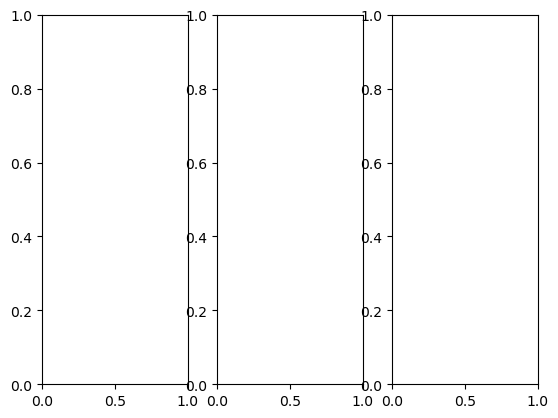

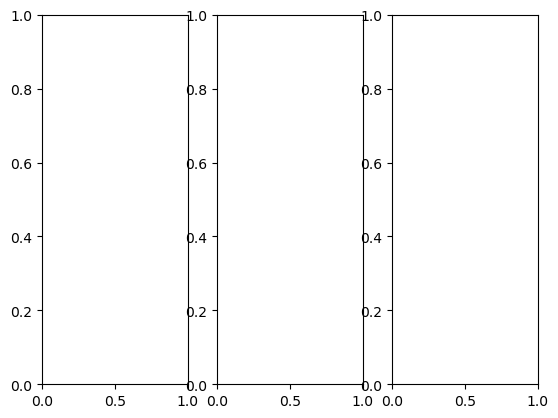

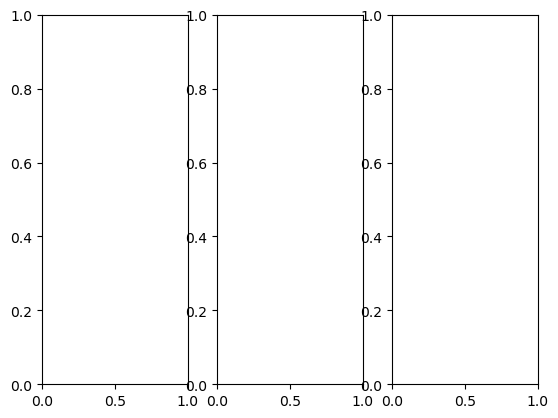

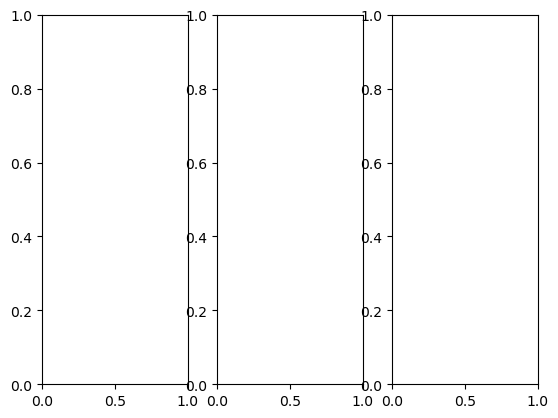

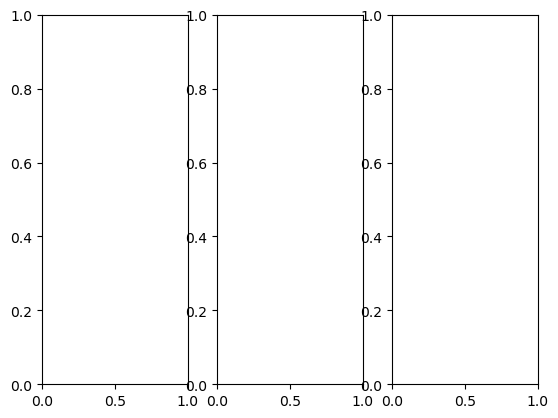

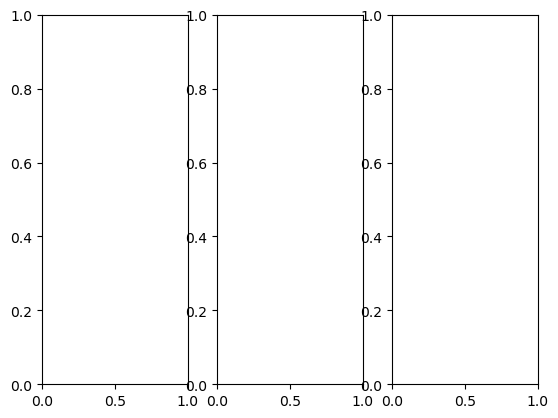

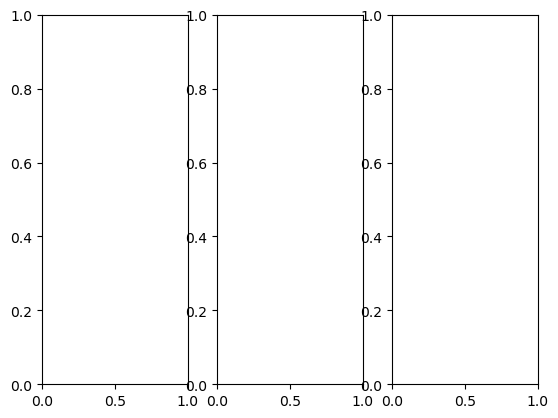

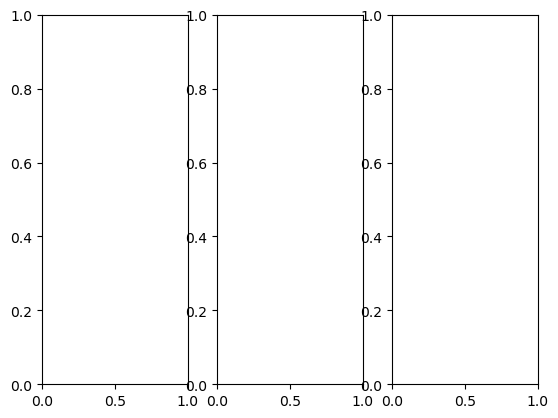

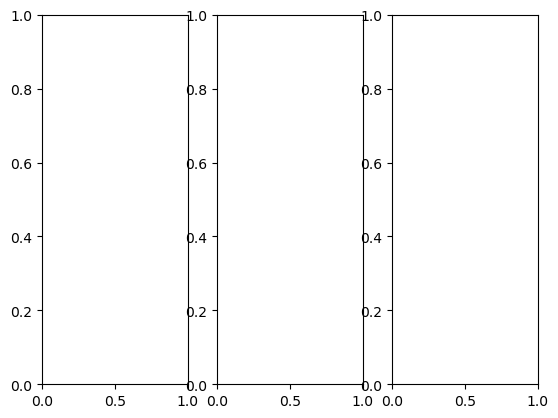

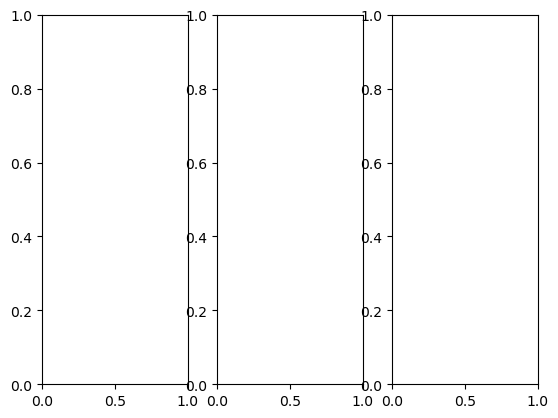

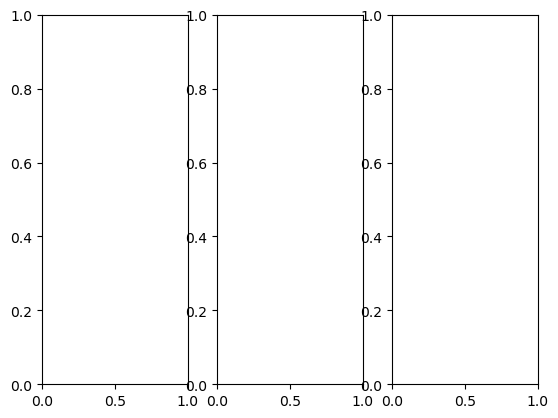

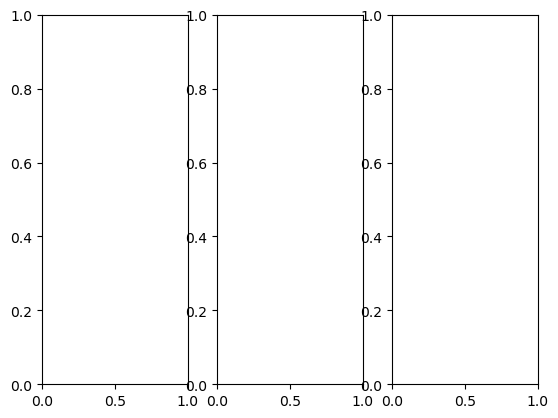

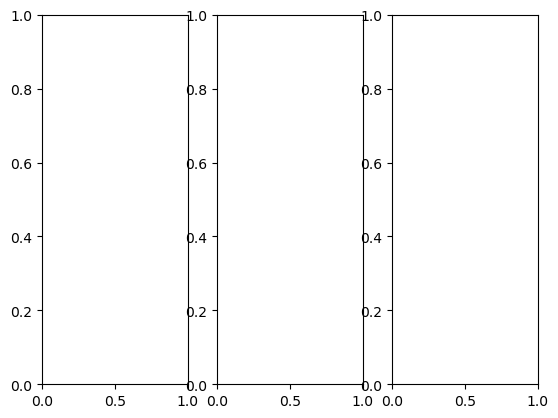

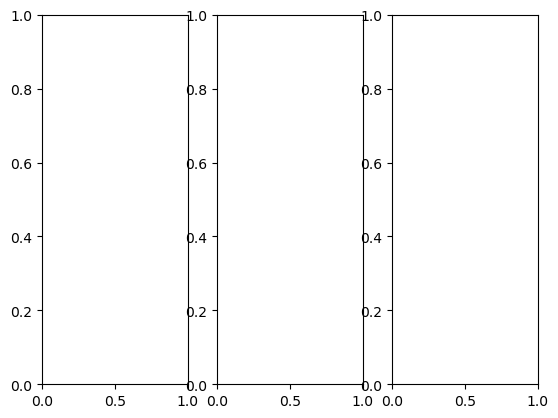

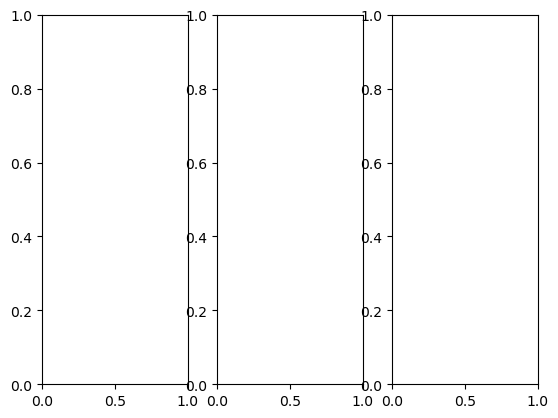

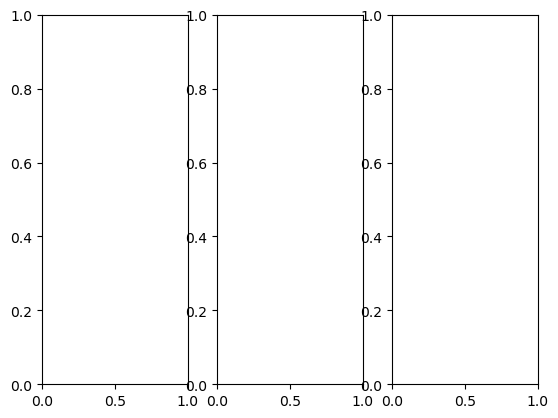

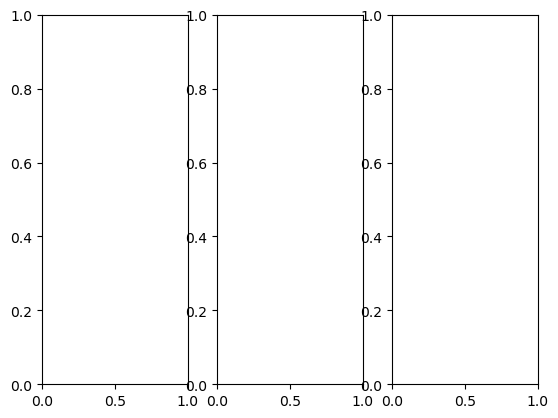

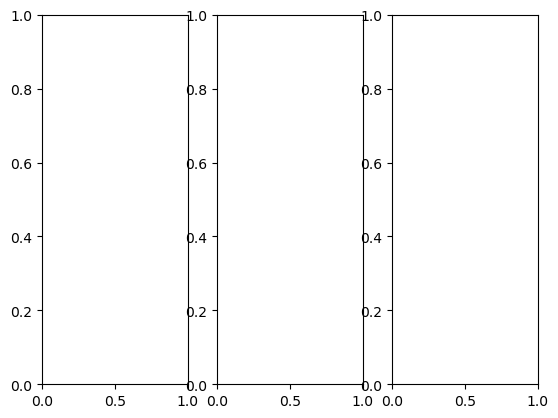

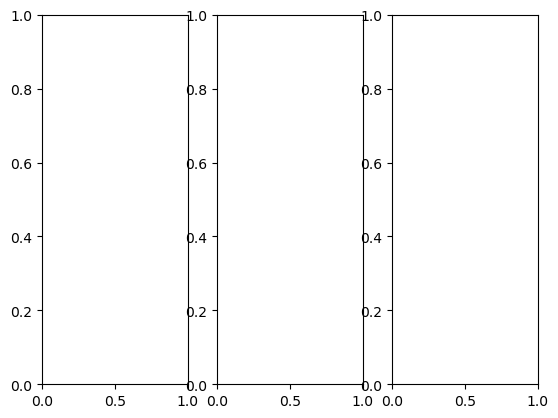

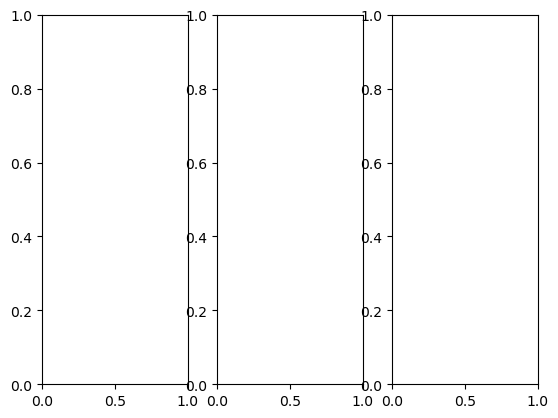

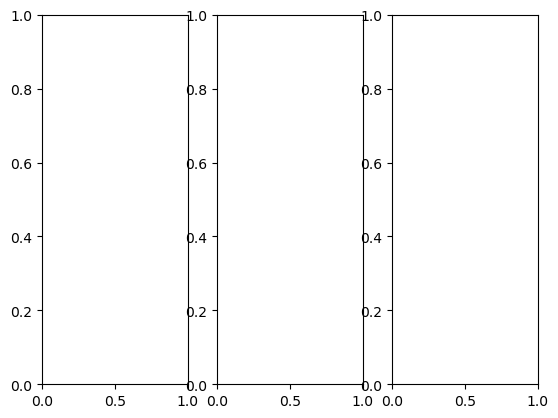

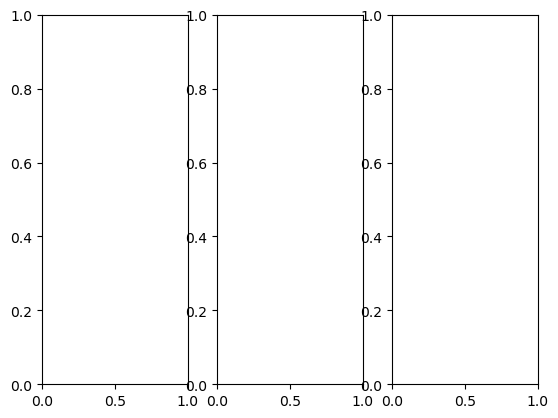

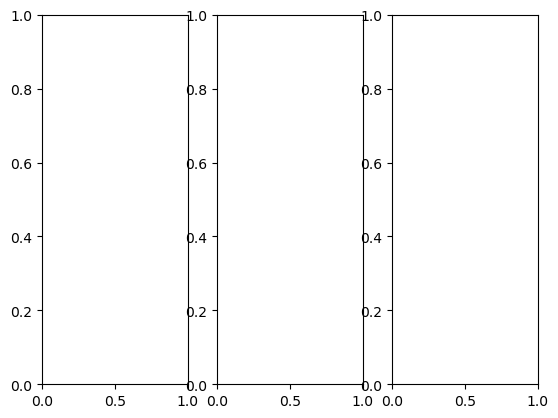

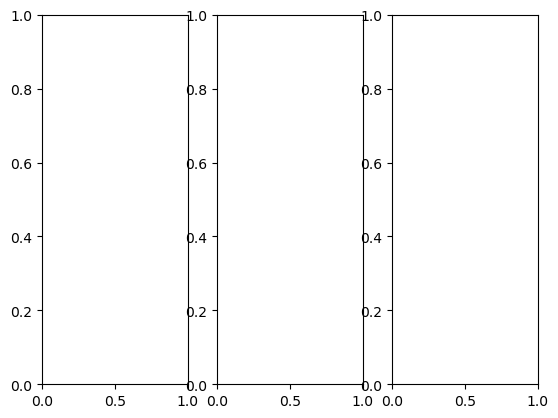

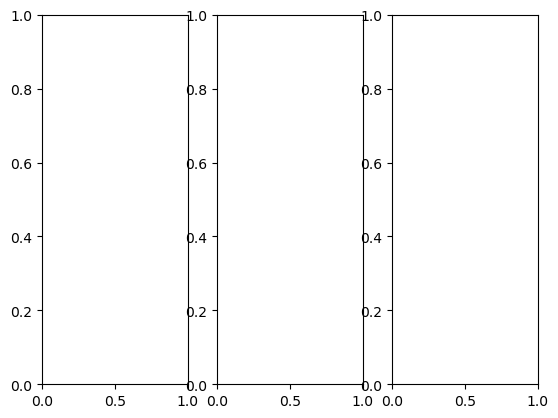

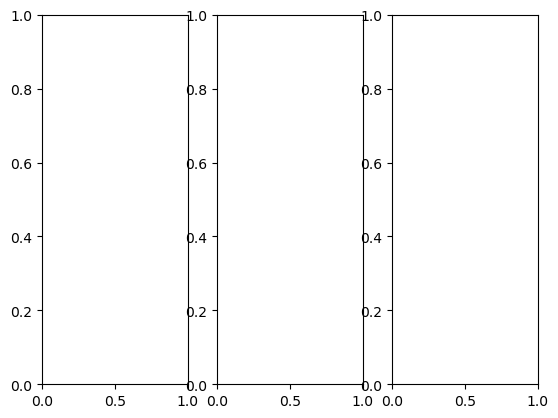

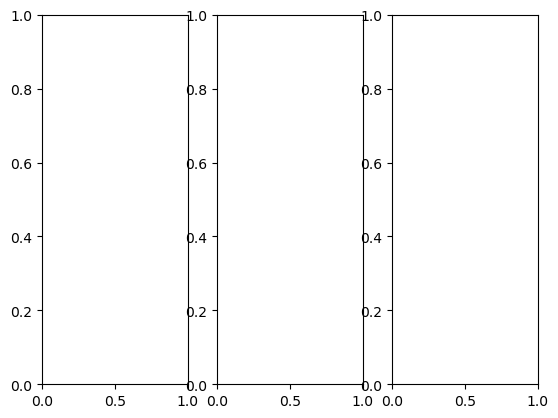

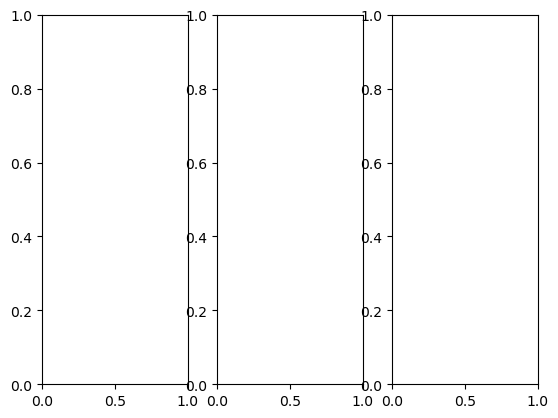

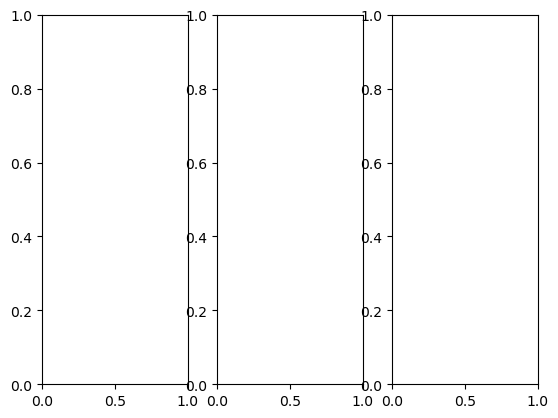

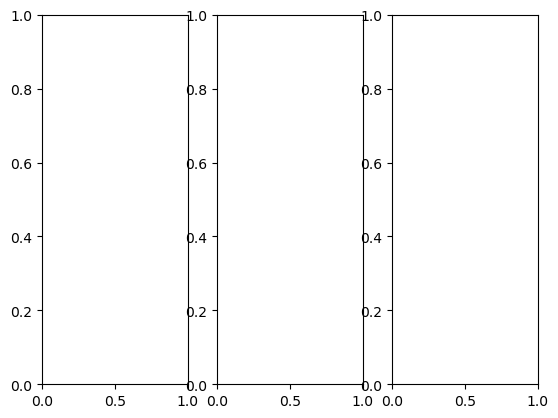

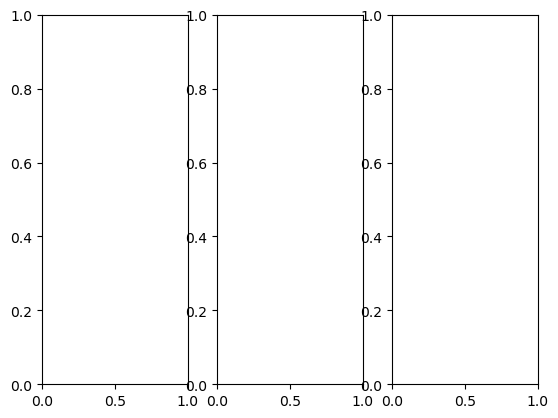

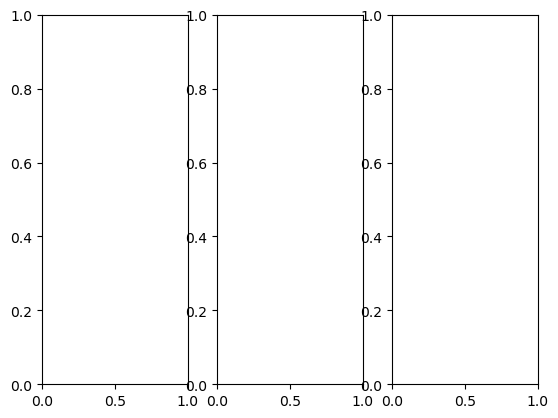

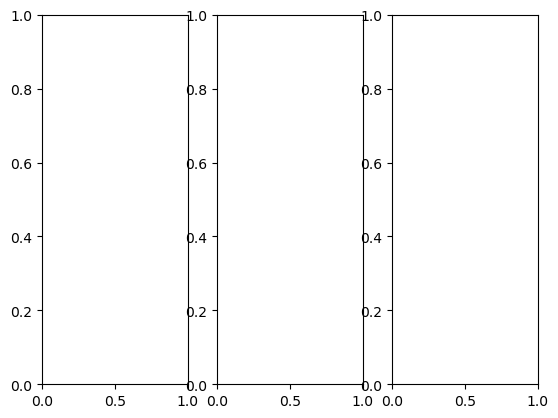

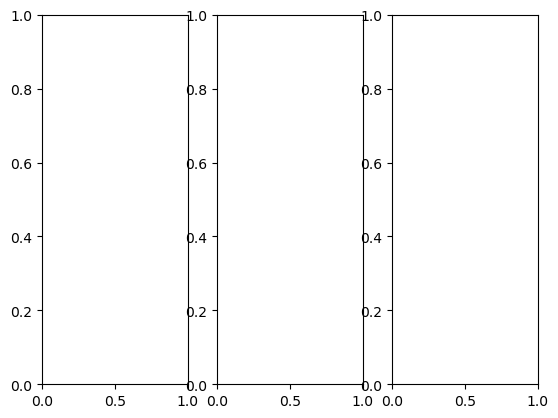

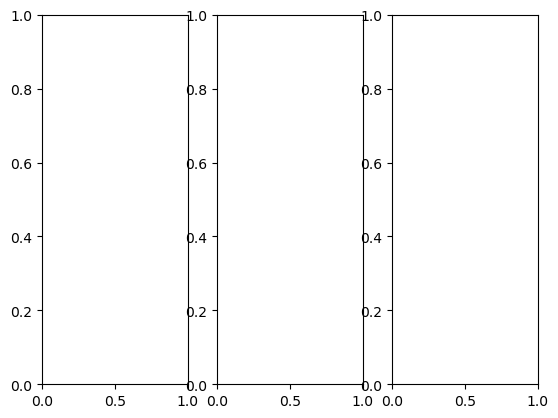

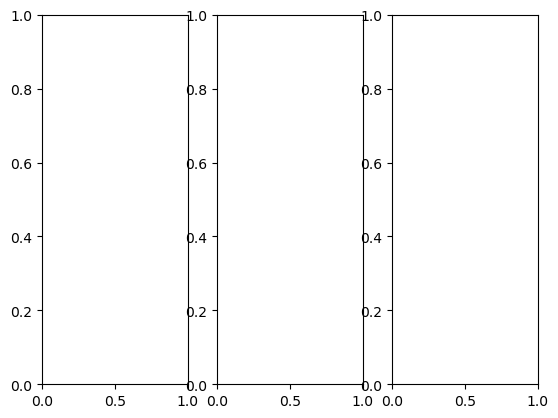

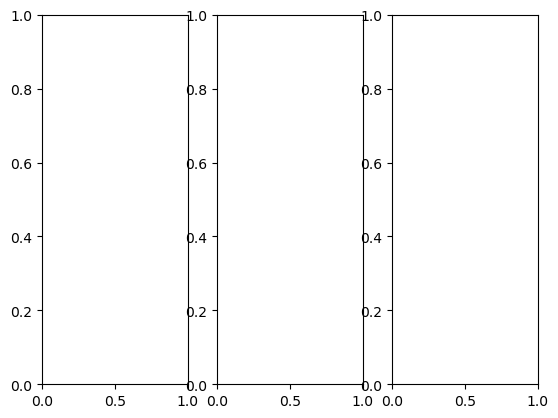

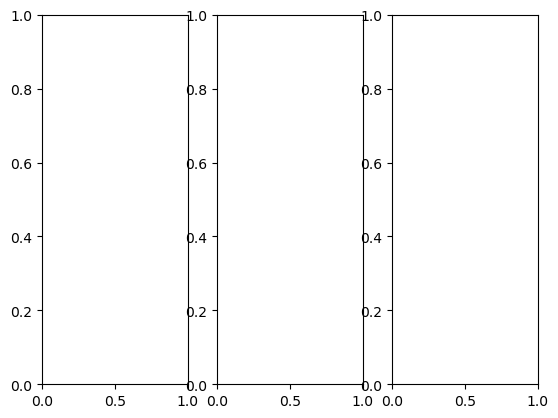

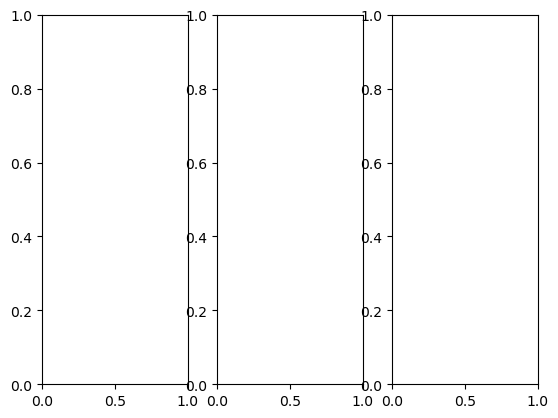

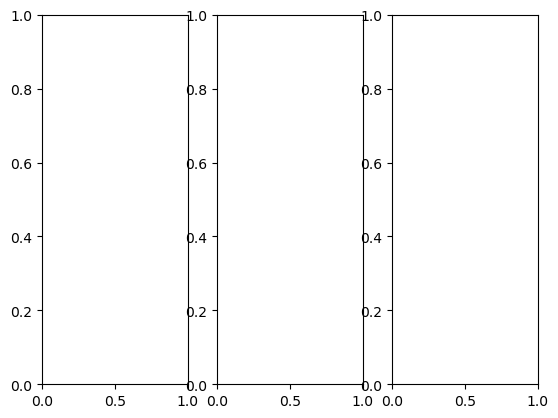

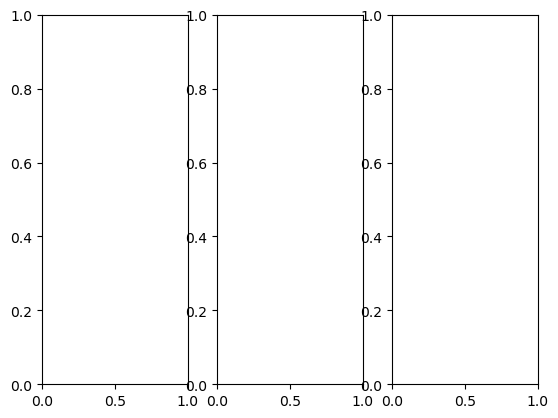

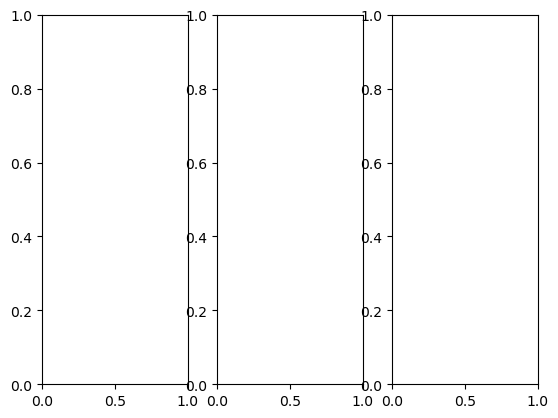

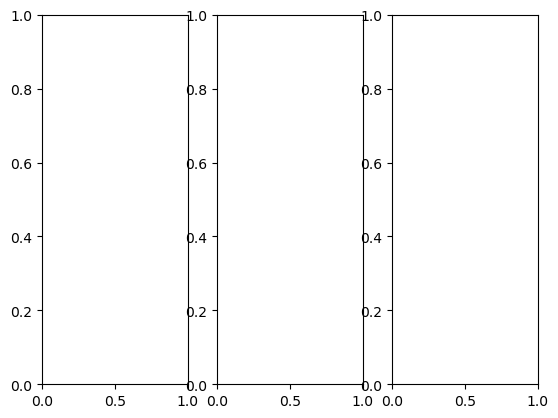

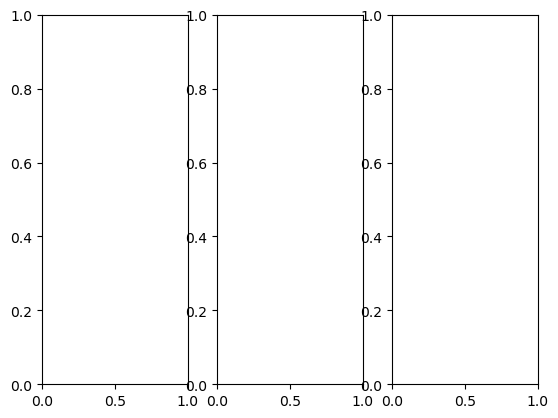

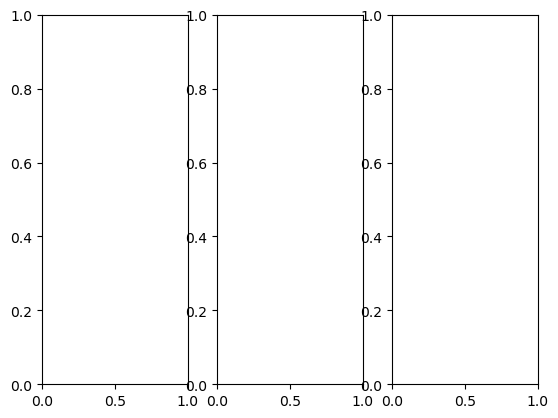

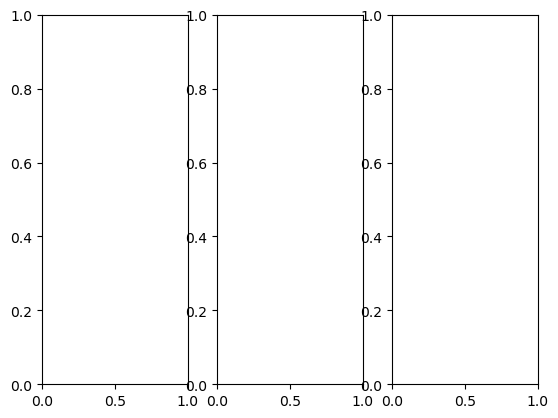

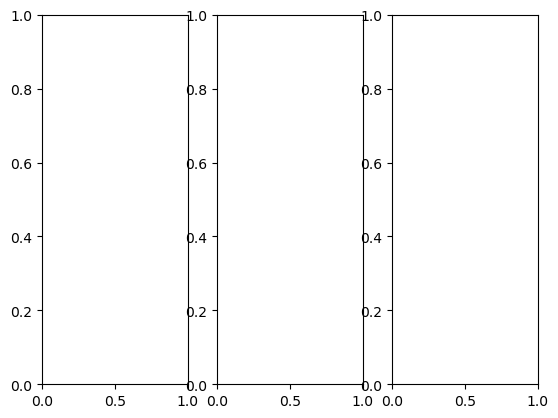

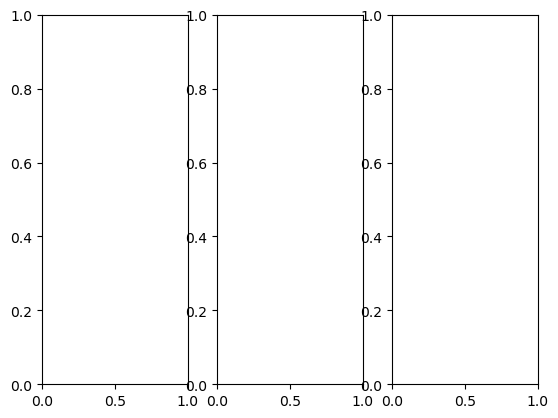

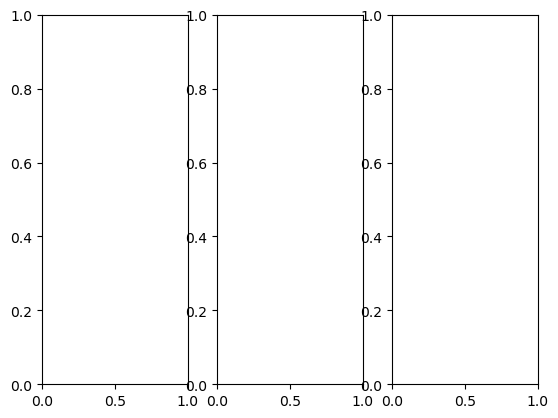

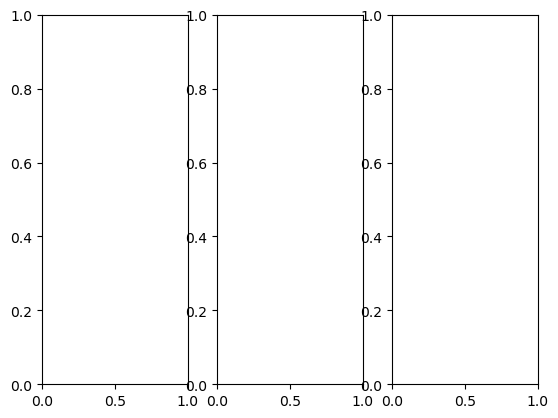

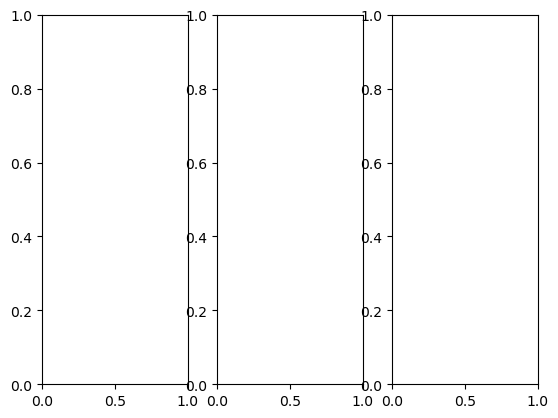

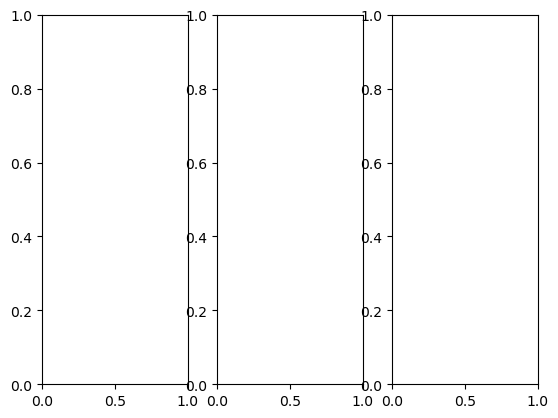

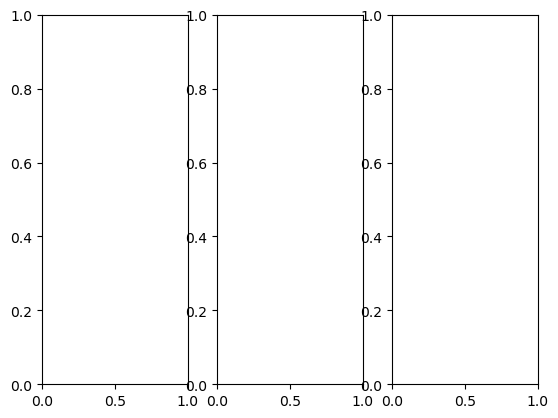

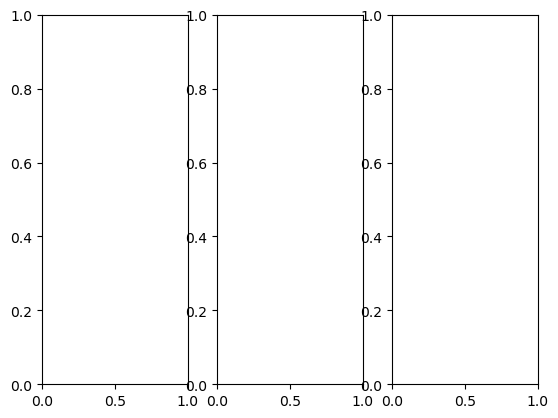

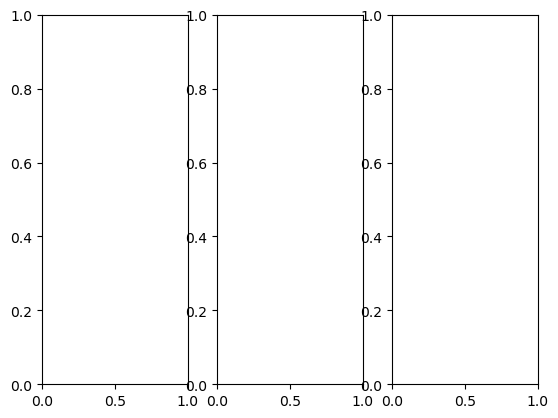

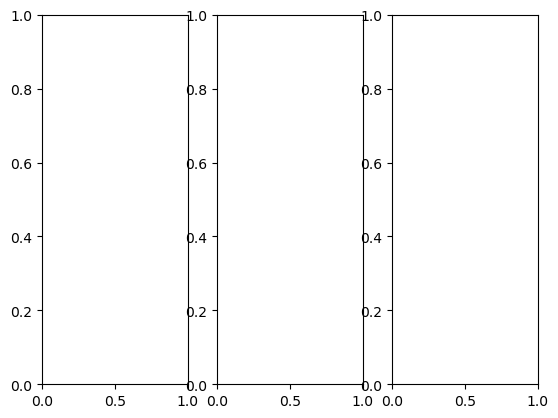

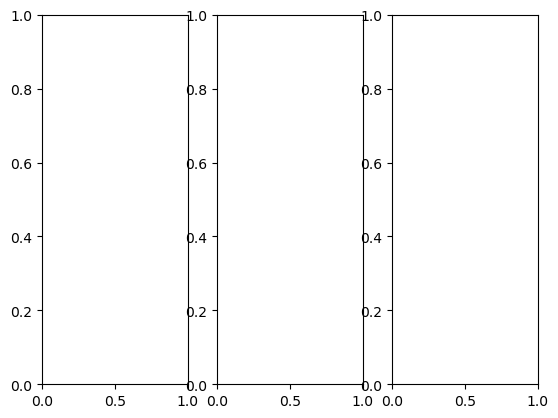

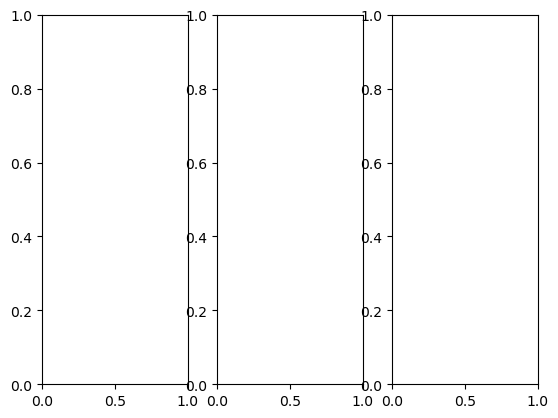

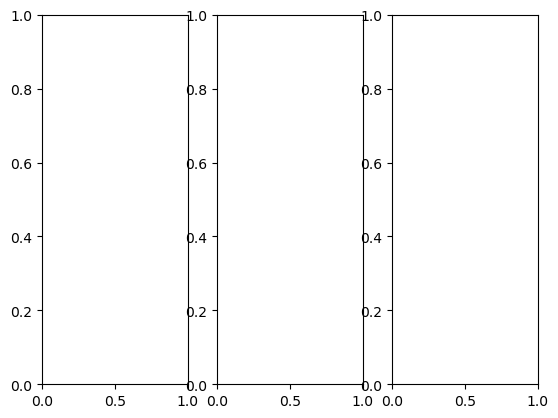

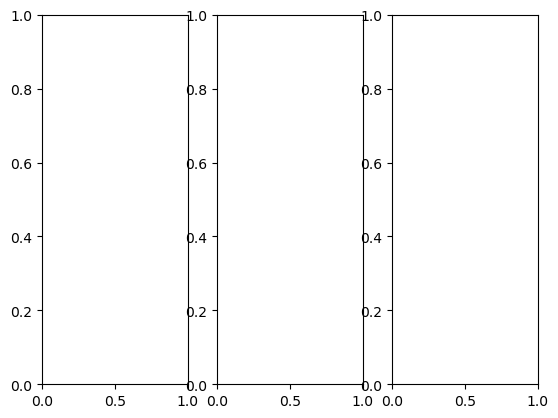

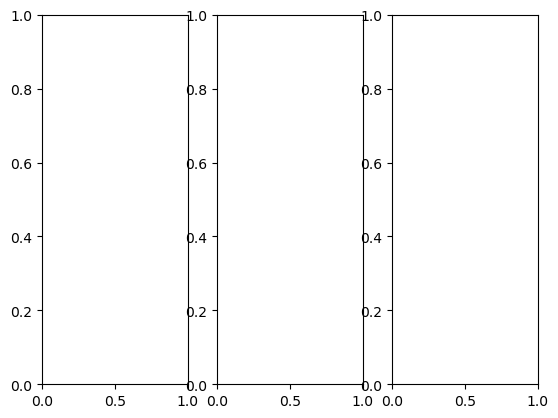

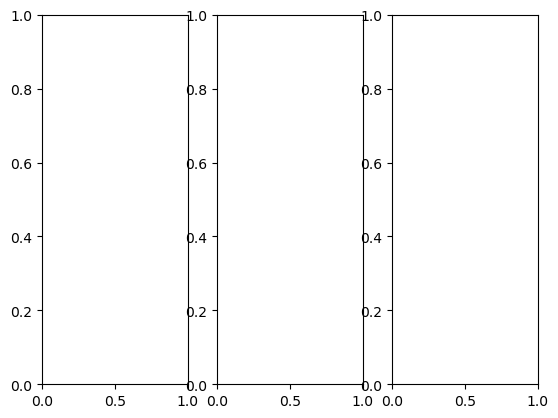

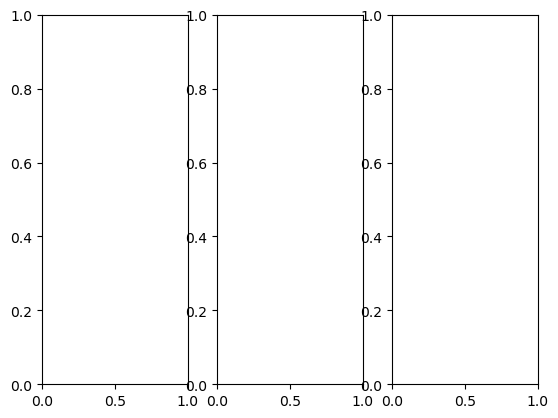

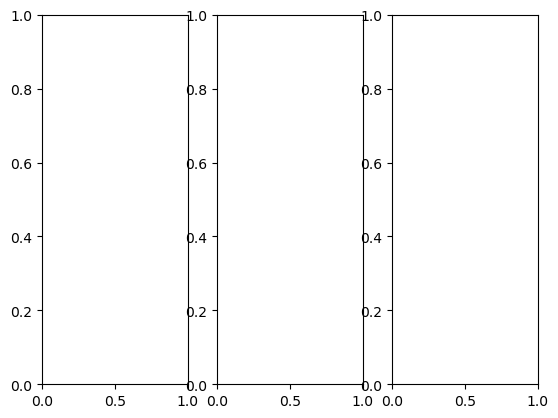

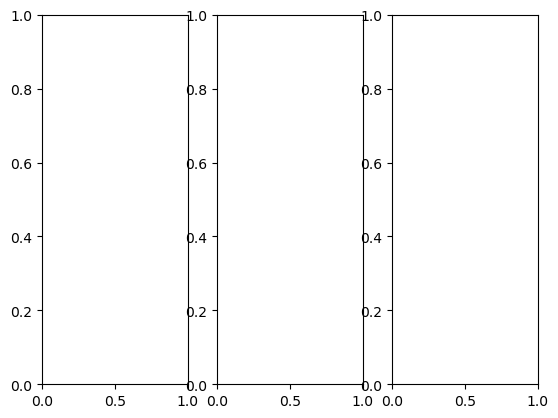

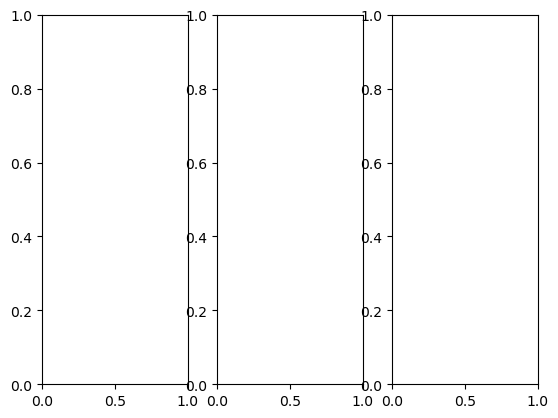

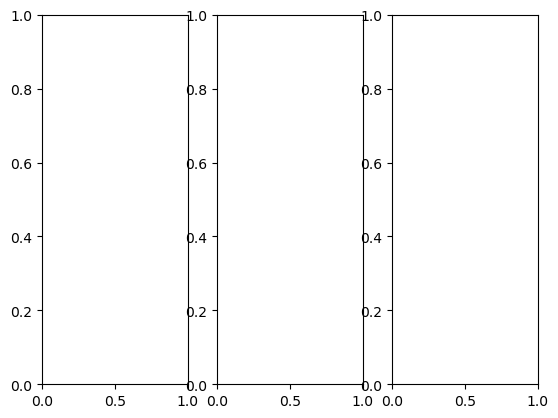

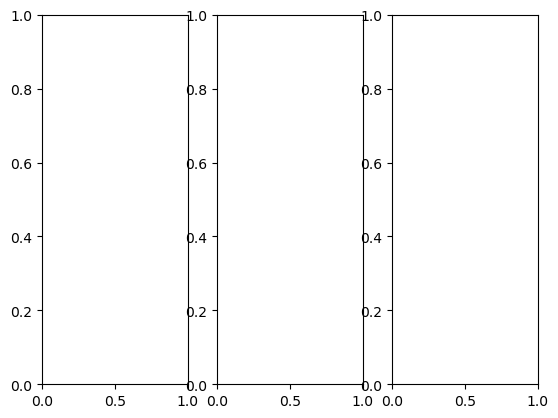

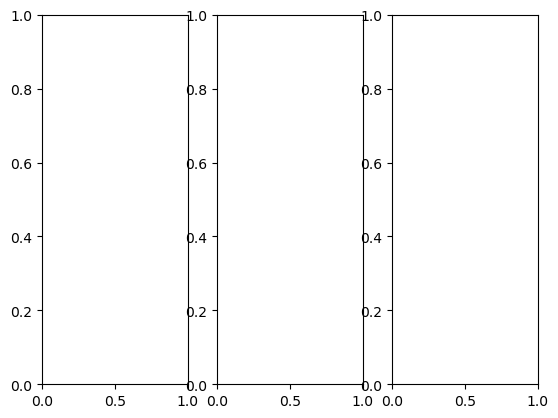

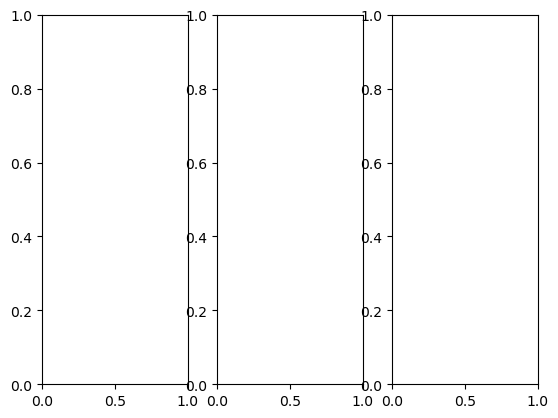

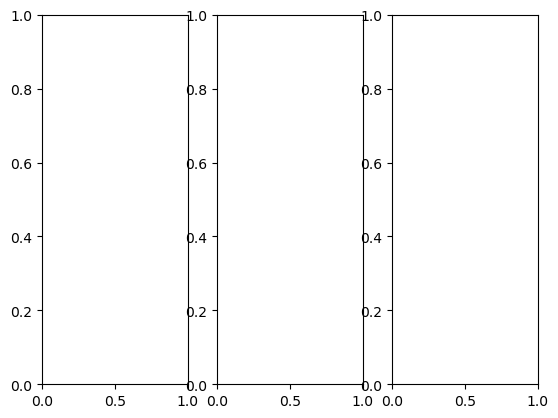

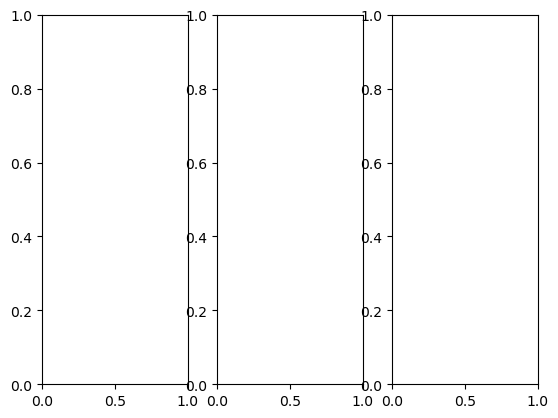

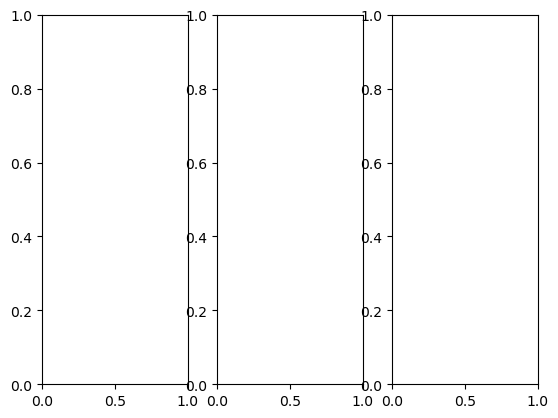

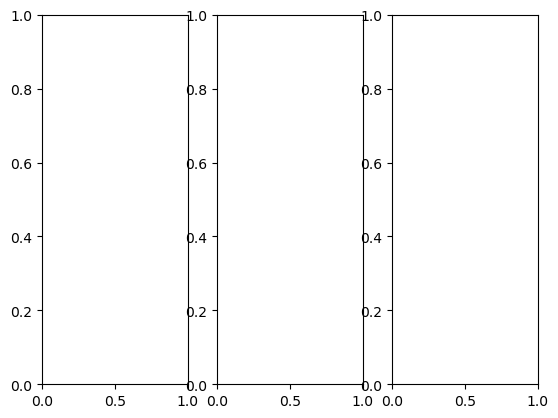

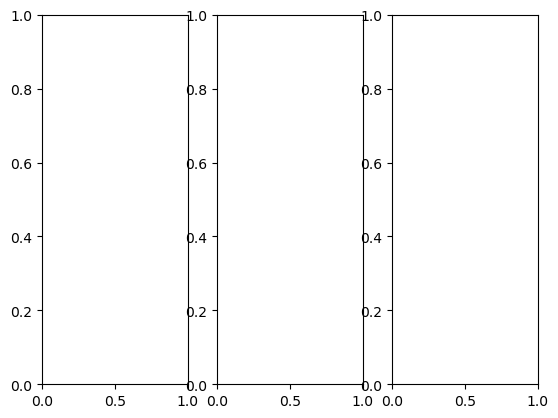

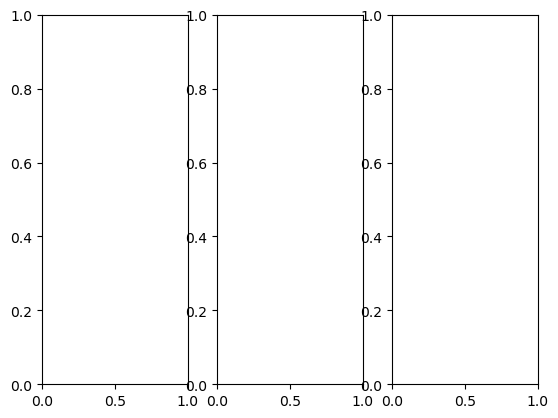

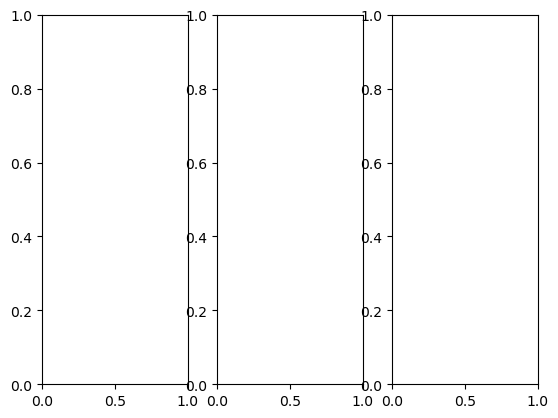

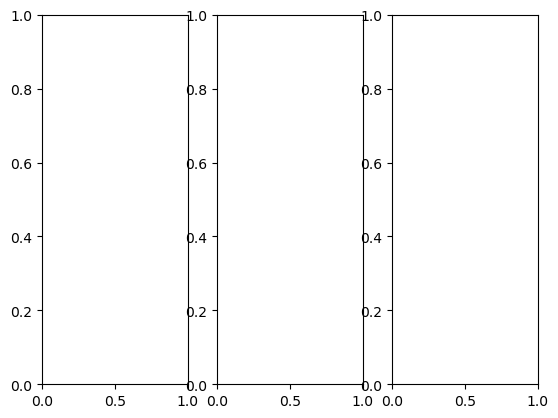

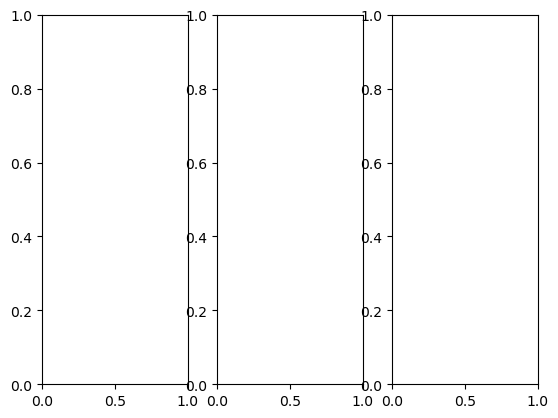

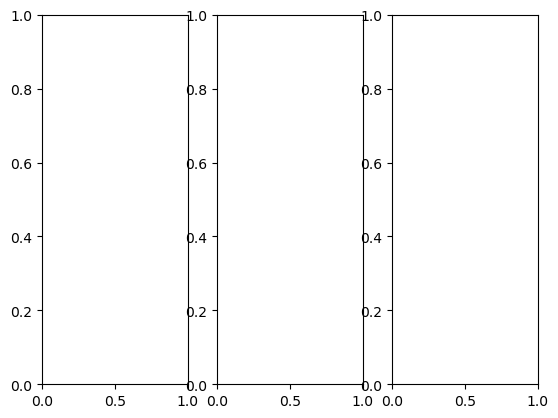

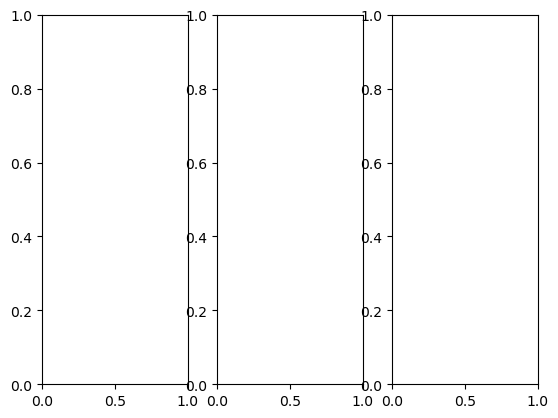

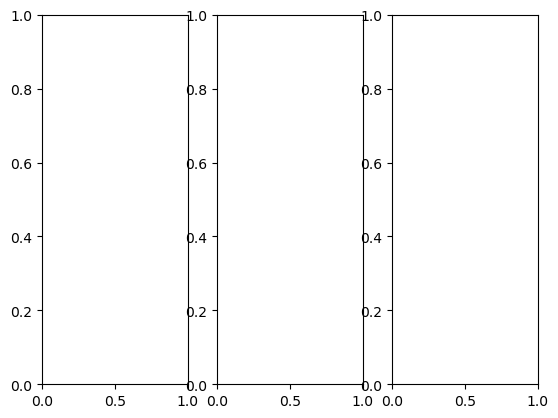

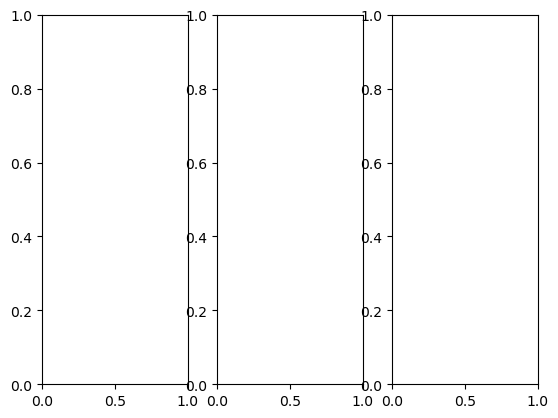

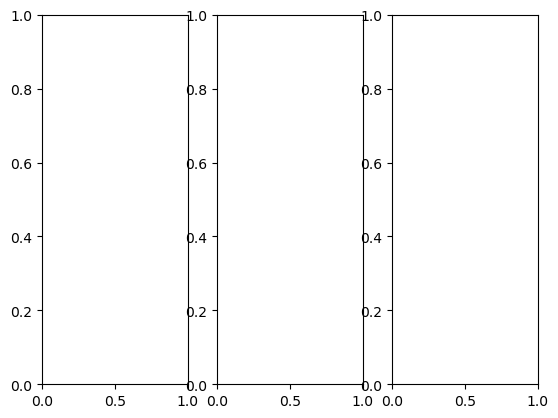

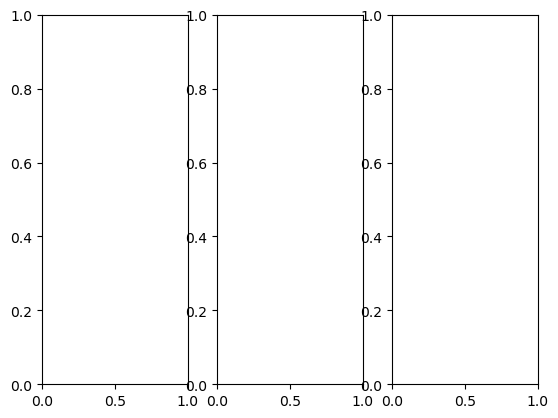

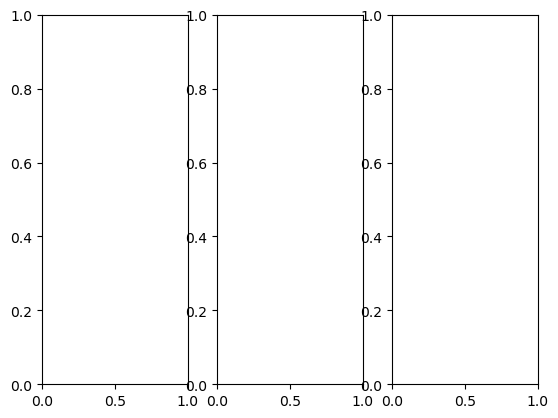

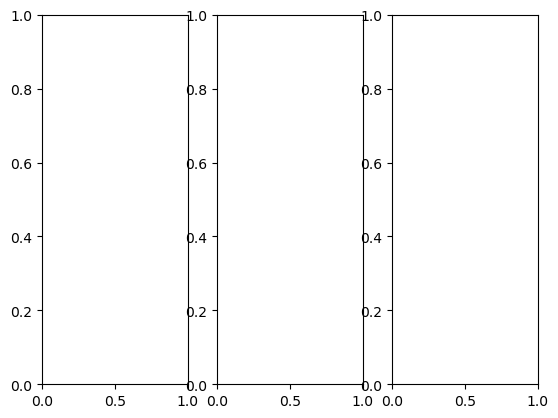

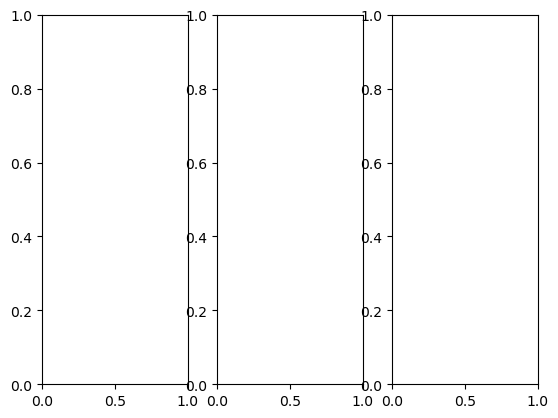

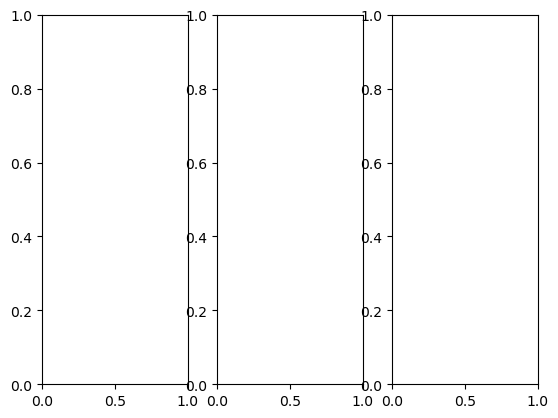

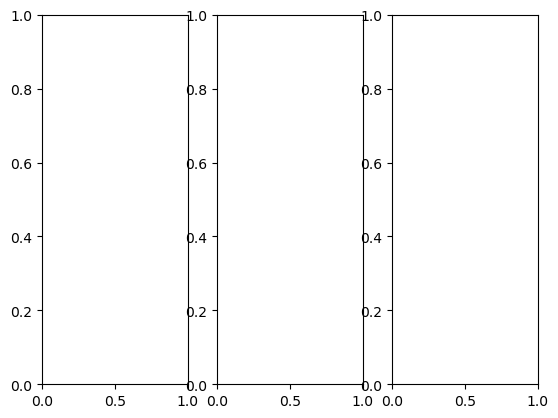

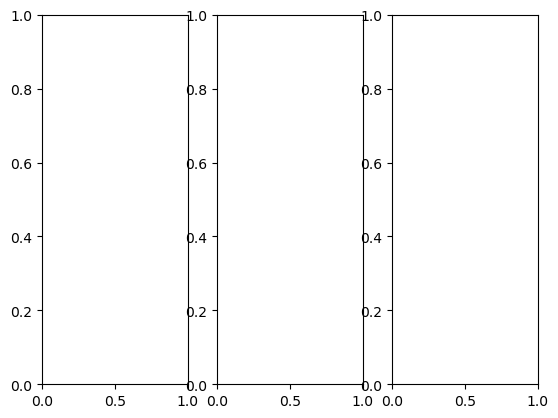

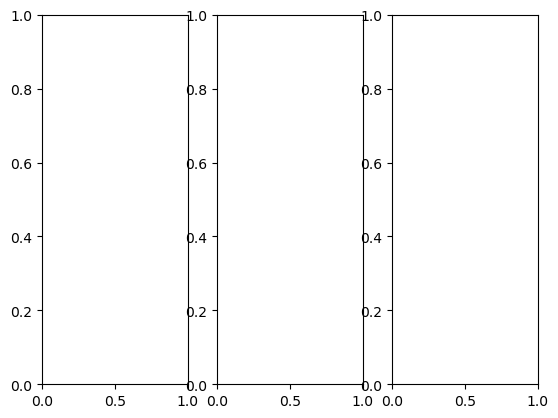

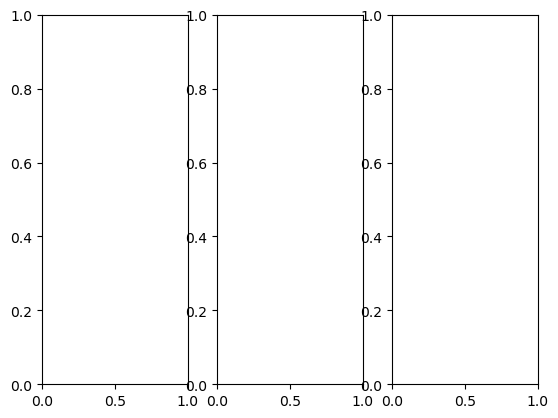

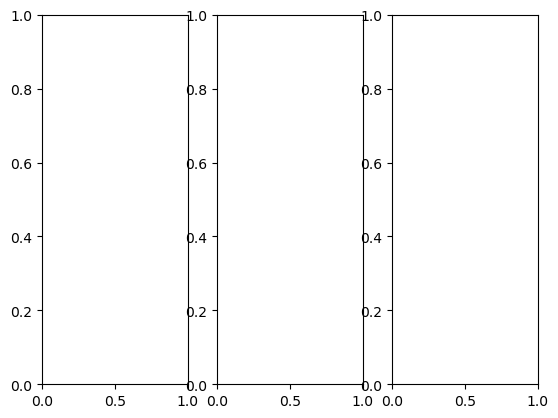

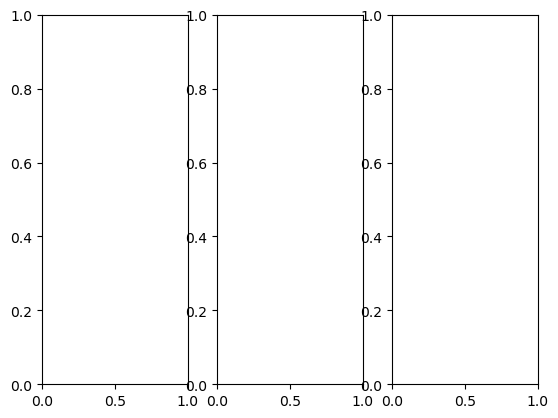

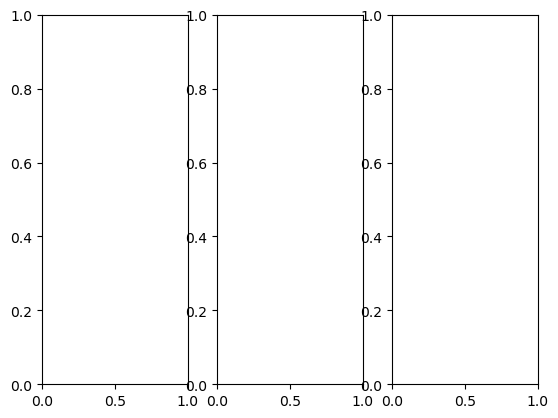

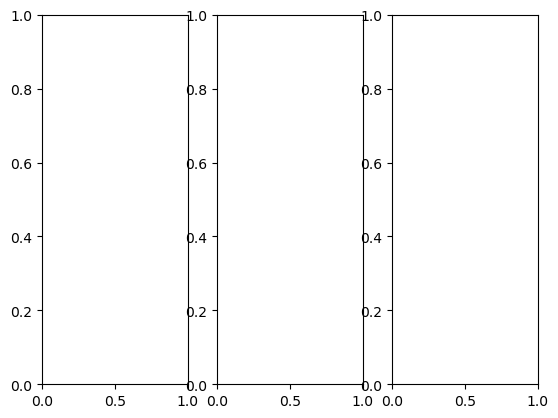

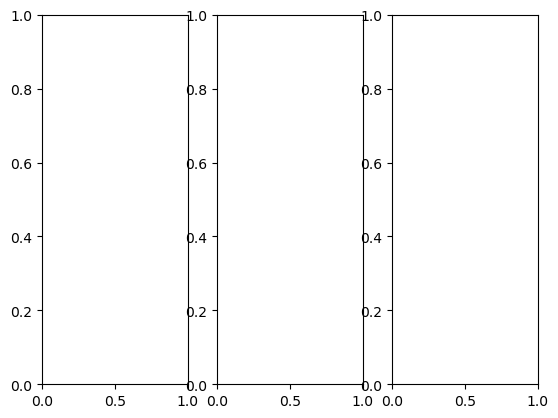

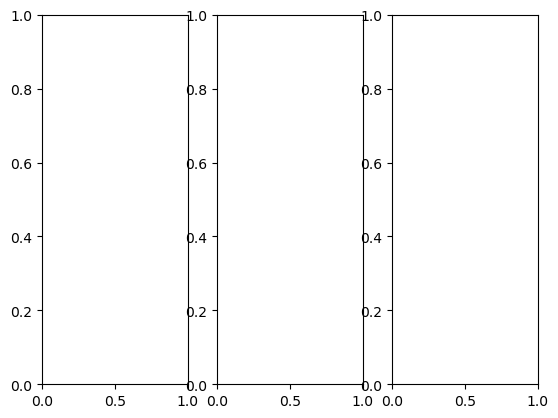

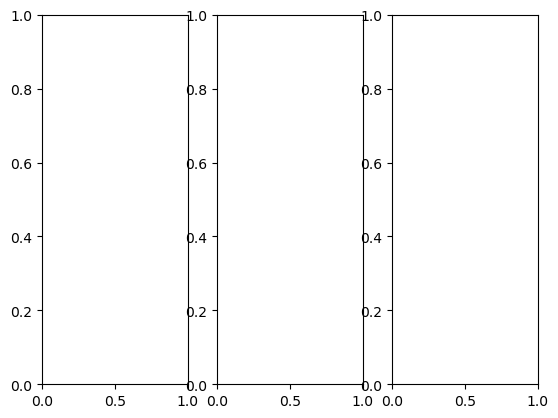

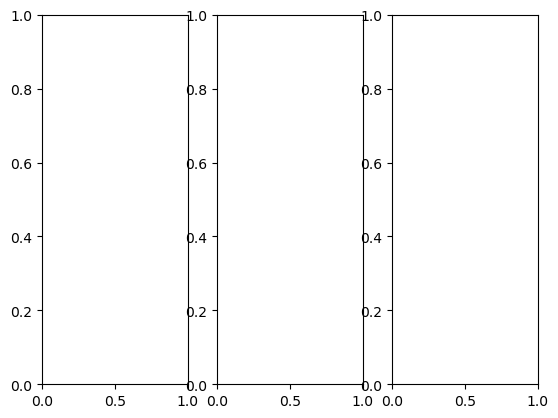

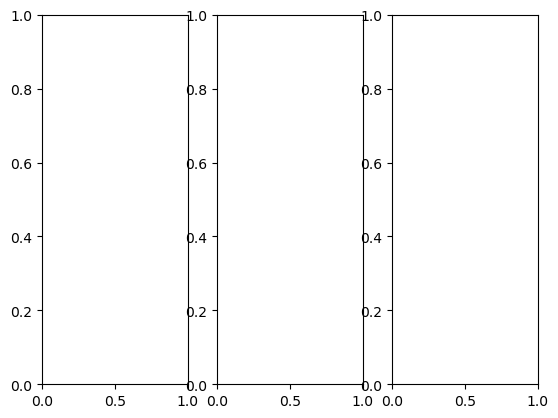

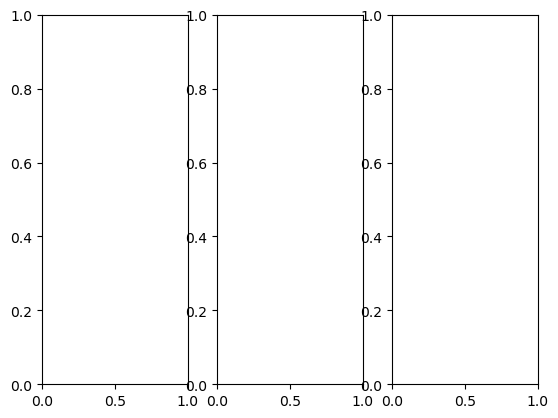

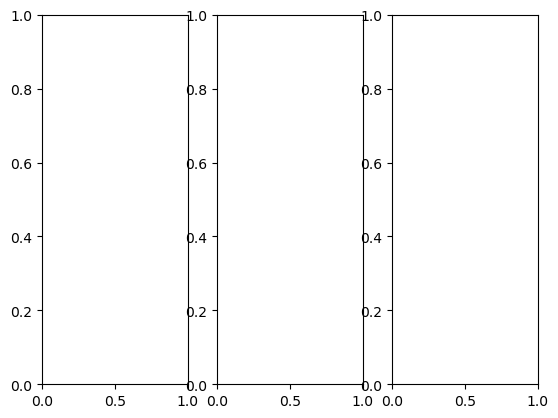

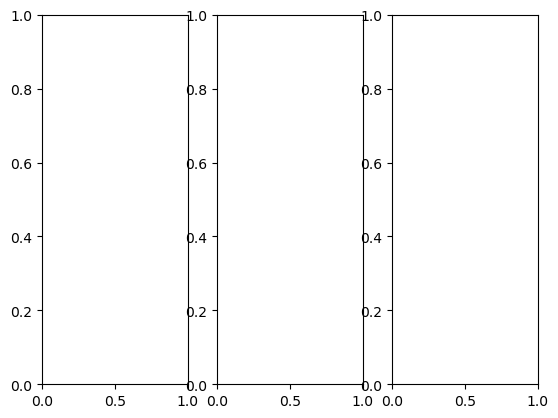

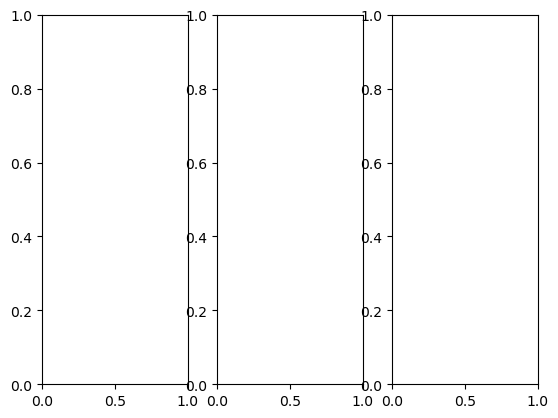

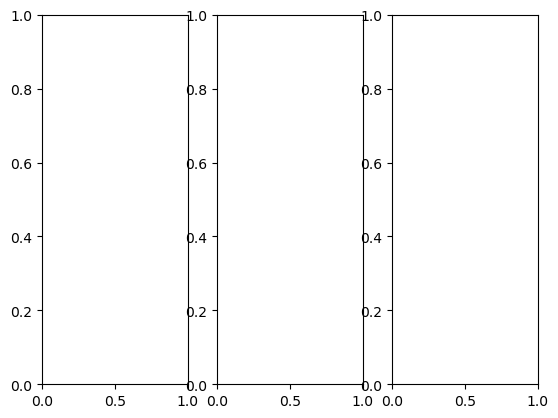

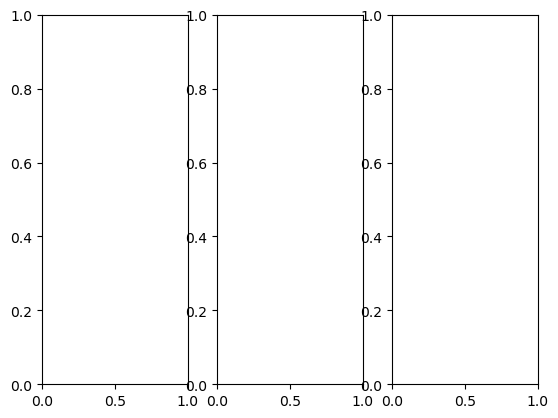

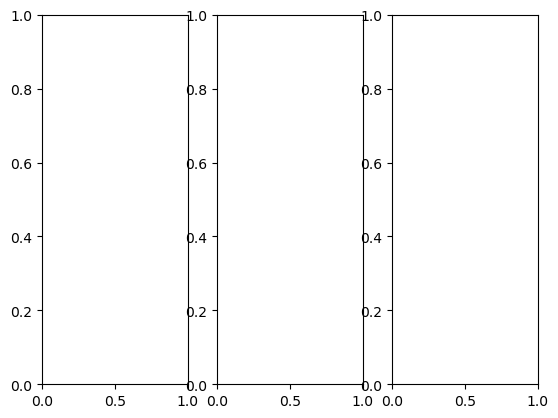

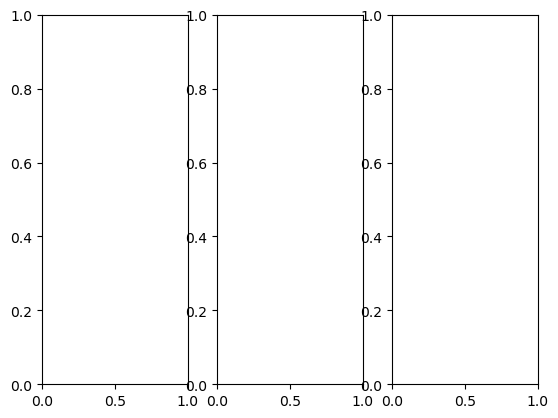

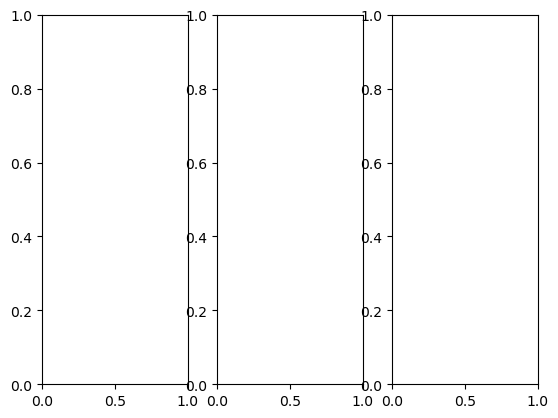

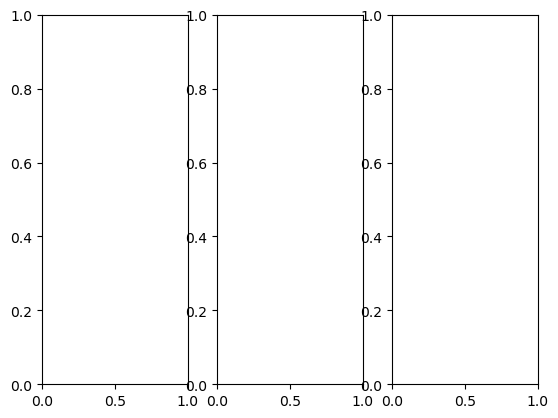

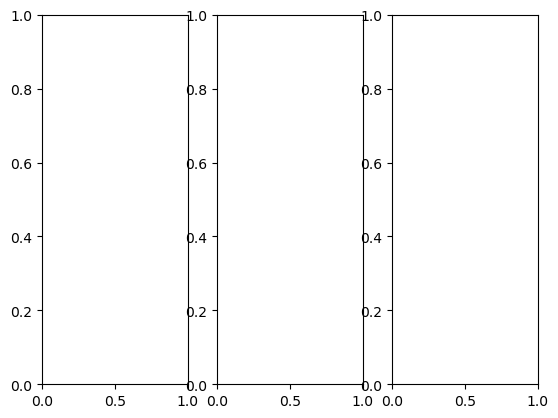

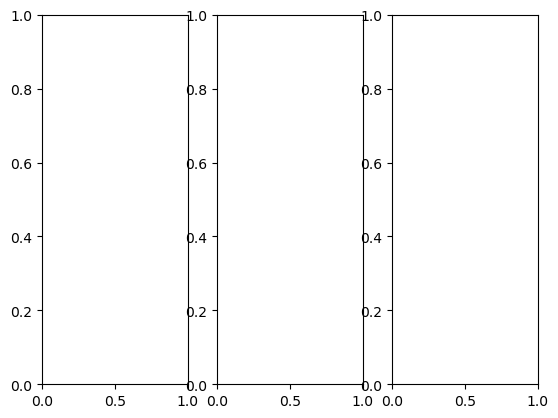

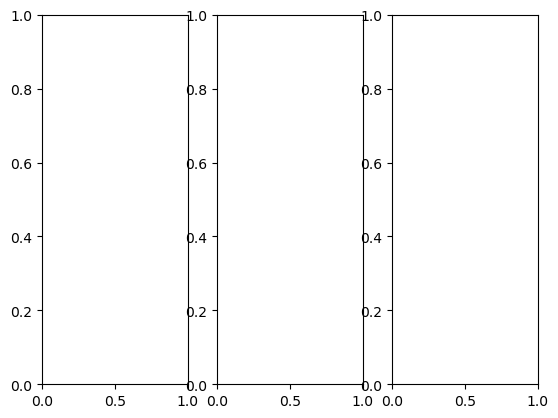

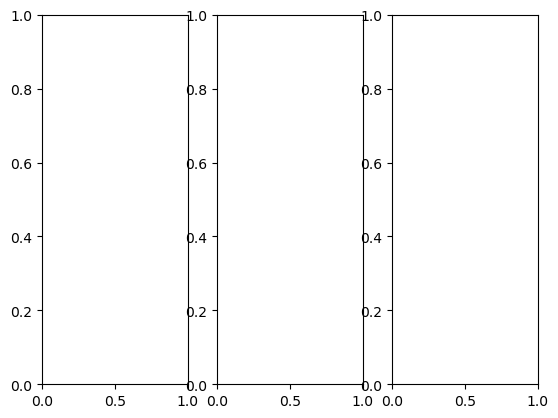

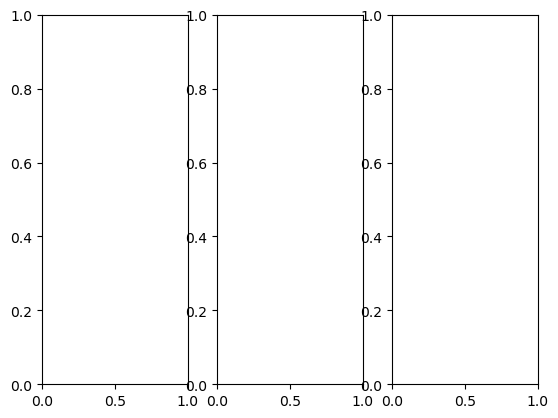

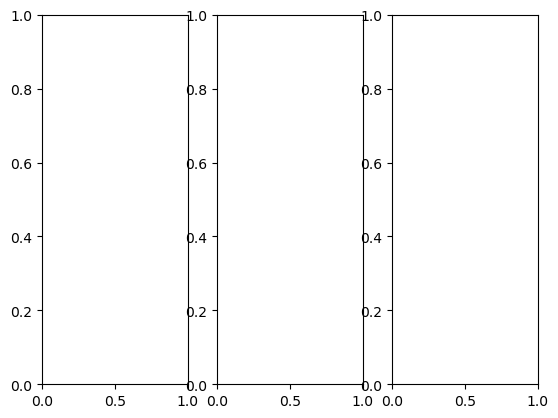

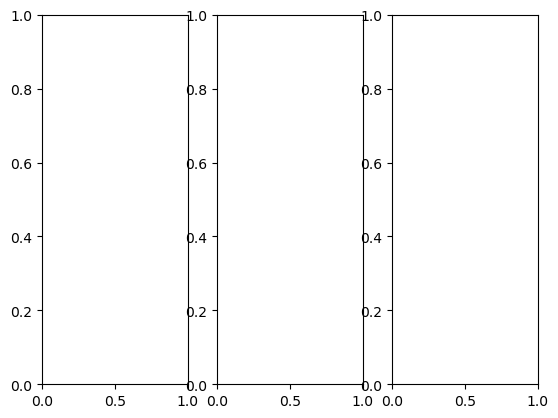

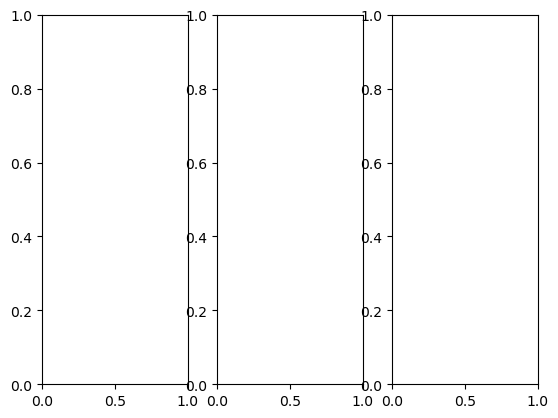

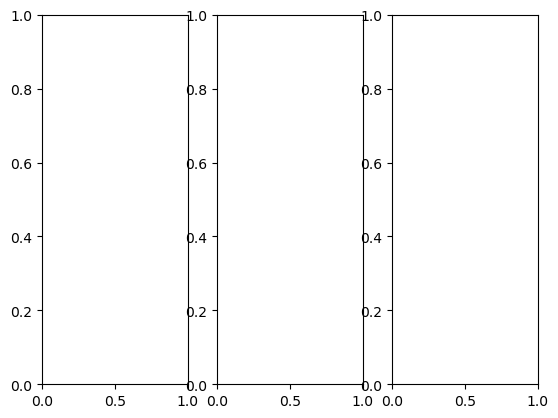

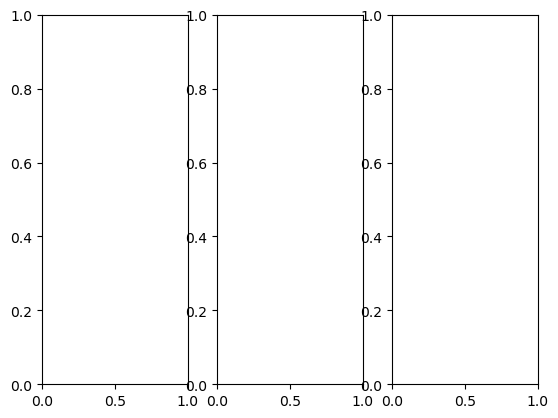

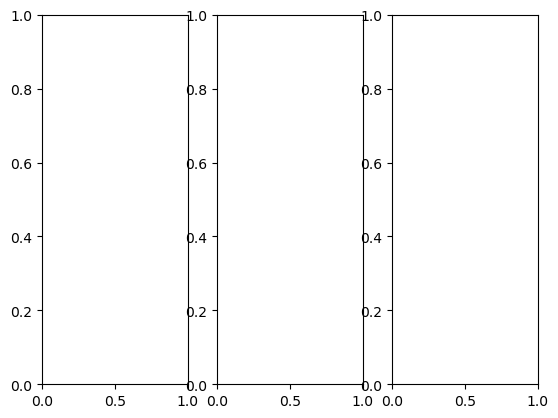

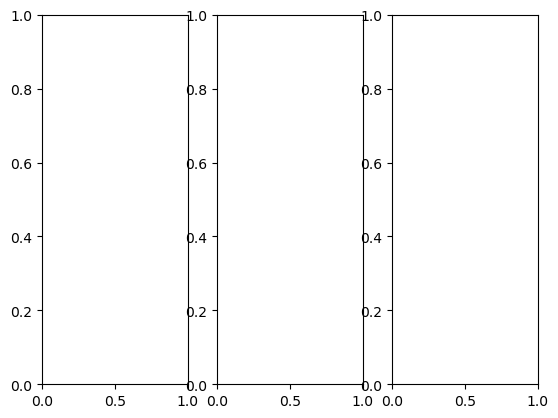

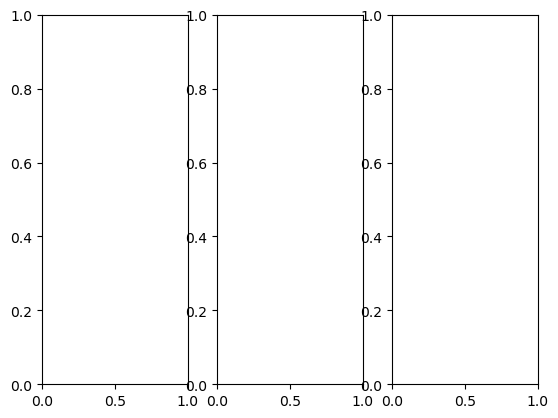

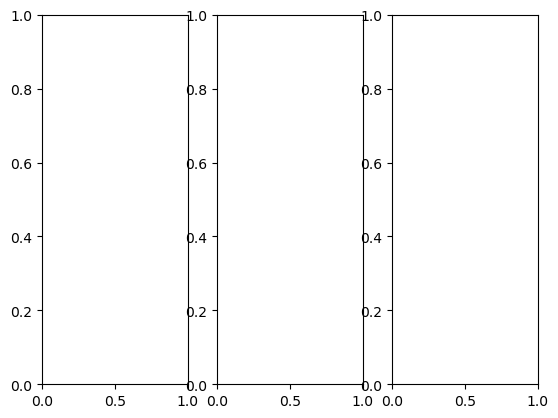

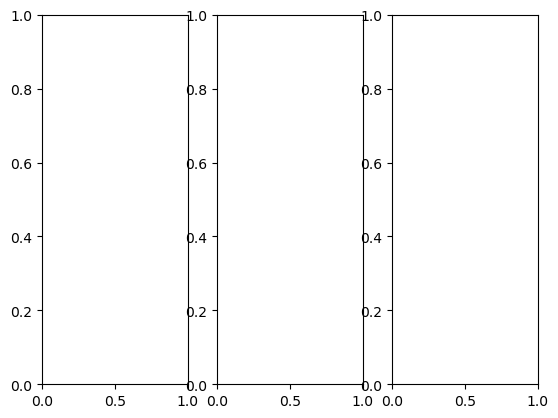

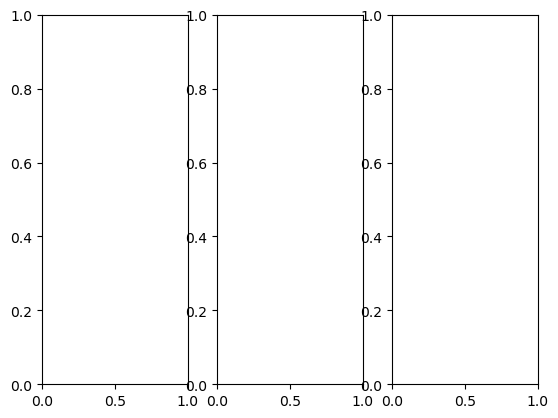

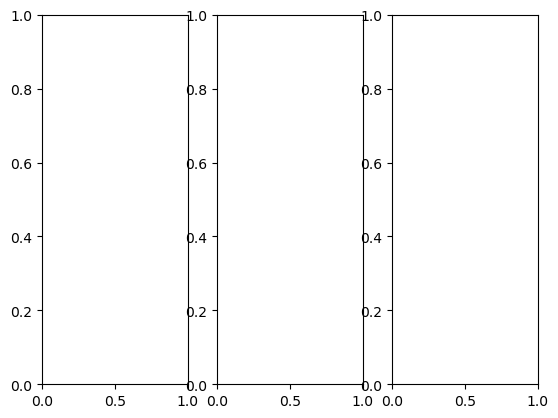

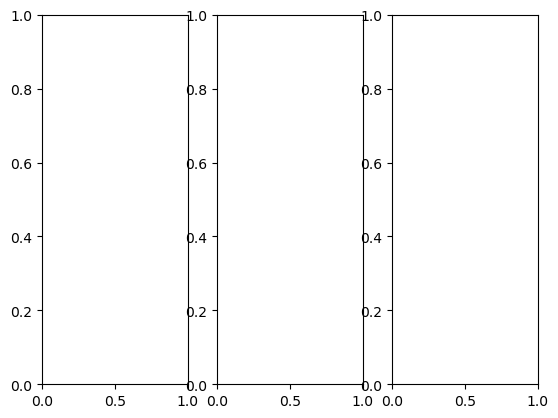

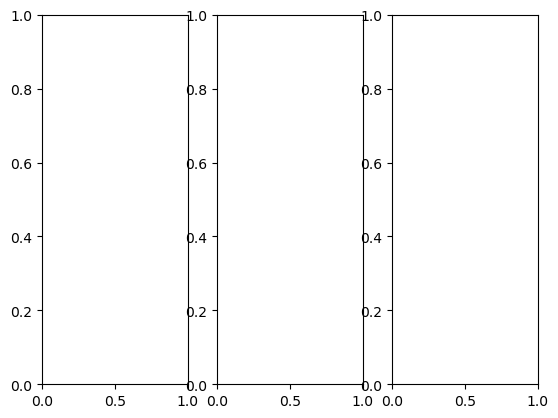

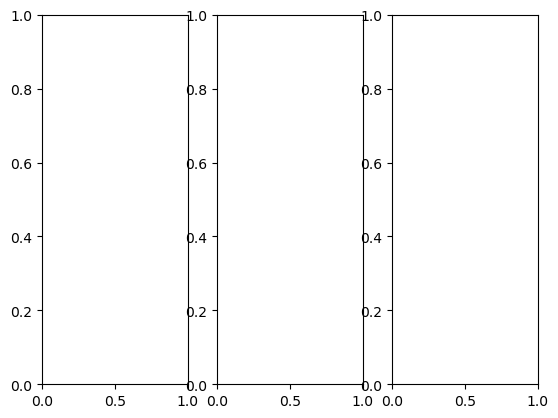

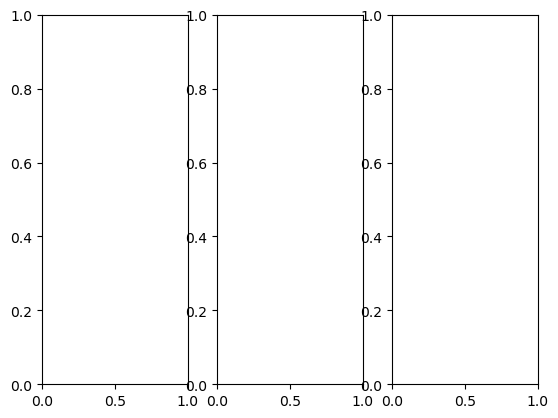

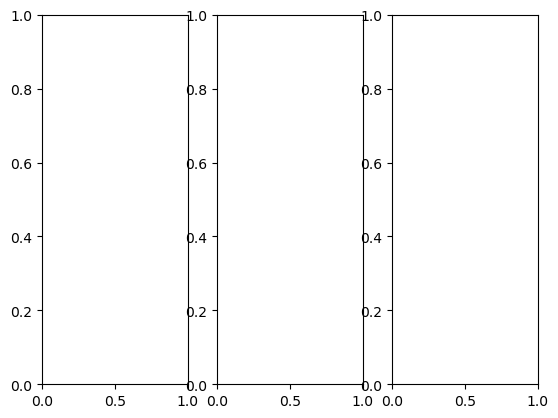

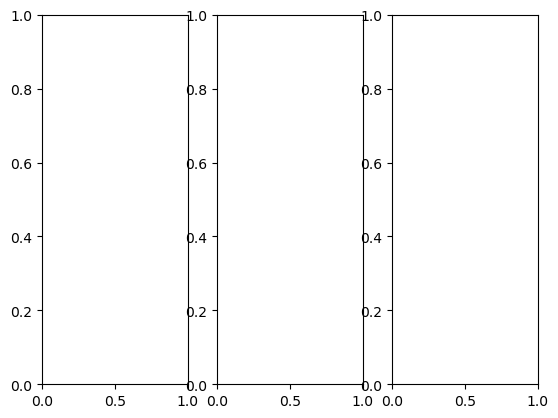

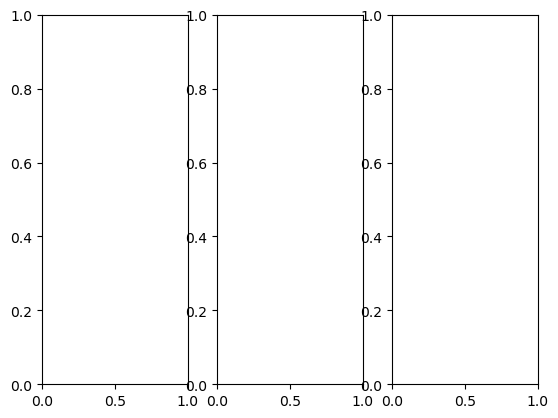

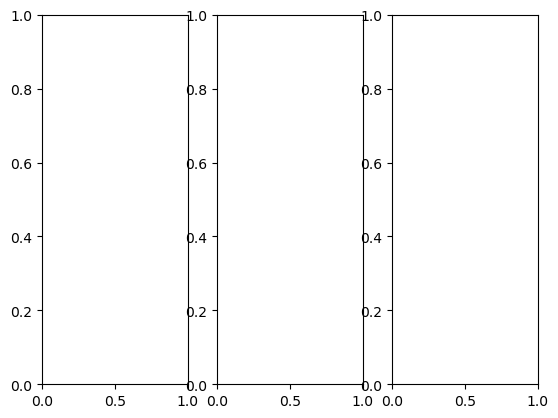

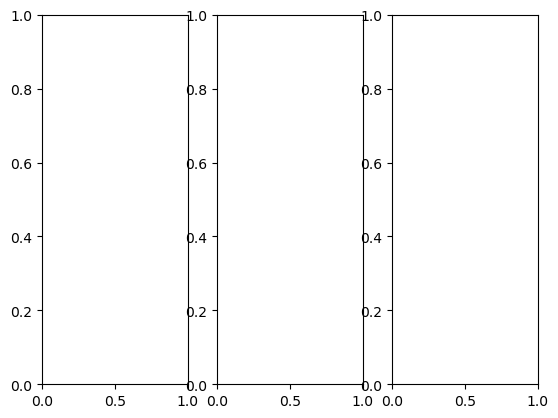

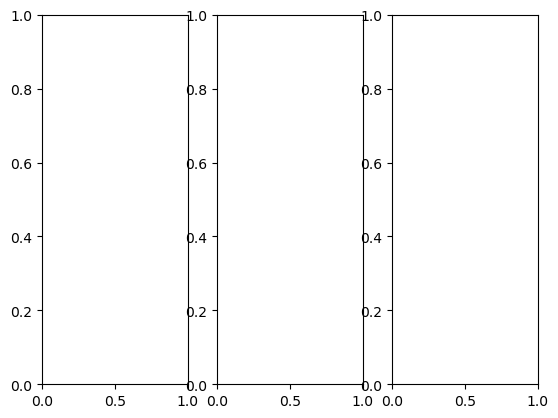

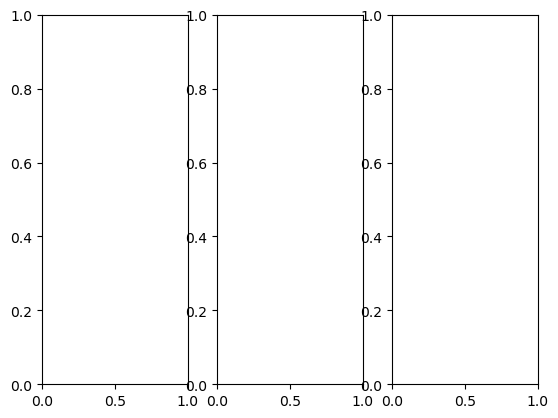

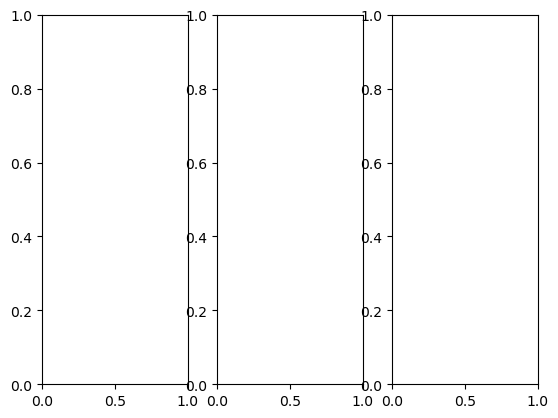

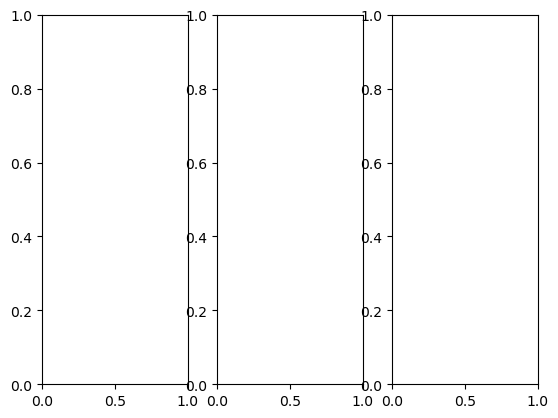

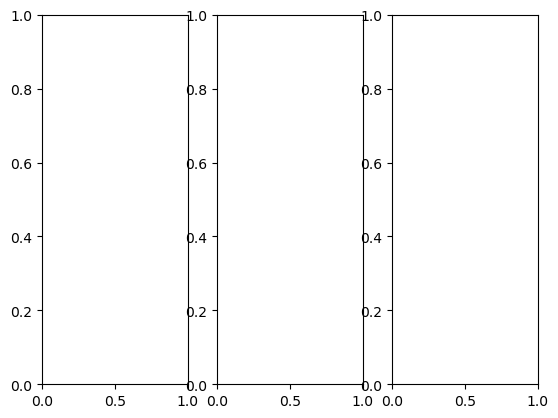

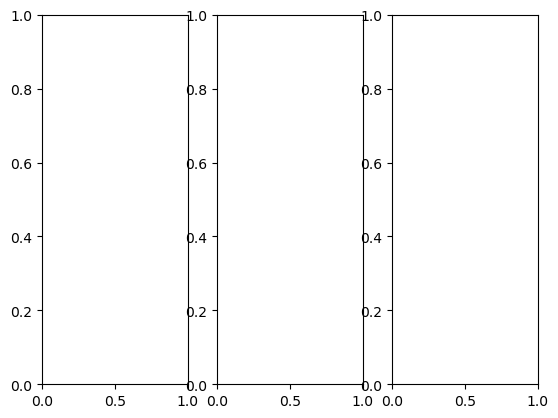

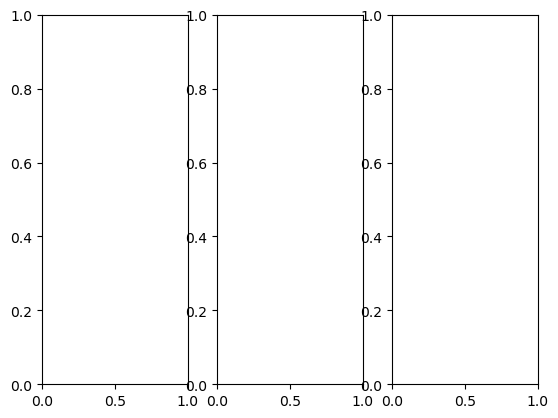

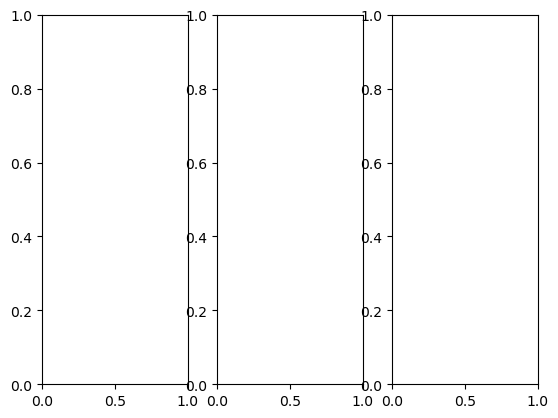

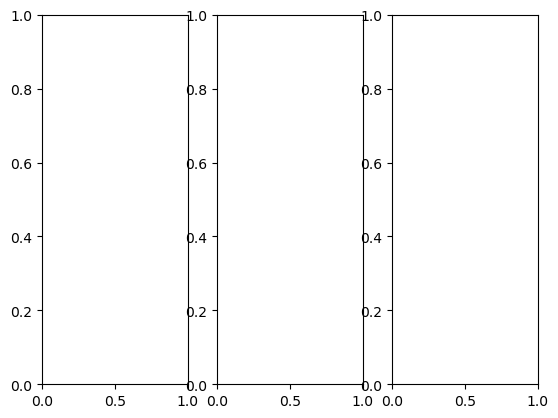

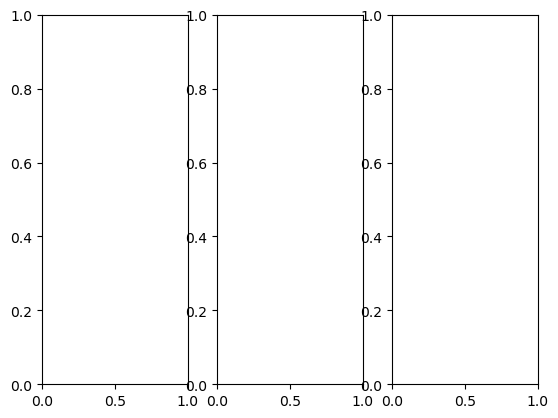

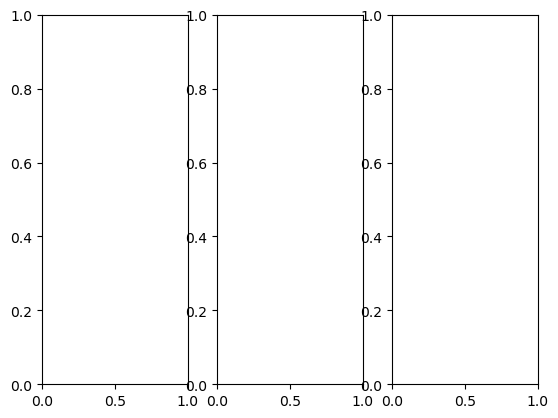

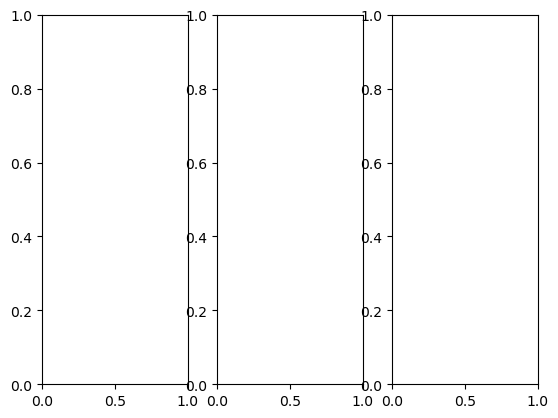

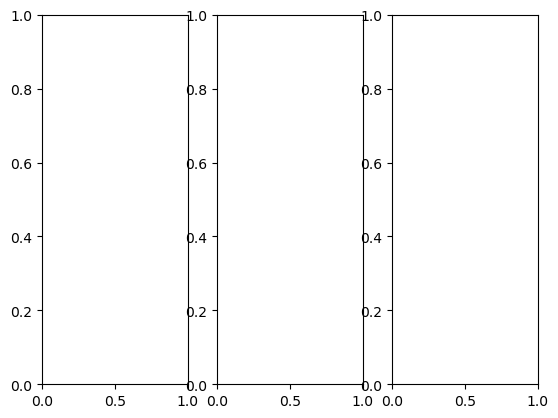

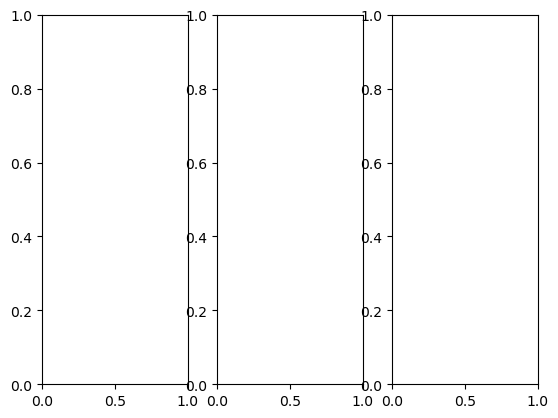

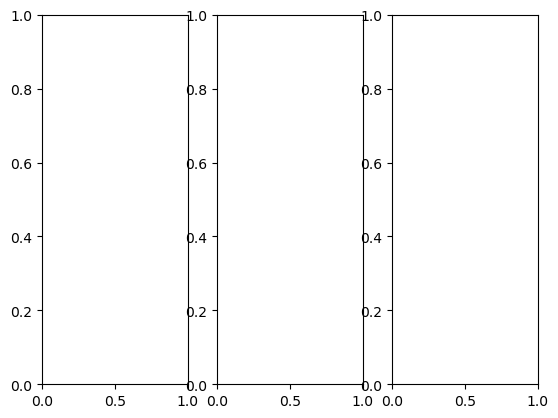

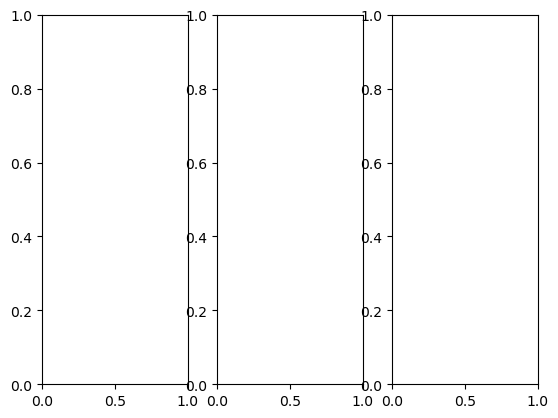

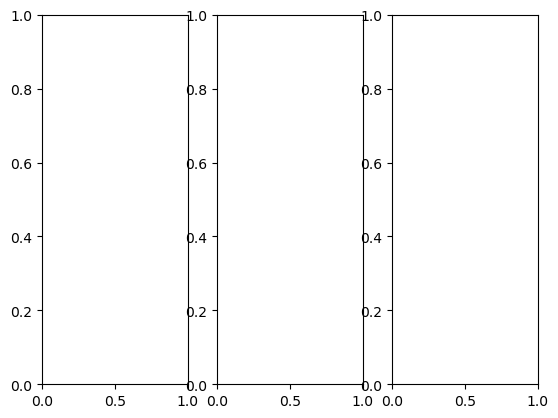

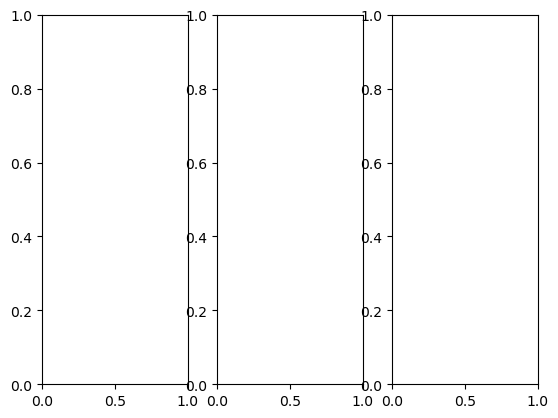

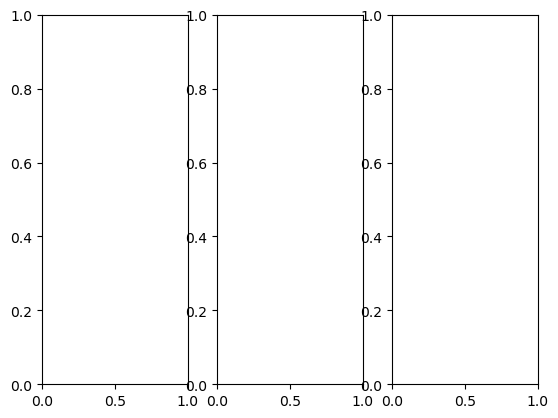

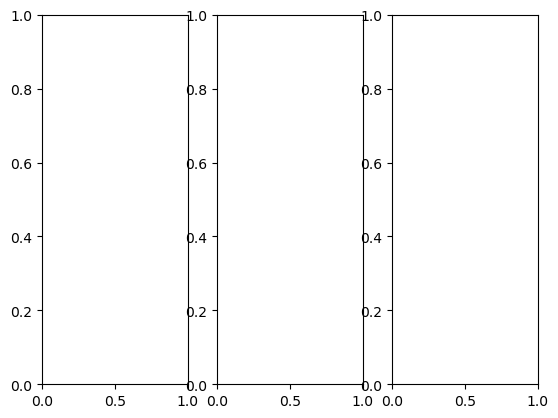

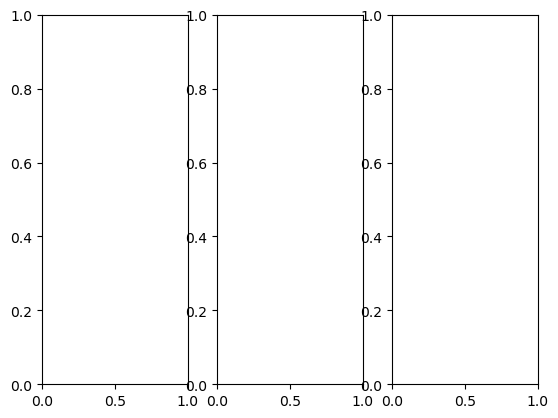

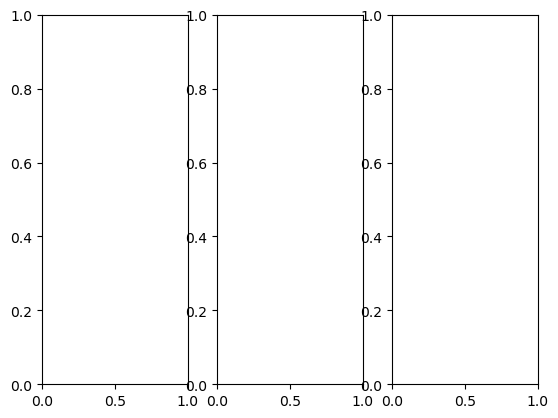

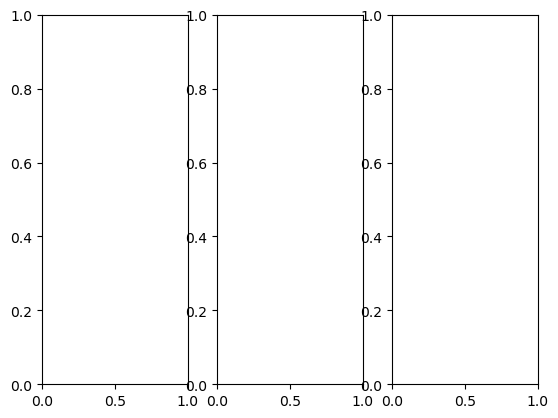

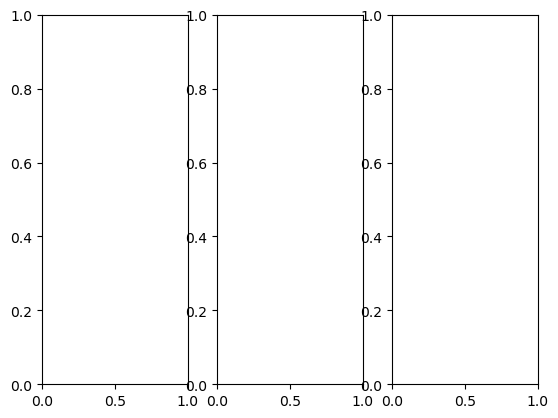

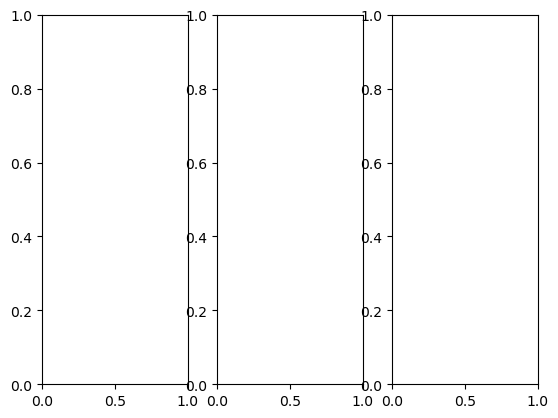

In [ ]:
for i in range(1, 10000+1):
  b_idx = np.random.randint(0, x_train.shape[0]-1, size=BATCH_SIZE)
  x0 = ca.initialize(tf.gather(x_train, b_idx))
  y0 = tf.gather(y_train_pic, b_idx)

  x, loss = train_step(x0, y0)


  step_i = len(loss_log)
  loss_log.append(loss.numpy())

  if step_i%100 == 0:
    clear_output()
    visualize_batch(ca, x0, y0, x, step_i)
    plot_loss(loss_log)
  if step_i%5000 == 0:
    export_model(ca, os.path.join(train_path, 'model/%07d'%step_i))


  print('\r step: %d, log10(loss): %.3f'%(len(loss_log), np.log10(loss)), end='')

print(step_i)
export_model(ca, os.path.join(train_path, 'model/last'))